In [64]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import wrds
import scipy.stats as stats
import statsmodels.api as sm

db=wrds.Connection(wrds_username='sahakyan')

In [65]:
# #---------------------------------------------
# # Risk Free Rate 
# #---------------------------------------------
# Rf=db.raw_sql("""select  mcaldt,tmytm 
#            from crsp.tfz_mth_rf            
#             where kytreasnox = 2000001 
#            and mcaldt>='1964-01-01'
#             and mcaldt<='2023-12-31'""", date_cols=['mcaldt'])
# Rf['tmytm']=Rf['tmytm']/12/100
# Rf=Rf.rename(columns={ "mcaldt": "date","tmytm": "rf"})


# #---------------------------------------------
# # Value Weighted Index Returns
# #---------------------------------------------
# Rm=db.raw_sql("""select  date,vwretd from crsp.msi 
#                 where date>='1964-01-01' and date<='2023-12-31'
#                 """,date_cols=['date'])
# Rm = Rm.rename(columns={'vwretd':'Rm'})

# #---------------------------------------------
# # Stock Returns 
# #---------------------------------------------
# stock_data = db.raw_sql("""
#                     select a.permno, a.date, 
#                       b.shrcd, b.exchcd,
#                       a.ret, a.shrout, a.prc, b.siccd
#                       from crsp.msf as a
#                       left join crsp.msenames as b
#                       on a.permno=b.permno
#                       and b.namedt<=a.date
#                       and a.date<=b.nameendt
#                       where a.date between '01/01/1964' and '12/31/2023'
#                       and b.exchcd between 1 and 2
#                       and b.shrcd between 10 and 11
#                       """, date_cols=['date']) 
# stock_data=stock_data.drop(['shrcd','exchcd'],axis=1)
# stock_data = stock_data.rename(columns={'ret':'Rn'})
# stock_data['mcap'] = np.abs(stock_data['prc'])*stock_data['shrout']
# stock_data['mcap_l'] = stock_data.groupby(['permno'])['mcap'].shift(1)


# #---------------------------------------------
# # Merge Data 
# #---------------------------------------------
# data = pd.merge(stock_data, Rf, on=['date'], how='left')
# data = pd.merge(data, Rm, on=['date'], how='left')
# data['const'] = 1
# data['Rn_e'] = data['Rn']-data['rf']
# data['Rm_e'] = data['Rm']-data['rf']
# data.to_csv('data.csv', sep=',',index=False) # export data

# 3 Betting against Beta strategy (BaB)

In [66]:
file_name = 'data.csv'
def clean_data(file_name):
    data = pd.read_csv(file_name, sep=',', parse_dates=['date'])

    # 0. Remove nans
    data = data.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()
    
    # get rid of the day in the date
    data['date'] = data['date'].dt.to_period('M')
    data['date'] = data['date'].dt.to_timestamp()
    # Sort data by permno and date
    data = data.sort_values(by=['permno', 'date']).reset_index(drop=True)
    # save cleaned data
    data.to_csv('data.csv', sep=',',index=False) # export data

clean_data(file_name)

#### (a) Computation of time-varying Beta

In [67]:
file_name = 'data.csv'
def add_beta_to_data(file_name):
    # load data
    data = pd.read_csv(file_name, sep=',', parse_dates=['date'])

    # 2. Estimate Rolling Betas
    cov_nm = data.set_index('date').groupby('permno')[['Rn_e','Rm_e']].rolling(window = 60, min_periods=36).cov()
    beta_n = (cov_nm.iloc[0::2,1].droplevel(2)/cov_nm.iloc[1::2,1].droplevel(2))
    beta_n = beta_n.dropna().reset_index().rename(columns={'Rm_e':'beta'})

    # 3. Merge betas with data
    beta_n['date'] = beta_n['date'] + pd.DateOffset(months=1)
    data = data.merge(beta_n, on=['permno','date'], how='left')

    # get rid of nan values
    data = data.dropna(subset=['beta']).copy()

    # 4. Remove outliers
    data['beta'] = data['beta'].clip(data['beta'].quantile(0.05),data['beta'].quantile(0.95))
    # save data with the beta
    data.to_csv('data_with_beta_n.csv', sep=',',index=False)

add_beta_to_data(file_name)

#### (B) Beta Deciles

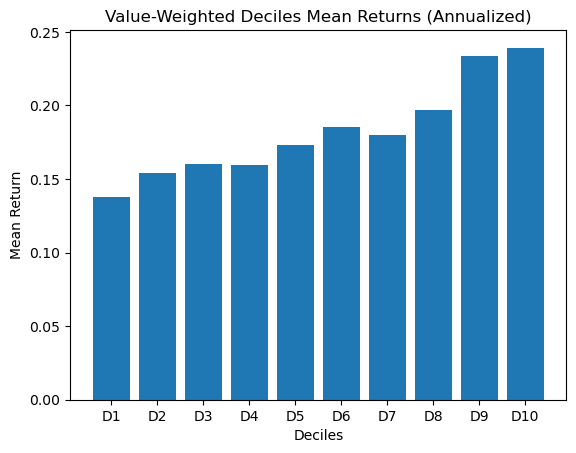

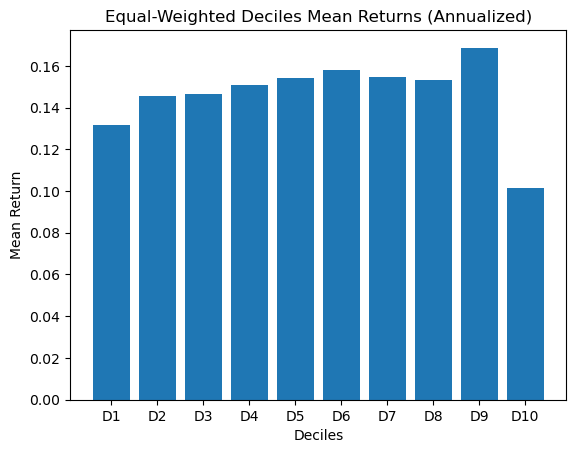

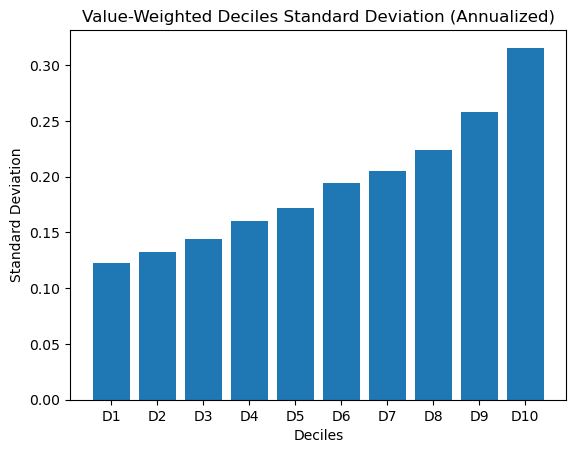

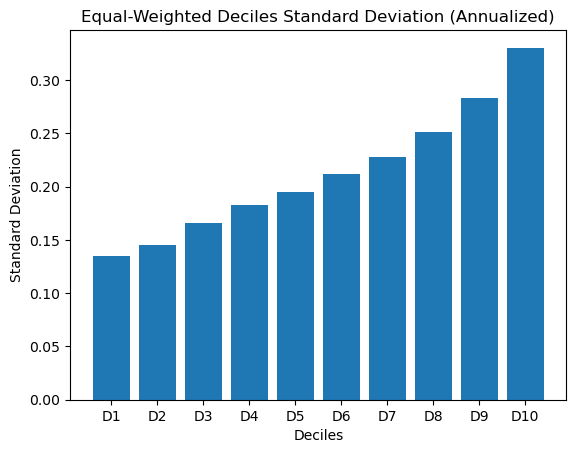

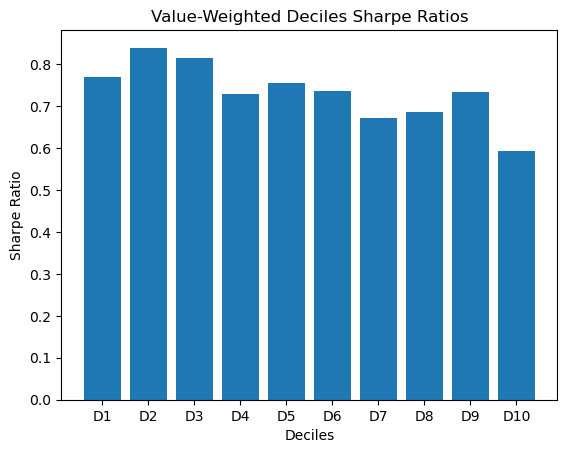

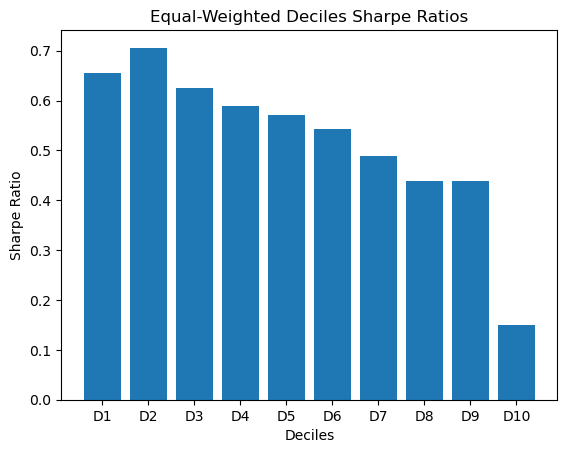

In [68]:
file_name = 'data_with_beta_n.csv'
def compute_beta_deciles(file_name):
    # load data
    data = pd.read_csv(file_name, sep=',', parse_dates=['date'])

    # (b)
    # 1. Deciles
    data['beta_Q'] = data.groupby('date')['beta'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))
    # 2. Market Weights within deciles
    data['vw_Q'] = data['mcap'] / data.groupby(['date', 'beta_Q'])['mcap'].transform('sum')

    # 3. VW Portfolios
    data['beta_ret_vw'] = data['vw_Q'] * data['Rn']
    ret_vw = data.groupby(['date', 'beta_Q'])['beta_ret_vw'].sum().reset_index()
    vw_ret_mean = ret_vw.groupby('beta_Q')['beta_ret_vw'].mean()

    # 4. Equal-Weighted portfolios
    ret_ew = data.groupby(['date', 'beta_Q'])['Rn'].mean().reset_index()
    ew_ret_mean = ret_ew.groupby('beta_Q')['Rn'].mean()

    # Calculate standard deviations
    vw_ret_std = ret_vw.groupby('beta_Q')['beta_ret_vw'].std()
    ew_ret_std = ret_ew.groupby('beta_Q')['Rn'].std()

    # Compute the Sharpe Ratios for each decile

    # compute the risk-free rate
    rf = data.groupby(['date', 'beta_Q'])['rf'].mean().reset_index()

    # compute the excess returns
    ret_vw['excess'] = ret_vw['beta_ret_vw'] - rf['rf']
    ret_ew['excess'] = ret_ew['Rn'] - rf['rf']

    # compute the Sharpe Ratios
    vw_sharpe = ret_vw.groupby('beta_Q')['excess'].mean() / ret_vw.groupby('beta_Q')['beta_ret_vw'].std()
    ew_sharpe = ret_ew.groupby('beta_Q')['excess'].mean() / ret_ew.groupby('beta_Q')['Rn'].std()

    # 5. Plot Histograms
    deciles = ['D' + str(x) for x in np.arange(1, 11)]

    directory = 'Plots/Part3'

    #save plots
    # Plot VW mean returns
    plt.bar(deciles, vw_ret_mean * 12)
    plt.title('Value-Weighted Deciles Mean Returns (Annualized)')
    plt.xlabel('Deciles')
    plt.ylabel('Mean Return')
    plt.savefig(directory + '/vw_ret_mean.png')
    plt.show()

    # Plot EW mean returns
    plt.bar(deciles, ew_ret_mean * 12)
    plt.title('Equal-Weighted Deciles Mean Returns (Annualized)')
    plt.xlabel('Deciles')
    plt.ylabel('Mean Return')
    plt.savefig(directory + '/ew_ret_mean.png')
    plt.show()

    # Plot VW standard deviations
    plt.bar(deciles, vw_ret_std * np.sqrt(12))
    plt.title('Value-Weighted Deciles Standard Deviation (Annualized)')
    plt.xlabel('Deciles')
    plt.ylabel('Standard Deviation')
    plt.savefig(directory + '/vw_ret_std.png')
    plt.show()

    # Plot EW standard deviations
    plt.bar(deciles, ew_ret_std * np.sqrt(12))
    plt.title('Equal-Weighted Deciles Standard Deviation (Annualized)')
    plt.xlabel('Deciles')
    plt.ylabel('Standard Deviation')
    plt.savefig(directory + '/ew_ret_std.png')
    plt.show()

    # Plot VW Sharpe Ratios
    plt.bar(deciles, vw_sharpe* np.sqrt(12))
    plt.title('Value-Weighted Deciles Sharpe Ratios')
    plt.xlabel('Deciles')
    plt.ylabel('Sharpe Ratio')
    plt.savefig(directory + '/vw_sharpe.png')
    plt.show()

    # Plot EW Sharpe Ratios
    plt.bar(deciles, ew_sharpe* np.sqrt(12))
    plt.title('Equal-Weighted Deciles Sharpe Ratios')
    plt.xlabel('Deciles')
    plt.ylabel('Sharpe Ratio')
    plt.savefig(directory + '/ew_sharpe.png')
    plt.show()

compute_beta_deciles(file_name)

#### (c/d) Construct BAB factor

In [69]:
file_name = 'data_with_beta_n.csv'
def construct_BAB_factor(file_name) :
    # load data
    data = pd.read_csv(file_name, sep=',', parse_dates=['date'])
    
    # Weights
    data['z'] = data.groupby('date')['beta'].transform(lambda x: x.rank())
    data['z_'] = data['z']-data.groupby('date')['z'].transform('mean')
    data['k'] = np.abs(data['z_'])
    data['k'] = 2/data.groupby('date')['k'].transform('sum')
    data['w_H'] = data['k'] * data['z_'] * (data['z_']>0) 
    data['w_L'] = -data['k'] * data['z_'] * (data['z_']<0)

    # Weighted returns and beta
    data['beta_H'] = data['w_H'] * data['beta']
    data['beta_L'] = data['w_L'] * data['beta']
    data['R_H_e'] = data['w_H'] * data['Rn_e']
    data['R_L_e'] = data['w_L'] * data['Rn_e']

    # Sum up the weighted returns and betas but not the rf
    BAB = data.groupby('date')[['R_H_e','R_L_e','beta_H','beta_L']].sum().reset_index()
    BAB['rf'] = data.groupby('date')['rf'].mean().reset_index()['rf']
    # unlevered returns
    BAB['BAB2'] = (BAB['R_L_e']/BAB['beta_L']) - ( BAB['R_H_e']/BAB['beta_H'] )

    # Merge Market and Risk free Rate
    tmp = pd.merge(BAB,data[['date','Rm_e']].drop_duplicates(), on=['date'], how='left')
    tmp['alpha'] = 1

    # Alpha and Beta
    tmp = tmp.dropna()
    OLS_Reg = sm.OLS(tmp['BAB2'], tmp[['alpha','Rm_e']]).fit()

    # Report the mean,standard deviation, and sharpe ratio and CAPM alpha of the BAB factor
    print('Mean:', tmp['BAB2'].mean()*12)
    print('Standard Deviation:', tmp['BAB2'].std()*np.sqrt(12))
    # Annualize the Sharpe ratio and CAPM alpha
    print('Sharpe ratio:', tmp['BAB2'].mean()/tmp['BAB2'].std()*np.sqrt(12))
    print('Monthly CAPM Alpha:', OLS_Reg.params['alpha']*12)
    strat = BAB[['date','rf','BAB2']]
    strat.to_csv('strat.csv', sep=',',index=False) # export data

construct_BAB_factor(file_name)

Mean: 0.1185233475929563
Standard Deviation: 0.1407311146854935
Sharpe ratio: 0.8421971776307803
Monthly CAPM Alpha: 0.08312883566500989


# 4 Momentum Strategy (Mom)

#### (a) Computating mom return

In [70]:
file_name = 'data.csv'
def computing_mom_return(file_name):
    # load data
    data = pd.read_csv(file_name, sep=',', parse_dates=['date'])

    data['LN_Cret12'] = data.groupby('permno').apply(lambda x: np.log(x.Rn+1).rolling(11, min_periods = 11, closed='left').sum()).values

    # shift the LN_Cret12 column by 1
    data['LN_Cret12'] = data.groupby('permno')['LN_Cret12'].shift(1)
    data.dropna(subset=['LN_Cret12'], inplace=True)

    q = 10
    data['Momentum'] = data.groupby('date')['LN_Cret12'].transform(lambda x: pd.qcut(x,q,labels=False, duplicates='drop'))
    # save data with the beta
    data.to_csv('data_with_momentum.csv', sep=',',index=False)

computing_mom_return(file_name)
    

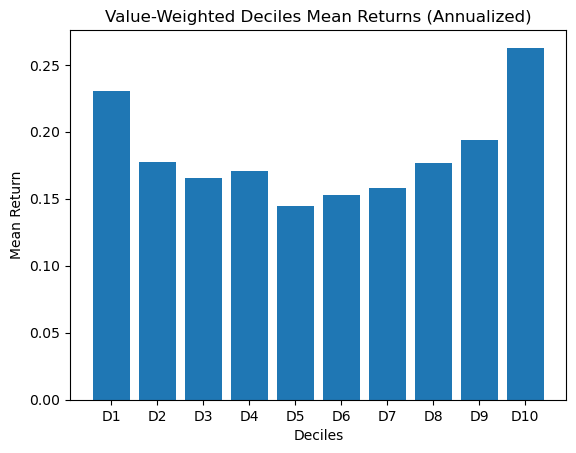

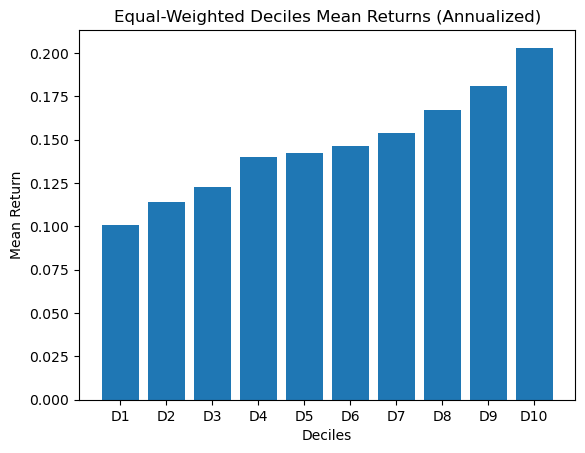

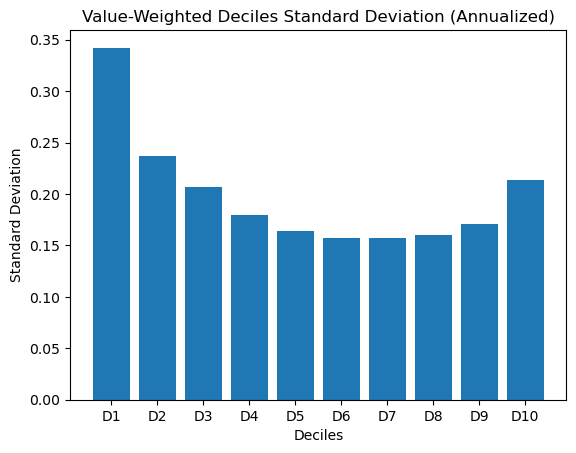

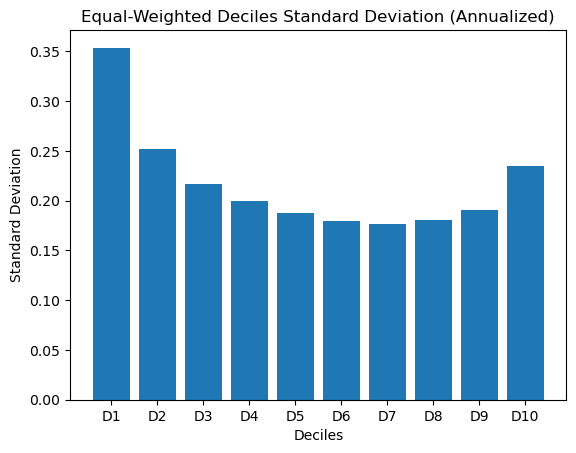

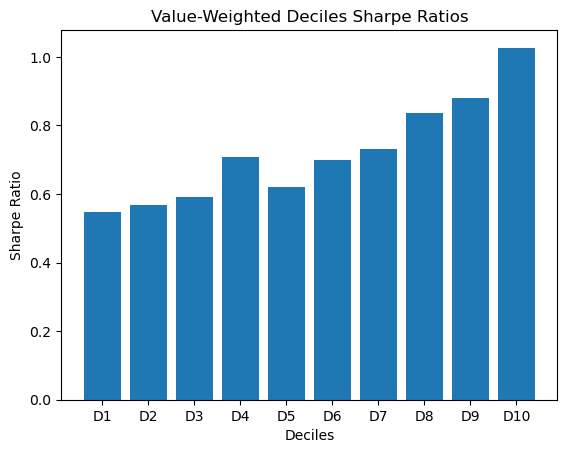

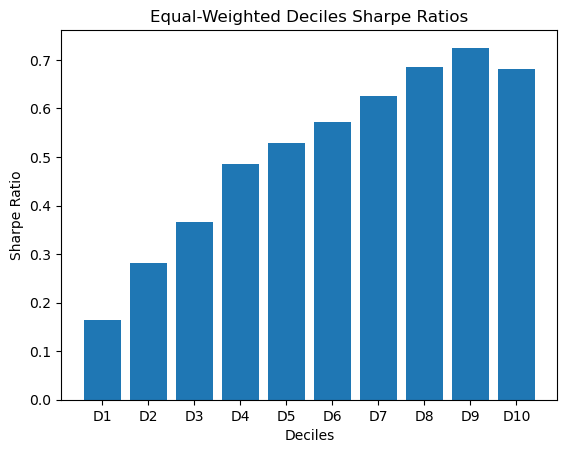

In [71]:
file_name = 'data_with_momentum.csv'
def compute_mom_deciles(file_name):
    # load data
    data = pd.read_csv(file_name, sep=',', parse_dates=['date'])

    # 2. Market Weights within deciles
    data['vw_Q'] = data['mcap']/data.groupby(['date','Momentum'])['mcap'].transform('sum')

    # 3. VW Portfolios
    data['MOM_ret_vw'] = data['vw_Q']*data['Rn']
    ret_vw = data.groupby(['date','Momentum'])['MOM_ret_vw'].sum().reset_index()
    vw_ret_mean = ret_vw.groupby('Momentum')['MOM_ret_vw'].mean()

    # 4. Equal-Weighted portfolios
    ret_ew = data.groupby(['date','Momentum'])['Rn'].mean().reset_index()
    ew_ret_mean = ret_ew.groupby('Momentum')['Rn'].mean()
    # Calculate standard deviations
    vw_ret_std = ret_vw.groupby('Momentum')['MOM_ret_vw'].std()
    ew_ret_std = ret_ew.groupby('Momentum')['Rn'].std()

    # Calculate Sharpe Ratios

    # compute the risk-free rate
    rf = data.groupby(['date', 'Momentum'])['rf'].mean().reset_index()

    # compute the excess returns
    ret_vw['excess'] = ret_vw['MOM_ret_vw'] - rf['rf']
    ret_ew['excess'] = ret_ew['Rn'] - rf['rf']

    # compute the Sharpe Ratios
    vw_sharpe_ratio = ret_vw.groupby('Momentum')['excess'].mean() / vw_ret_std
    ew_sharpe_ratio = ret_ew.groupby('Momentum')['excess'].mean() / ew_ret_std

    # save data with the mom
    data.to_csv('data_with_momentum.csv', sep=',',index=False)


    # 5. Plot Histograms
    deciles = ['D' + str(x) for x in np.arange(1, 11)]

    directory = 'Plots/Part4/'
    #save plots
    # Plot VW mean returns
    plt.bar(deciles, vw_ret_mean * 12)
    plt.title('Value-Weighted Deciles Mean Returns (Annualized)')
    plt.xlabel('Deciles')
    plt.ylabel('Mean Return')
    plt.savefig(directory + 'vw_ret_mean.png')
    plt.show()

    # Plot EW mean returns
    plt.bar(deciles, ew_ret_mean * 12)
    plt.title('Equal-Weighted Deciles Mean Returns (Annualized)')
    plt.xlabel('Deciles')
    plt.ylabel('Mean Return')
    plt.savefig(directory + 'ew_ret_mean.png')
    plt.show()

    # Plot VW standard deviations
    plt.bar(deciles, vw_ret_std * np.sqrt(12))
    plt.title('Value-Weighted Deciles Standard Deviation (Annualized)')
    plt.xlabel('Deciles')
    plt.ylabel('Standard Deviation')
    plt.savefig(directory + 'vw_ret_std.png')
    plt.show()

    # Plot EW standard deviations
    plt.bar(deciles, ew_ret_std * np.sqrt(12))
    plt.title('Equal-Weighted Deciles Standard Deviation (Annualized)')
    plt.xlabel('Deciles')
    plt.ylabel('Standard Deviation')
    plt.savefig(directory + 'ew_ret_std.png')
    plt.show()

    # Plot VW Sharpe ratios
    plt.bar(deciles, vw_sharpe_ratio * np.sqrt(12))
    plt.title('Value-Weighted Deciles Sharpe Ratios')
    plt.xlabel('Deciles')
    plt.ylabel('Sharpe Ratio')
    plt.savefig(directory + 'vw_sharpe_ratio.png')
    plt.show()

    # Plot EW Sharpe ratios
    plt.bar(deciles, ew_sharpe_ratio * np.sqrt(12))
    plt.title('Equal-Weighted Deciles Sharpe Ratios')
    plt.xlabel('Deciles')
    plt.ylabel('Sharpe Ratio')
    plt.savefig(directory + 'ew_sharpe_ratio.png')
    plt.show()

compute_mom_deciles(file_name)

### Factor creation

#### Equal-Weighted Long-Short Factor Strategy

In [72]:
file_name = 'data_with_momentum.csv'
def mom_equal_weigthed_factor(file_name):
    # load data
    data = pd.read_csv(file_name, sep=',', parse_dates=['date'])
    # 1. Compute the long and short legs of the strategy
    ew_long_leg = data[data['Momentum'] >= 7].groupby('date')['Rn'].mean().reset_index()
    ew_short_leg = data[data['Momentum'] < 3].groupby('date')['Rn'].mean().reset_index()

    # 2. Compute the excess returns
    rf = data.groupby(['date', 'Momentum'])['rf'].mean().reset_index()

    ew_long_leg['excess'] = ew_long_leg['Rn'] - rf['rf']
    ew_short_leg['excess'] = ew_short_leg['Rn'] - rf['rf']

    # 3. Compute the mean, excess mean, standard deviation, and Sharpe ratios
    long_mean = ew_long_leg['Rn'].mean() * 12
    short_mean = ew_short_leg['Rn'].mean() * 12

    long_mean_e = ew_long_leg['excess'].mean() * 12
    short_mean_e = ew_short_leg['excess'].mean() * 12

    long_std = ew_long_leg['Rn'].std() * np.sqrt(12)
    short_std = ew_short_leg['Rn'].std() * np.sqrt(12)

    long_sharpe_ratio = long_mean_e / long_std
    short_sharpe_ratio = short_mean_e / short_std

    # Long minus short factor strategy
    factor = ew_long_leg.set_index("date") - ew_short_leg.set_index("date")
    factor = factor.reset_index()
    factor['excess'] = factor['Rn'] - rf['rf']

    factor_mean = factor['Rn'].mean() * 12
    factor_mean_e = factor['excess'].mean() * 12
    factor_std = factor['Rn'].std() * np.sqrt(12)
    factor_sharpe_ratio = factor_mean_e / factor_std

    # 4. Print the results
    print('Long Leg Mean Return:', long_mean)
    print('Short Leg Mean Return:', short_mean)
    print('Long Leg Standard Deviation:', long_std)
    print('Short Leg Standard Deviation:', short_std)
    print('Long Leg Sharpe Ratio:', long_sharpe_ratio)
    print('Short Leg Sharpe Ratio:', short_sharpe_ratio)
    print('Factor Mean Return:', factor_mean)
    print('Factor Standard Deviation:', factor_std)
    print('Factor Sharpe Ratio:', factor_sharpe_ratio)

    # Test if the factor strategy has an average return that is statistically significantly different from zero

    # 1. Compute the t-statistic
    t_stat = factor_mean / (factor_std / np.sqrt(len(factor)))

    # 2. Compute the p-value
    p_value = 1 - stats.norm.cdf(t_stat)

    # 3. Print the results
    print('T-Statistic:', t_stat)
    print('P-Value:', p_value)

    # 4. Check if the p-value is less than 0.05
    if p_value < 0.05:
        print('The factor strategy has an average return that is statistically significantly different from zero.')
    else:
        print('The factor strategy does not have an average return that is statistically significantly different from zero.')


mom_equal_weigthed_factor(file_name)

Long Leg Mean Return: 0.18353907294932545
Short Leg Mean Return: 0.11244087782078921
Long Leg Standard Deviation: 0.19793760417063025
Short Leg Standard Deviation: 0.2670460946117143
Long Leg Sharpe Ratio: 0.6757581679530451
Short Leg Sharpe Ratio: 0.23464023215142432
Factor Mean Return: 0.07109819512853627
Factor Standard Deviation: 0.1659185481297776
Factor Sharpe Ratio: 0.12847915548234667
T-Statistic: 11.393924678913178
P-Value: 0.0
The factor strategy has an average return that is statistically significantly different from zero.


#### Value-Weighted Long-Short Factor Strategy

In [73]:
file_name = 'data_with_momentum.csv'
strat_file = 'strat.csv'
def mom_value_weigthed_factor(file_name, strat_file):
    # load data
    data = pd.read_csv(file_name, sep=',', parse_dates=['date'])
    #1. Compute the long and short legs of the strategy
    vw_long_leg = data[data['Momentum'] >= 7].groupby('date')['MOM_ret_vw'].sum().reset_index()
    vw_short_leg = data[data['Momentum'] < 3].groupby('date')['MOM_ret_vw'].sum().reset_index()

    # 2. Compute the excess returns
    rf = data.groupby(['date', 'Momentum'])['rf'].mean().reset_index()

    vw_long_leg['excess'] = vw_long_leg['MOM_ret_vw'] - rf['rf']
    vw_short_leg['excess'] = vw_short_leg['MOM_ret_vw'] - rf['rf']

    # 3. Compute the mean, excess mean, standard deviation, and Sharpe ratios
    long_mean = vw_long_leg['MOM_ret_vw'].mean() * 12
    short_mean = vw_short_leg['MOM_ret_vw'].mean() * 12

    long_mean_e = vw_long_leg['excess'].mean() * 12
    short_mean_e = vw_short_leg['excess'].mean() * 12

    long_std = vw_long_leg['MOM_ret_vw'].std() * np.sqrt(12)
    short_std = vw_short_leg['MOM_ret_vw'].std() * np.sqrt(12)

    long_sharpe_ratio = long_mean_e / long_std
    short_sharpe_ratio = short_mean_e / short_std

    # Long minus short factor strategy
    factor = vw_long_leg.set_index("date") - vw_short_leg.set_index("date")
    factor = factor.reset_index()
    factor['excess'] = factor['MOM_ret_vw'] - rf['rf']

    factor_mean = factor['MOM_ret_vw'].mean() * 12
    factor_mean_e = factor['excess'].mean() * 12
    factor_std = factor['MOM_ret_vw'].std() * np.sqrt(12)
    factor_sharpe_ratio = factor_mean_e / factor_std

    # 4. Print the results
    print('Long Leg Mean Return:', long_mean)
    print('Short Leg Mean Return:', short_mean)
    print('Long Leg Standard Deviation:', long_std)
    print('Short Leg Standard Deviation:', short_std)
    print('Long Leg Sharpe Ratio:', long_sharpe_ratio)
    print('Short Leg Sharpe Ratio:', short_sharpe_ratio)
    print('Factor Mean Return:', factor_mean)
    print('Factor Standard Deviation:', factor_std)
    print('Factor Sharpe Ratio:', factor_sharpe_ratio)

    # Test if the factor strategy has an average return that is statistically significantly different from zero

    # 1. Compute the t-statistic
    t_stat = factor_mean / (factor_std / np.sqrt(len(factor)))

    # 2. Compute the p-value
    p_value = 1 - stats.norm.cdf(t_stat)

    # 3. Print the results
    print('T-Statistic:', t_stat)
    print('P-Value:', p_value)

    # 4. Check if the p-value is less than 0.05
    if p_value < 0.05:
        print('The factor strategy has an average return that is statistically significantly different from zero.')
    else:
        print('The factor strategy does not have an average return that is statistically significantly different from zero.')

    # load strategy data
    strat = pd.read_csv(strat_file, sep=',', parse_dates=['date'])
    strat = strat.merge(factor[['date','MOM_ret_vw']], on='date', how='left')
    # save strategy data
    strat.to_csv('strat.csv', sep=',',index=False) # export data

mom_value_weigthed_factor(file_name, strat_file)

Long Leg Mean Return: 0.6332834538780254
Short Leg Mean Return: 0.5733327251680393
Long Leg Standard Deviation: 0.5202088597429667
Short Leg Standard Deviation: 0.7490577216200898
Long Leg Sharpe Ratio: 1.1216693502305333
Short Leg Sharpe Ratio: 0.6989469434341018
Factor Mean Return: 0.059950728709985926
Factor Standard Deviation: 0.6040607857330902
Factor Sharpe Ratio: 0.01683540591312964
T-Statistic: 2.6389036271174104
P-Value: 0.00415873109845577
The factor strategy has an average return that is statistically significantly different from zero.


# 5 Idiosyncratic Volatility Strategy (IV)

In [74]:
file_name = 'data_with_beta_n.csv'
def compute_IV(file_name):
    # load data
    data = pd.read_csv(file_name, sep=',', parse_dates=['date'])
    # Calculate the predicted return
    data['predicted_return_e'] = data['beta'] * data['Rm_e']

    # Calculate the residuals
    data['residuals'] = data['Rn_e'] - data['predicted_return_e']

    # Calculate the rolling standard deviation of the residuals
    idiosyncratic_volatility = data.set_index('date').groupby('permno')['residuals'].rolling(window=60, min_periods=36).std()

    # Reset the index of the idiosyncratic_volatility Series
    idiosyncratic_volatility = idiosyncratic_volatility.reset_index()

    # Rename the 0 column to 'idiosyncratic_volatility'
    idiosyncratic_volatility = idiosyncratic_volatility.rename(columns={"residuals": 'idiosyncratic_volatility'})

    # Merge the idiosyncratic_volatility DataFrame with the original data DataFrame
    data = pd.merge(data, idiosyncratic_volatility, on=['date', 'permno'], how='left')

    # Drop the intermediate columns
    data = data.drop(columns=['predicted_return_e', 'residuals'])

    # Drop nans in the idiosyncratic_volatility and beta columns
    data = data.dropna(subset=['idiosyncratic_volatility'])

    # 4. Remove outliers
    data['idiosyncratic_volatility'] = data['idiosyncratic_volatility'].clip(data['idiosyncratic_volatility'].quantile(0.05),data['idiosyncratic_volatility'].quantile(0.95))

    # Save the data
    data.to_csv('data_with_IV.csv', sep=',',index=False)

compute_IV(file_name)
    

### Sorting

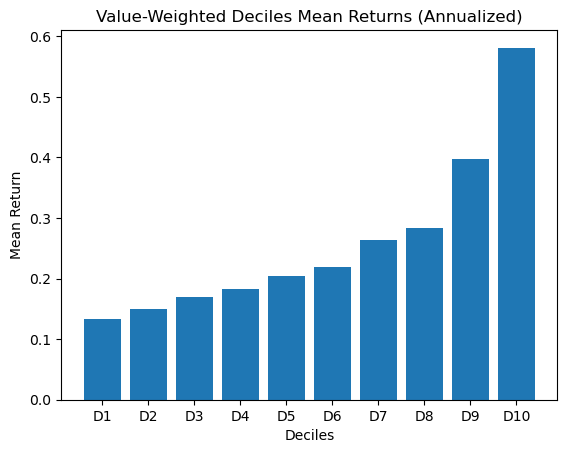

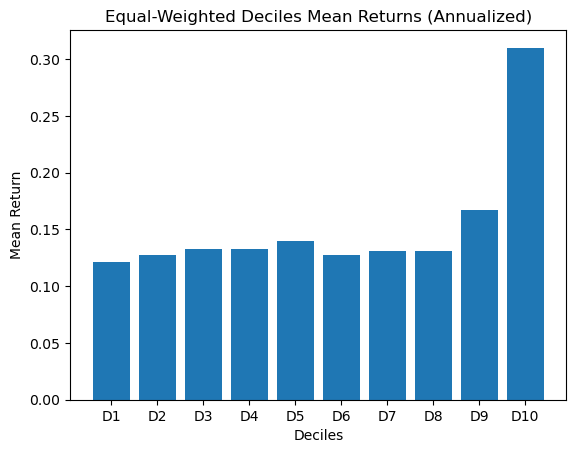

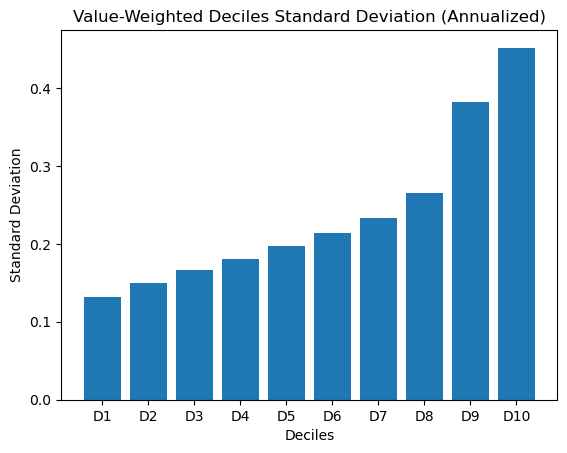

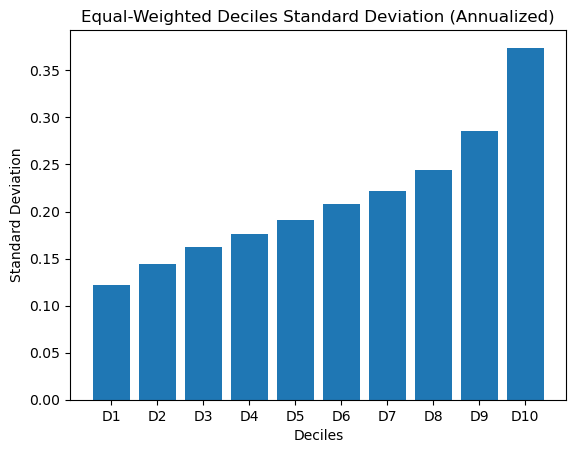

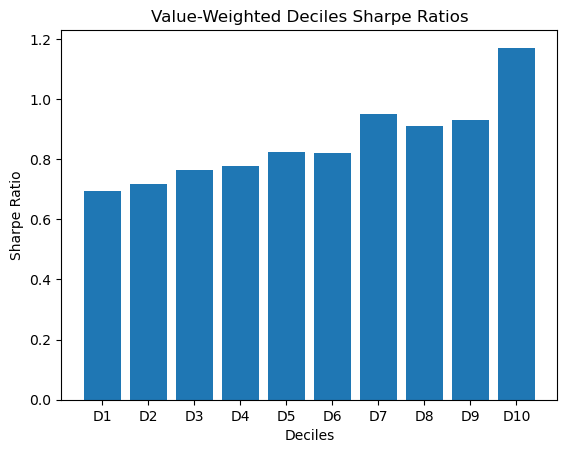

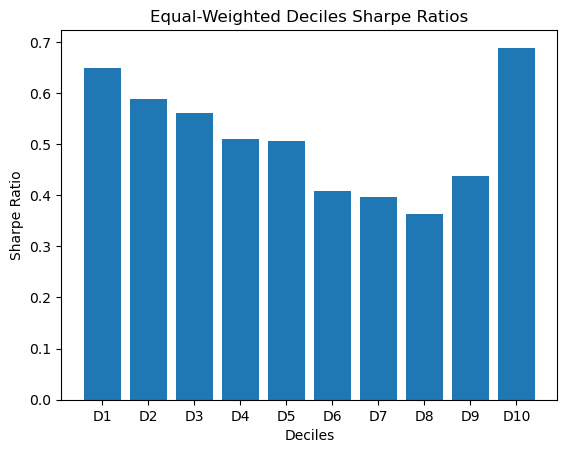

In [75]:
file_name = 'data_with_IV.csv'

def compute_IV_deciles(file_name):
    # load data
    data = pd.read_csv(file_name, sep=',', parse_dates=['date'])
    data['IV_Q'] = data.groupby('date')['idiosyncratic_volatility'].transform(lambda x: pd.qcut(x, 10,labels=False, duplicates='drop'))

    # 2. Market Weights within deciles
    data['vw_Q'] = data['mcap']/data.groupby(['date','IV_Q'])['mcap'].transform('sum')

    # 3. VW Portfolios
    data['IV_ret_vw'] = data['vw_Q']*data['Rn']
    ret_vw = data.groupby(['date','IV_Q'])['IV_ret_vw'].sum().reset_index()
    vw_ret_mean = ret_vw.groupby('IV_Q')['IV_ret_vw'].mean()

    # 4. Equal-Weighted portfolios
    ret_ew = data.groupby(['date','IV_Q'])['Rn'].mean().reset_index()
    ew_ret_mean = ret_ew.groupby('IV_Q')['Rn'].mean()
    # Calculate standard deviations
    vw_ret_std = ret_vw.groupby('IV_Q')['IV_ret_vw'].std()
    ew_ret_std = ret_ew.groupby('IV_Q')['Rn'].std()

    # Calculate Sharpe Ratios

    # compute the risk-free rate
    rf = data.groupby(['date', 'IV_Q'])['rf'].mean().reset_index()

    # compute the excess returns
    ret_vw['excess'] = ret_vw['IV_ret_vw'] - rf['rf']
    ret_ew['excess'] = ret_ew['Rn'] - rf['rf']

    # compute the Sharpe Ratios
    vw_sharpe_ratio = ret_vw.groupby('IV_Q')['excess'].mean() / vw_ret_std
    ew_sharpe_ratio = ret_ew.groupby('IV_Q')['excess'].mean() / ew_ret_std

    # save data with the IV
    data.to_csv('data_with_IV.csv', sep=',',index=False)
    # 5. Plot Histograms
    deciles = ['D' + str(x) for x in np.arange(1, 11)]

    directory = 'Plots/Part5/'
    #save plots
    # Plot VW mean returns
    plt.bar(deciles, vw_ret_mean * 12)
    plt.title('Value-Weighted Deciles Mean Returns (Annualized)')
    plt.xlabel('Deciles')
    plt.ylabel('Mean Return')
    plt.savefig(directory + 'vw_ret_mean.png')
    plt.show()

    # Plot EW mean returns
    plt.bar(deciles, ew_ret_mean * 12)
    plt.title('Equal-Weighted Deciles Mean Returns (Annualized)')
    plt.xlabel('Deciles')
    plt.ylabel('Mean Return')
    plt.savefig(directory + 'ew_ret_mean.png')
    plt.show()

    # Plot VW standard deviations
    plt.bar(deciles, vw_ret_std * np.sqrt(12))
    plt.title('Value-Weighted Deciles Standard Deviation (Annualized)')
    plt.xlabel('Deciles')
    plt.ylabel('Standard Deviation')
    plt.savefig(directory + 'vw_ret_std.png')
    plt.show()

    # Plot EW standard deviations
    plt.bar(deciles, ew_ret_std * np.sqrt(12))
    plt.title('Equal-Weighted Deciles Standard Deviation (Annualized)')
    plt.xlabel('Deciles')
    plt.ylabel('Standard Deviation')
    plt.savefig(directory + 'ew_ret_std.png')
    plt.show()

    # Plot VW Sharpe ratios
    plt.bar(deciles, vw_sharpe_ratio * np.sqrt(12))
    plt.title('Value-Weighted Deciles Sharpe Ratios')
    plt.xlabel('Deciles')
    plt.ylabel('Sharpe Ratio')
    plt.savefig(directory + 'vw_sharpe_ratio.png')
    plt.show()

    # Plot EW Sharpe ratios
    plt.bar(deciles, ew_sharpe_ratio * np.sqrt(12))
    plt.title('Equal-Weighted Deciles Sharpe Ratios')
    plt.xlabel('Deciles')
    plt.ylabel('Sharpe Ratio')
    plt.savefig(directory + 'ew_sharpe_ratio.png')
    plt.show()

compute_IV_deciles(file_name)


In [76]:
file_name = 'data_with_IV.csv'
def IV_equal_weigthed_factor(file_name):
    # load data
    data = pd.read_csv(file_name, sep=',', parse_dates=['date'])

    # 1. Compute the long and short legs of the strategy
    long_leg = data[data['IV_Q'] >= 7].groupby('date')['Rn'].mean().reset_index()
    short_leg = data[data['IV_Q'] < 3].groupby('date')['Rn'].mean().reset_index()

    # 2. Compute the excess returns
    rf = data.groupby(['date', 'IV_Q'])['rf'].mean().reset_index()

    long_leg['excess'] = long_leg['Rn'] - rf['rf']
    short_leg['excess'] = short_leg['Rn'] - rf['rf']

    # 3. Compute the mean, excess mean, standard deviation, and Sharpe ratios
    long_mean = long_leg['Rn'].mean() * 12
    short_mean = short_leg['Rn'].mean() *12

    long_mean_e = long_leg['excess'].mean() *12
    short_mean_e = short_leg['excess'].mean() * 12

    long_std = long_leg['Rn'].std() * np.sqrt(12)
    short_std = short_leg['Rn'].std() * np.sqrt(12)

    long_sharpe_ratio = long_mean_e / long_std
    short_sharpe_ratio = short_mean_e / short_std

    # Long minus short factor strategy
    factor = long_leg.set_index("date") - short_leg.set_index("date")
    factor = factor.reset_index()
    factor['excess'] = factor['Rn'] - rf['rf']

    factor_mean = factor['Rn'].mean() * 12
    factor_mean_e = factor['excess'].mean() * 12
    factor_std = factor['Rn'].std() * np.sqrt(12)
    factor_sharpe_ratio = factor_mean_e / factor_std

    # 4. Print the results
    print('Long Leg Mean Return:', long_mean)
    print('Short Leg Mean Return:', short_mean)
    print('Long Leg Standard Deviation:', long_std)
    print('Short Leg Standard Deviation:', short_std)
    print('Long Leg Sharpe Ratio:', long_sharpe_ratio)
    print('Short Leg Sharpe Ratio:', short_sharpe_ratio)
    print('Factor Mean Return:', factor_mean)
    print('Factor Standard Deviation:', factor_std)
    print('Factor Sharpe Ratio:', factor_sharpe_ratio)

    # Test if the factor strategy has an average return that is statistically significantly different from zero

    # 1. Compute the t-statistic
    t_stat = factor_mean / (factor_std / np.sqrt(len(factor)))

    # 2. Compute the p-value
    p_value = 1 - stats.norm.cdf(t_stat)

    # 3. Print the results
    print('T-Statistic:', t_stat)
    print('P-Value:', p_value)

    # 4. Check if the p-value is less than 0.05
    if p_value < 0.05:
        print('The factor strategy has an average return that is statistically significantly different from zero.')
    else:
        print('The factor strategy does not have an average return that is statistically significantly different from zero.')

IV_equal_weigthed_factor(file_name)

Long Leg Mean Return: 0.18845634407390885
Short Leg Mean Return: 0.1279017234413008
Long Leg Standard Deviation: 0.28479075990029207
Short Leg Standard Deviation: 0.13902082747845806
Long Leg Sharpe Ratio: 0.46497517316813963
Short Leg Sharpe Ratio: 0.5169442131241261
Factor Mean Return: 0.06055462063260801
Factor Standard Deviation: 0.20240937463240855
Factor Sharpe Ratio: 0.02232559370449261
T-Statistic: 7.609722238514161
P-Value: 1.3766765505351941e-14
The factor strategy has an average return that is statistically significantly different from zero.


Value weighted factor strategy

In [77]:
file_name = 'data_with_IV.csv'
strat_file = 'strat.csv'
def IV_value_weigthed_factor(file_name):
    # load data
    data = pd.read_csv(file_name, sep=',', parse_dates=['date'])
    #1. Compute the long and short legs of the strategy
    vw_long_leg = data[data['IV_Q'] >= 7].groupby('date')['IV_ret_vw'].sum().reset_index()
    vw_short_leg = data[data['IV_Q'] < 3].groupby('date')['IV_ret_vw'].sum().reset_index()

    # 2. Compute the excess returns
    rf = data.groupby(['date', 'IV_Q'])['rf'].mean().reset_index()

    vw_long_leg['excess'] = vw_long_leg['IV_ret_vw'] - rf['rf']
    vw_short_leg['excess'] = vw_short_leg['IV_ret_vw'] - rf['rf']

    # 3. Compute the mean, excess mean, standard deviation, and Sharpe ratios
    long_mean = vw_long_leg['IV_ret_vw'].mean() * 12
    short_mean = vw_short_leg['IV_ret_vw'].mean() * 12

    long_mean_e = vw_long_leg['excess'].mean() * 12
    short_mean_e = vw_short_leg['excess'].mean() * 12

    long_std = vw_long_leg['IV_ret_vw'].std() * np.sqrt(12)
    short_std = vw_short_leg['IV_ret_vw'].std() * np.sqrt(12)

    long_sharpe_ratio = long_mean_e / long_std
    short_sharpe_ratio = short_mean_e / short_std

    # Long minus short factor strategy
    factor = vw_long_leg.set_index("date") - vw_short_leg.set_index("date")
    factor = factor.reset_index()
    factor['excess'] = factor['IV_ret_vw'] - rf['rf']

    factor_mean = factor['IV_ret_vw'].mean()
    factor_mean_e = factor['excess'].mean()
    factor_std = factor['IV_ret_vw'].std()
    factor_sharpe_ratio = factor_mean_e / factor_std

    # 4. Print the results
    print('Long Leg Mean Return:', long_mean)
    print('Short Leg Mean Return:', short_mean)
    print('Long Leg Standard Deviation:', long_std)
    print('Short Leg Standard Deviation:', short_std)
    print('Long Leg Sharpe Ratio:', long_sharpe_ratio)
    print('Short Leg Sharpe Ratio:', short_sharpe_ratio)
    print('Factor Mean Return:', factor_mean)
    print('Factor Standard Deviation:', factor_std)
    print('Factor Sharpe Ratio:', factor_sharpe_ratio)

    # Test if the factor strategy has an average return that is statistically significantly different from zero

    # 1. Compute the t-statistic
    t_stat = factor_mean / (factor_std / np.sqrt(len(factor)))

    # 2. Compute the p-value
    p_value = 1 - stats.norm.cdf(t_stat)

    # 3. Print the results
    print('T-Statistic:', t_stat)
    print('P-Value:', p_value)

    # 4. Check if the p-value is less than 0.05
    if p_value < 0.05:
        print('The factor strategy has an average return that is statistically significantly different from zero.')
    else:
        print('The factor strategy does not have an average return that is statistically significantly different from zero.')

    # load strategy data
    strat = pd.read_csv(strat_file, sep=',', parse_dates=['date'])
    strat = strat.merge(factor[['date','IV_ret_vw']], on='date', how='left')
    # rename columns to IV and MOM
    strat = strat.rename(columns={'IV_ret_vw':'IV','MOM_ret_vw':'MOM'})
    # save strategy data
    strat.to_csv('strat.csv', sep=',',index=False) # export data

IV_value_weigthed_factor(file_name)

Long Leg Mean Return: 1.122340539765992
Short Leg Mean Return: 0.4530089500155419
Long Leg Standard Deviation: 0.9040652005505759
Short Leg Standard Deviation: 0.43439189782021476
Long Leg Sharpe Ratio: 1.1794556719405054
Short Leg Sharpe Ratio: 0.9138596756407642
Factor Mean Return: 0.05577763247920417
Factor Standard Deviation: 0.2056638578043549
Factor Sharpe Ratio: 0.24850253431551933
T-Statistic: 6.8984931718081395
P-Value: 2.6278978992877455e-12
The factor strategy has an average return that is statistically significantly different from zero.


# 6 Optimal Fund Portfolio Return (STRAT)

In [78]:
strat_file = 'strat.csv'
def strat_portfolio(strat_file):
    # load data
    strat = pd.read_csv(strat_file, sep=',', parse_dates=['date'])
    
    # Equal weight strategy
    strat['STRAT1'] = (strat['BAB2'] + strat['IV'] + strat['MOM'])/3

    # Window size equal to data length
    number_of_rows = len(strat)


    # Risk-Parity strategy
    rolling_vol = strat[['BAB2', 'IV', 'MOM']].rolling(window = 60,min_periods=36).std()
    weights = 1 / rolling_vol
    # Normalize the weights
    weights = weights.div(weights.sum(axis=1), axis=0)
    strat['STRAT2'] = (weights['BAB2'] * strat['BAB2'] + weights['IV'] * strat['IV'] + weights['MOM'] * strat['MOM'])
    strat['STRAT2_bab_w'] = weights['BAB2']
    strat['STRAT2_mom_w'] = weights['MOM']
    strat['STRAT2_iv_w'] = weights['IV']

    # Mean-variance optimal combination
    rolling_mean = strat[['BAB2', 'IV', 'MOM']].rolling(window = 60, min_periods=36).mean()
    rolling_cov = strat[['BAB2', 'IV', 'MOM']].rolling(window = 60, min_periods=36).cov()

    # w_tan = Cov^(-1) * (mu - Rf * 1) / 1.T * Cov^(-1) * (mu - Rf * 1)

    # Iterate over the rolling windows
    optimal_weights = []
    for i in range(number_of_rows):
        mu = rolling_mean.iloc[i].values
        cov = rolling_cov.loc[rolling_cov.index.get_level_values(0) == i].droplevel(0)
        ones = np.ones(len(mu))
        rf = strat['rf'].iloc[i]
        w_tan = np.linalg.inv(cov).dot((mu - rf * ones)) / (ones.T.dot(np.linalg.inv(cov).dot((mu - rf * ones))))
        optimal_weights.append(w_tan)

    optimal_weights = pd.DataFrame(optimal_weights, columns = ['BAB2', 'IV', 'MOM'])
    strat['STRAT3'] = (optimal_weights['BAB2'] * strat['BAB2'] + optimal_weights['IV'] * strat['IV'] + optimal_weights['MOM'] * strat['MOM'])

    # Calculate the annualized volatility and mean of the STRAT1, STRAT2, and STRAT3 strategies
    strat1_mean = strat['STRAT1'].mean() * 12
    strat1_std = strat['STRAT1'].std() * np.sqrt(12)
    excess_strat1 = strat['STRAT1'] - strat['rf']
    strat1_sharpe = excess_strat1.mean() / strat["STRAT1"].std() * np.sqrt(12)

    strat2_mean = strat['STRAT2'].mean() * 12
    strat2_std = strat['STRAT2'].std() * np.sqrt(12)
    excess_strat2 = strat['STRAT2'] - strat['rf']
    strat2_sharpe = excess_strat2.mean() / strat["STRAT2"].std() * np.sqrt(12)

    strat3_mean = strat['STRAT3'].mean() * 12
    strat3_std = strat['STRAT3'].std() * np.sqrt(12)
    excess_strat3 = strat['STRAT3'] - strat['rf']
    strat3_sharpe = excess_strat3.mean() / strat["STRAT3"].std() * np.sqrt(12)

    # Print the results
    print('Equal Weighted Strategy:')
    print('Mean:', strat1_mean)
    print('Standard Deviation:', strat1_std)
    print('Sharpe Ratio:', strat1_sharpe)
    print("\n")

    print('Risk-Parity Strategy:')
    print('Mean:', strat2_mean)
    print('Standard Deviation:', strat2_std)
    print('Sharpe Ratio:', strat2_sharpe)
    print("\n")

    print('Mean-Variance Optimal Strategy:')
    print('Mean:', strat3_mean)
    print('Standard Deviation:', strat3_std)
    print('Sharpe Ratio:', strat3_sharpe)

    # Save the data
    strat.to_csv('strat.csv', sep=',',index=False) # export data

    return strat1_std, strat2_std, strat3_std

strat1_std, strat2_std, strat3_std = strat_portfolio(strat_file)

Equal Weighted Strategy:
Mean: 0.26929942694740333
Standard Deviation: 0.2621136310414006
Sharpe Ratio: 0.8652190344216786


Risk-Parity Strategy:
Mean: 0.18521285387029296
Standard Deviation: 0.1548735072564397
Sharpe Ratio: 0.922414357674264


Mean-Variance Optimal Strategy:
Mean: 0.14734425424788028
Standard Deviation: 2.0916679090099293
Sharpe Ratio: 0.050193889116935446


In [79]:
strat_file = 'strat.csv'
def find_c(strat_file, strat1_std, strat2_std, strat3_std):

    # load data
    strat = pd.read_csv(strat_file, sep=',', parse_dates=['date'])
    # Now find c such that the average annual volatility of the fund is 10% in each case
    c1 = 0.1 / strat1_std
    c2 = 0.1 / strat2_std
    c3 = 0.1 / strat3_std

    # Calculate the fund returns
    strat['fund1'] = strat['rf'] + c1 * strat['STRAT1']
    strat['fund2'] = strat['rf'] + c2 * strat['STRAT2']
    strat['fund3'] = strat['rf'] + c3 * strat['STRAT3']

    # Calculate the annualized volatility and mean of the fund returns
    fund1_mean = strat['fund1'].mean() * 12
    fund1_std = strat['fund1'].std() * np.sqrt(12)
    excess_fund1 = strat['fund1'] - strat['rf']
    fund1_sharpe = excess_fund1.mean() / strat["fund1"].std() * np.sqrt(12)

    fund2_mean = strat['fund2'].mean() * 12
    fund2_std = strat['fund2'].std() * np.sqrt(12)
    excess_fund2 = strat['fund2'] - strat['rf']
    fund2_sharpe = excess_fund2.mean() / strat["fund2"].std() * np.sqrt(12)

    fund3_mean = strat['fund3'].mean() * 12
    fund3_std = strat['fund3'].std() * np.sqrt(12)
    excess_fund3 = strat['fund3'] - strat['rf']
    fund3_sharpe = excess_fund3.mean() / strat["fund3"].std() * np.sqrt(12)

    # Print the results

    # Print the c
    print('c1:', c1)
    print('c2:', c2)
    print('c3:', c3)
    print("\n")

    print('Equal Weighted Fund:')
    print('Mean:', fund1_mean)
    print('Standard Deviation:', fund1_std)
    print('Sharpe Ratio:', fund1_sharpe)
    print("\n")

    print('Risk-Parity Fund:')
    print('Mean:', fund2_mean)
    print('Standard Deviation:', fund2_std)
    print('Sharpe Ratio:', fund2_sharpe)
    print("\n")

    print('Mean-Variance Optimal Fund:')
    print('Mean:', fund3_mean)
    print('Standard Deviation:', fund3_std)
    print('Sharpe Ratio:', fund3_sharpe)

    # Save the data
    strat.to_csv('strat.csv', sep=',',index=False) # export data

    return c2

c2 = find_c(strat_file, strat1_std, strat2_std, strat3_std)

c1: 0.38151392433385156
c2: 0.6456882250004187
c3: 0.04780873654428921


Equal Weighted Fund:
Mean: 0.14525520538456374
Standard Deviation: 0.10068317115561808
Sharpe Ratio: 1.0204434367364306


Risk-Parity Fund:
Mean: 0.16194506601635494
Standard Deviation: 0.10053681189734277
Sharpe Ratio: 1.1895121459081406


Mean-Variance Optimal Fund:
Mean: 0.04939964978623533
Standard Deviation: 0.10016250083852206
Sharpe Ratio: 0.07032914088285663


# 7 Performance and risk analysis for the Fund strategy

In [80]:
### a)
industries =['NoDur','Durbl','Manuf','Enrgy','Chems','BusEq','Telcm','Utils','Shops','Hlth','Money','Other']

In [81]:
file_name = 'data7/12_Industry_Portfolios.CSV'

def get_industry_returns(file_name, industries):
    # Get the Industry Portfolio returns
    from io import StringIO

    # Function to skip problematic rows and clean the data
    def skip_and_clean_rows(file_path):
        with open(file_path, 'r') as file:
            lines = file.readlines()

        # Keep lines that start with numeric values or are part of the header, and strip leading/trailing whitespace
        valid_lines = [line.strip() for line in lines if line.strip().split(',')[0].strip().isdigit() or line.startswith('date')]
        
        return valid_lines

    # Get the cleaned lines
    cleaned_lines = skip_and_clean_rows(file_name)

    # Create a new dataframe from the cleaned lines
    industry_returns = pd.read_csv(StringIO('\n'.join(cleaned_lines)), names=['date']+industries)

    # Convert the 'Date' column to datetime format
    industry_returns['date'] = pd.to_datetime(industry_returns['date'], format='%Y%m', errors='coerce')
    industry_returns.columns = ['date', 'NoDur', 'Durbl', 'Manuf', 'Enrgy', 'Chems', 'BusEq', 'Telcm', 'Utils', 'Shops', 'Hlth', 'Money', 'Other']

    # save data
    industry_returns.to_csv('industry_returns.csv', sep=',',index=False) # export data

get_industry_returns(file_name, industries)

In [82]:
file_name = 'data7/F-F_Research_Data_5_Factors_2x3.csv'
def get_french_factors(file_name):
    french_factors = pd.read_csv(file_name, skiprows=3)

    # Rename the date column for clarity
    french_factors.rename(columns={'Unnamed: 0': 'date'}, inplace=True)

    # Ensure all entries in 'Date' column are strings
    french_factors['date'] = french_factors['date'].astype(str)

    # Remove invalid date entries
    french_factors = french_factors[~french_factors['date'].str.contains(" ")]

    # Convert the 'Date' column to datetime format
    french_factors['date'] = pd.to_datetime(french_factors['date'], format='%Y%m', errors='coerce')

    # Drop rows with NaT in 'Date' column
    french_factors.dropna(subset=['date'], inplace=True)
    # Rename columns for clarity
    french_factors.columns = ['date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
    
    # save data
    french_factors.to_csv('french_factors.csv', sep=',',index=False) # export data

get_french_factors(file_name)

In [83]:
strat_file = 'strat.csv'
industries_returns_file = 'industry_returns.csv'
french_factors_file = 'french_factors.csv'

def beta_estimate_strat_port(strat_file, industries_returns_file, french_factors_file):
    # load data
    strategy_returns = pd.read_csv(strat_file, sep=',', parse_dates=['date'])
    industries_returns = pd.read_csv(industries_returns_file, sep=',', parse_dates=['date'])
    french_factors = pd.read_csv(french_factors_file, sep=',', parse_dates=['date'])

    # Merge data on 'date'
    merged_data = pd.merge(strategy_returns, french_factors, on='date')
    merged_data = pd.merge(merged_data, industries_returns, on='date')

    # Drop rows with missing values
    merged_data = merged_data.dropna()

    # Extract the dependent variable 
    Y = merged_data['fund2'] - merged_data['rf']

    # Extract the independent variables (12 industry returns and Fama-French 5 factors)
    X = merged_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'NoDur', 'Durbl', 'Manuf', 'Enrgy', 'Chems', 'BusEq', 'Telcm', 'Utils', 'Shops', 'Hlth', 'Money', 'Other']].astype(float)

    # Add a constant term for the intercept
    X = sm.add_constant(X)

    # Perform the regression
    model = sm.OLS(Y, X).fit()

    # Display the regression results
    print(model.summary())
    return model

model = beta_estimate_strat_port(strat_file, industries_returns_file, french_factors_file)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     77.03
Date:                Fri, 21 Jun 2024   Prob (F-statistic):          1.36e-212
Time:                        21:46:00   Log-Likelihood:                 5734.3
No. Observations:                2448   AIC:                        -1.143e+04
Df Residuals:                    2430   BIC:                        -1.133e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0070      0.001     11.225      0.0

### b)

In [84]:
# with beta
file_name = 'data_with_beta_n.csv'
def data_with_industries_with_beta(file_name):

    # Load the data
    data = pd.read_csv(file_name, sep=',', parse_dates=['date'])
    data = data.rename(columns={'siccd':'SIC'})
    
    sic_ranges = {
        "NoDur": [(100, 999), (2000, 2399), (2700, 2749), (2770, 2799), (3100, 3199), (3940, 3989)],
        "Durbl": [(2500, 2519), (2590, 2599), (3630, 3659), (3710, 3711), (3714, 3714), (3716, 3716), (3750, 3751), (3792, 3792), (3900, 3939), (3990, 3999)],
        "Manuf": [(2520, 2589), (2600, 2699), (2750, 2769), (3000, 3099), (3200, 3569), (3580, 3629), (3700, 3709), (3712, 3713), (3715, 3715), (3717, 3749), (3752, 3791), (3793, 3799), (3830, 3839), (3860, 3899)],
        "Enrgy": [(1200, 1399), (2900, 2999)],
        "Chems": [(2800, 2829), (2840, 2899)],
        "BusEq": [(3570, 3579), (3660, 3692), (3694, 3699), (3810, 3829), (7370, 7379)],
        "Telcm": [(4800, 4899)],
        "Utils": [(4900, 4949)],
        "Shops": [(5000, 5999), (7200, 7299), (7600, 7699)],
        "Hlth": [(2830, 2839), (3693, 3693), (3840, 3859), (8000, 8099)],
        "Money": [(6000, 6999)],
        "Other": []  # assuming no ranges are defined for 'Other' in the file
    }

    # Function to determine the industry based on SIC code
    def get_industry(sic_code):
        for industry, ranges in sic_ranges.items():
            for lower, upper in ranges:
                if lower <= sic_code <= upper:
                    return industry
        return "Other"

    # Add columns for each industry
    for industry in sic_ranges.keys():
        data[industry] = 0

    # Update the columns based on the SIC code
    for index, row in data.iterrows():
        industry = get_industry(row['SIC'])
        if industry in sic_ranges:
            data.at[index, industry] = 1
            
    # Save the updated data
    data.to_csv('data_with_industries_with_beta_n.csv', index=False)
data_with_industries_with_beta(file_name)



In [45]:
file_beta = 'data_with_beta_n.csv'
file_mom = 'data_with_momentum.csv'
file_IV = 'data_with_IV.csv'
def create_factor_weight_7(file_beta, file_mom, file_IV):
    # load data
    data = pd.read_csv(file_beta, sep=',', parse_dates=['date'])
    
    # Create factor weights for exercise 7
    data['w_bab'] = 1 / data['beta']
    data['w_bab'] = data['w_bab'] / data.groupby('date')['w_bab'].transform('sum')

    # Create new a new dataframe to store the bab weights
    factor_weights_bab = data[['date', 'permno', 'w_bab']]
    
    # load data
    data = pd.read_csv(file_mom, sep=',', parse_dates=['date'])

    # Storing factor weights for exercise 7
    data['w_L'] = (data['Momentum'] >= 7)*data['mcap']
    data['w_S'] = (data['Momentum'] <= 2)*data['mcap']
    data['w_L'] = data['w_L']/data.groupby(['date'])['w_L'].transform('sum')
    data['w_S'] = data['w_S']/data.groupby(['date'])['w_S'].transform('sum')
    data['w_Mom'] = data['w_L'] - data['w_S']

    factor_weights_mom = data[['date', 'permno', 'w_Mom']]

    factor_weights = factor_weights_bab.merge(factor_weights_mom, on=['date', 'permno'], how='left')

    # load data
    data = pd.read_csv(file_IV, sep=',', parse_dates=['date'])
    data['w_L'] = (data['IV_Q']>= 7)*data['mcap']
    data['w_S'] = (data['IV_Q']<=2)*data['mcap']
    data['w_L'] = data['w_L']/data.groupby(['date'])['w_L'].transform('sum')
    data['w_S'] = data['w_S']/data.groupby(['date'])['w_S'].transform('sum')
    data['w_IV'] = data['w_L'] - data['w_S']

    factor_weights_iv = data[['date', 'permno', 'w_IV']]

    factor_weights = factor_weights.merge(factor_weights_iv, on=['date', 'permno'], how='left')

    factor_weights.to_csv('factor_weights.csv', sep=',',index=False)

create_factor_weight_7(file_beta, file_mom, file_IV)

In [23]:
file_name = 'data_with_industries_with_beta_n.csv'
factor_weights_file = 'factor_weights.csv'
strat_file = 'strat.csv'
def somethin(file_name, factor_weights_file, strat_file, c2):
    # load data
    data = pd.read_csv(file_name, sep=',', parse_dates=['date'])
    factor_weights = pd.read_csv(factor_weights_file, sep=',', parse_dates=['date'])
    strat = pd.read_csv(strat_file, sep=',', parse_dates=['date'])
    print(data['beta', 'w_bab'].head())
    print(factor_weights.head())
    print(strat.head())
    # Merge the data
    data = data.merge(factor_weights, on=['date', 'permno'], how='left')

    # Calculate the beta of each factor at each time t
    data['beta_BAB2'] = data['beta'] * data['w_bab']
    data['beta_IV'] = data['beta'] * data['w_IV']
    data['beta_MOM'] = data['beta'] * data['w_Mom']

    # Calculate the weighted beta of each industry at each time t by iterating through industries
    for industry in industries:
        data[industry+"_bab"] = data[industry] * data['w_bab']
        data[industry+"_iv"] = data[industry] * data['w_IV']
        data[industry+"_mom"] = data[industry] * data['w_Mom']

    # Create temporary dataframe to store the factor betas
    tmp = data[['date','permno', 'beta_BAB2', 'beta_IV', 'beta_MOM']].copy()

    # Add industries to tmp
    for industry in industries:
        tmp[industry+"_bab"] = data[industry+"_bab"]
        tmp[industry+"_iv"] = data[industry+"_iv"]
        tmp[industry+"_mom"] = data[industry+"_mom"]

    # Compute the new beta as the sum of each weighted beta at each time t
    tmp['beta_BAB2'] = tmp.groupby('date')['beta_BAB2'].transform('sum')
    tmp['beta_IV'] = tmp.groupby('date')['beta_IV'].transform('sum')
    tmp['beta_MOM'] = tmp.groupby('date')['beta_MOM'].transform('sum')

    # Compute the new beta for each industry at each time t
    for industry in industries:
        tmp[industry+"_bab"] = tmp.groupby('date')[industry+"_bab"].transform('sum')
        tmp[industry+"_iv"] = tmp.groupby('date')[industry+"_iv"].transform('sum')
        tmp[industry+"_mom"] = tmp.groupby('date')[industry+"_mom"].transform('sum')


    # Drop column permno
    tmp = tmp.drop(columns=['permno'])
    print(tmp.columns)

    # Merge tmp with strat on date
    strat = strat.merge(tmp, on='date', how='left')
    print(strat.columns)
    # Drop duplicates in strat
    strat = strat.drop_duplicates()

    # Drop every nan value in strat
    strat = strat.dropna()
    strat = strat.reset_index()

    strat["STRAT2_BETA_MKT"] = c2*(strat["STRAT2_bab_w"] * 0 + strat["STRAT2_iv_w"] * strat["beta_IV"] + strat["STRAT2_mom_w"] * strat["beta_MOM"])

    for industry in industries:
        strat["STRAT2_BETA_" + industry] = c2*(strat["STRAT2_bab_w"] * strat[industry + "_bab"] + strat["STRAT2_iv_w"] * strat[industry + "_iv"] + strat["STRAT2_mom_w"] * strat[industry + "_mom"])

    # Save the data
    strat.to_csv('strat.csv', sep=',',index=False)
    # do 4 plots Exposure for every 3 ndustry with a fix scale for y axis
    directory = 'Plots/Part7/'

    for i in range(0, len(industries), 3):

        # Extract the industry names for the current plot
        industry_names = industries[i:i+3]

        # Create a figure and axis
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))

        # Plot the industry exposures
        for industry in industry_names:
            ax.plot(strat['date'], strat["STRAT2_BETA_" + industry], label=industry)

        # Set the title and labels
        ax.set_title('Industry Exposures')
        ax.set_xlabel('Date')
        ax.set_ylabel('Exposure')
        ax.legend()
        ax.set_ylim(-0.04, 0.150)
        plt.savefig(directory + 'Exposure_' + str(i) + '.png')
        plt.show()

somethin(file_name, factor_weights_file, strat_file, c2)


KeyError: ('beta', 'w_bab')

### c) Use strat, industry_returns and industry_factors

# 8 Industry neutral strategy


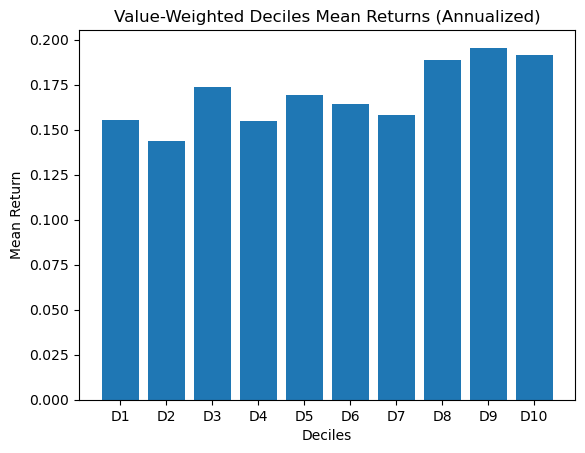

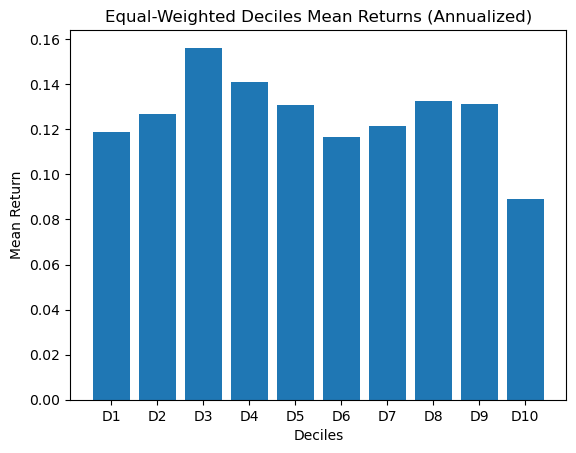

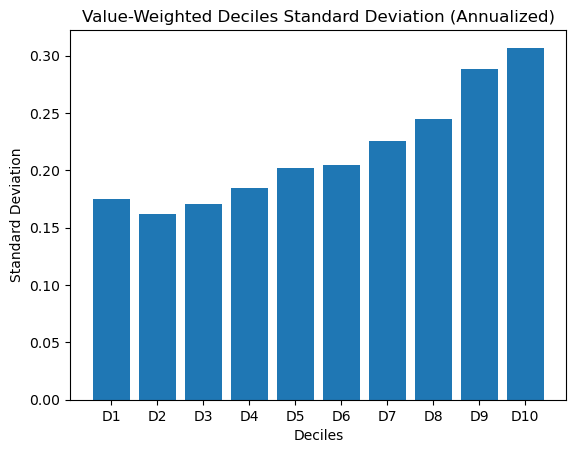

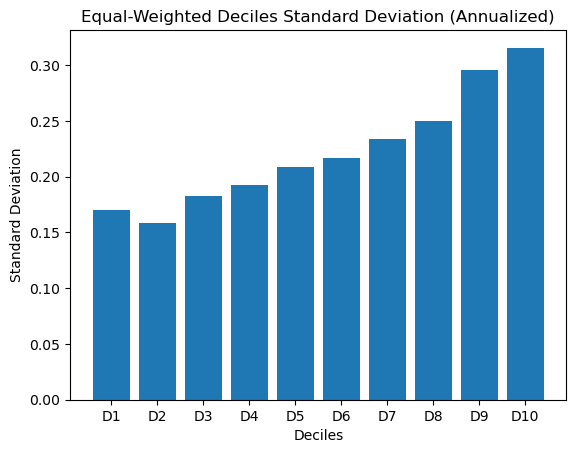

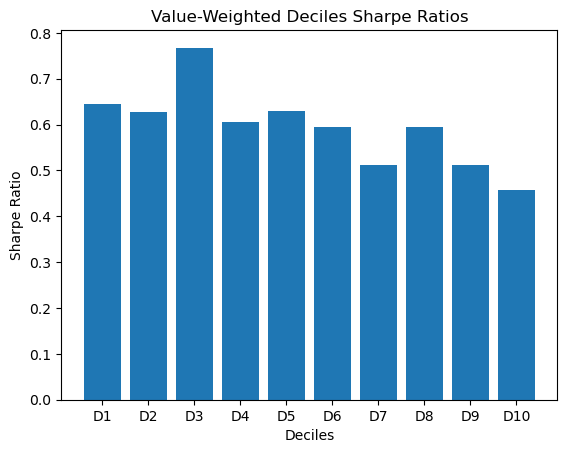

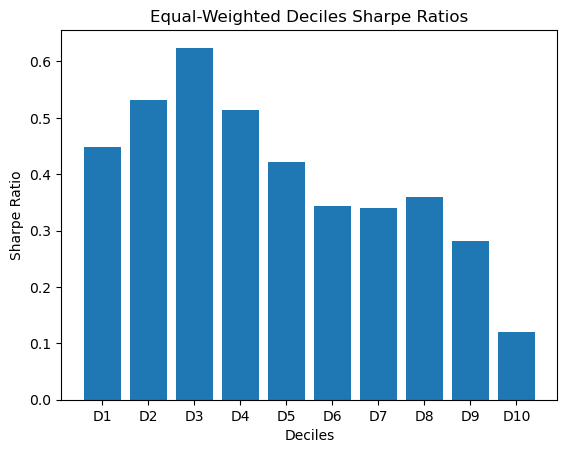

Mean: 0.11429756856779164
Standard Deviation: 0.23414856702303055
Sharpe ratio: 0.48814122597875853
Monthly CAPM Alpha: 0.07636973912542862


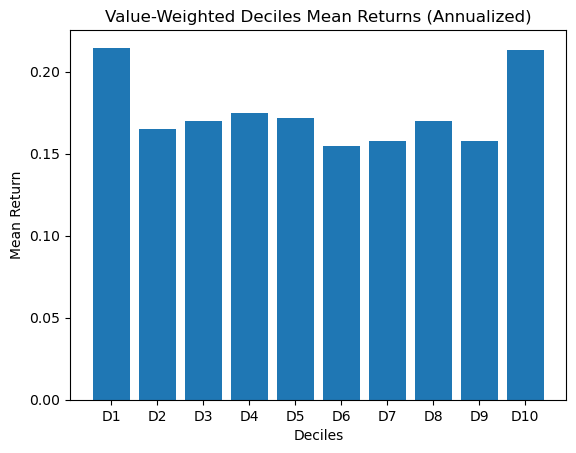

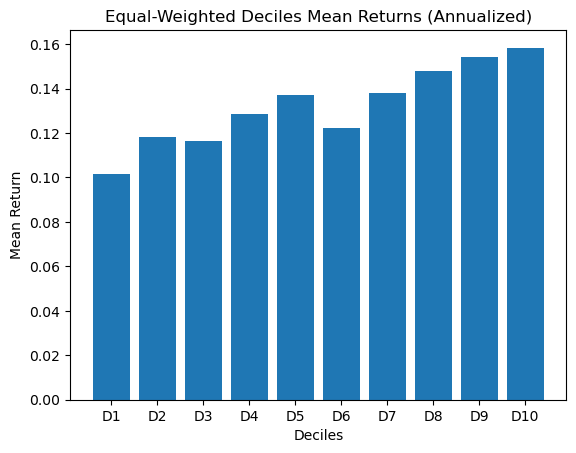

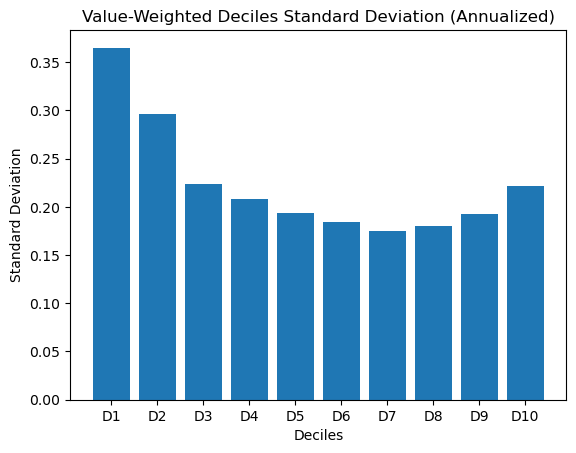

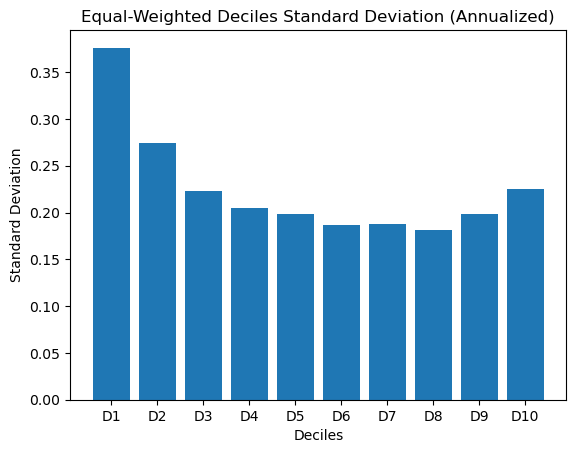

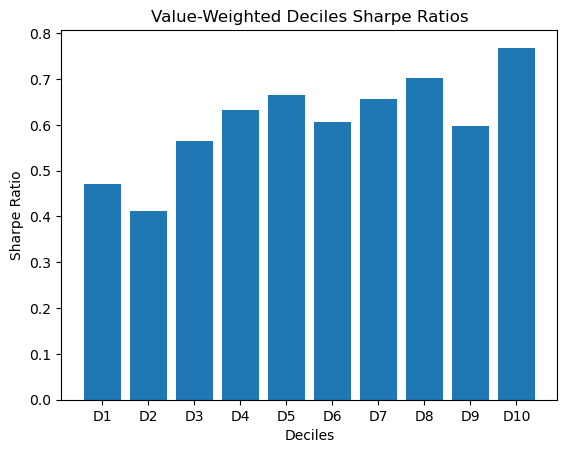

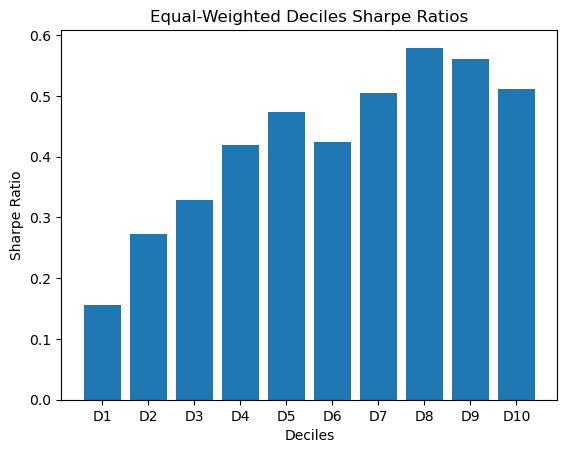

Long Leg Mean Return: 0.15367414895720702
Short Leg Mean Return: 0.11175737194979321
Long Leg Standard Deviation: 0.1830414294667986
Short Leg Standard Deviation: 0.2633242140777968
Long Leg Sharpe Ratio: 0.5498343473796037
Short Leg Sharpe Ratio: 0.2230166645044774
Factor Mean Return: 0.04191677700741378
Factor Standard Deviation: 0.19391266308582694
Factor Sharpe Ratio: -0.05731913975399692
T-Statistic: 5.595245064702343
P-Value: 1.101551772020315e-08
The factor strategy has an average return that is statistically significantly different from zero.
Long Leg Mean Return: 0.541075870495887
Short Leg Mean Return: 0.5496076829659722
Long Leg Standard Deviation: 0.5133370166648848
Short Leg Standard Deviation: 0.7715419340861851
Long Leg Sharpe Ratio: 0.9507286063720405
Short Leg Sharpe Ratio: 0.6436150479769025
Factor Mean Return: -0.00853181247008519
Factor Standard Deviation: 0.6669574102079544
Factor Sharpe Ratio: -0.09230498915034169
T-Statistic: -0.33111633034659416
P-Value: 0.62972

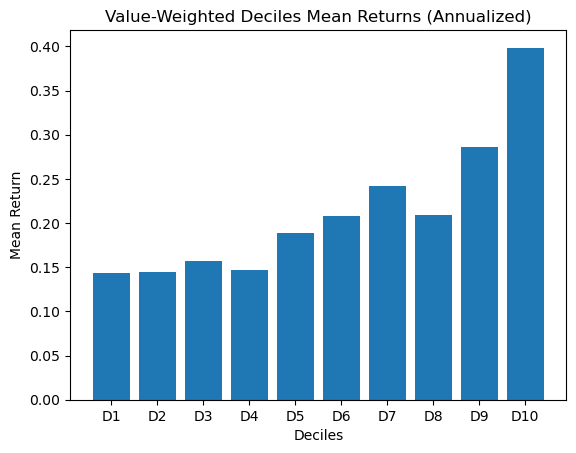

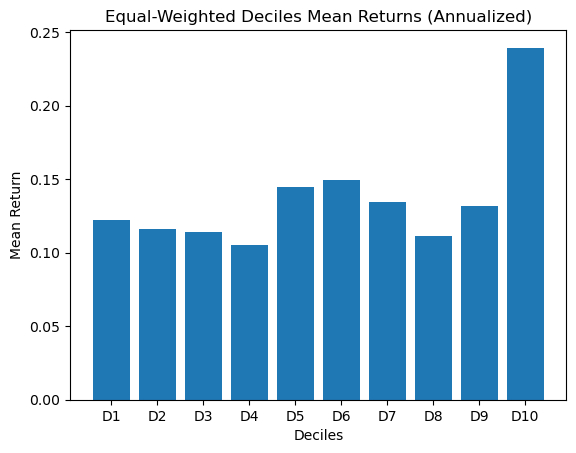

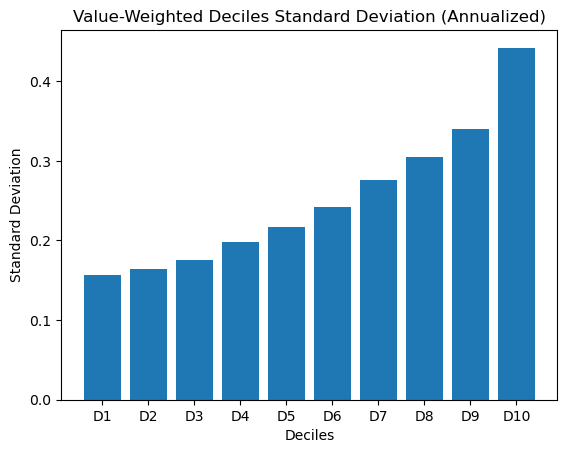

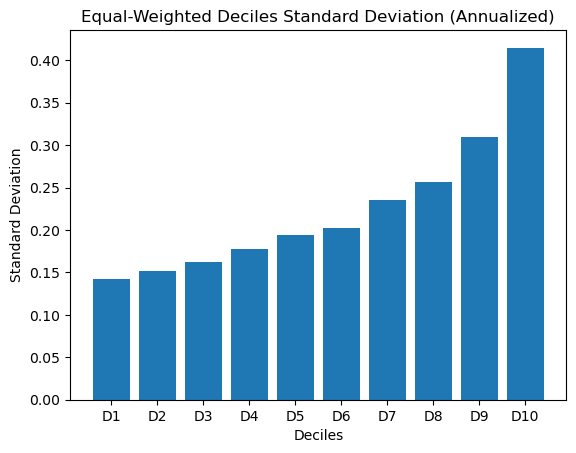

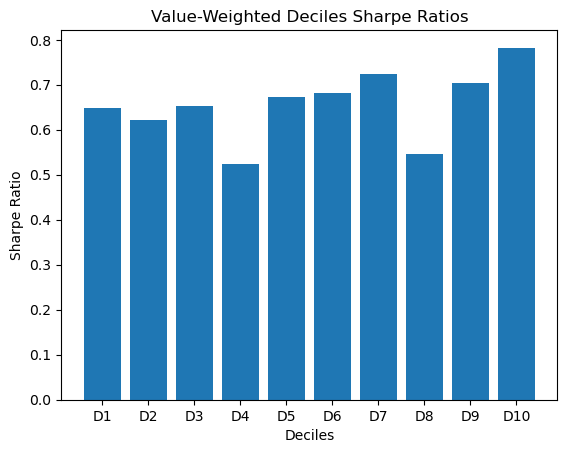

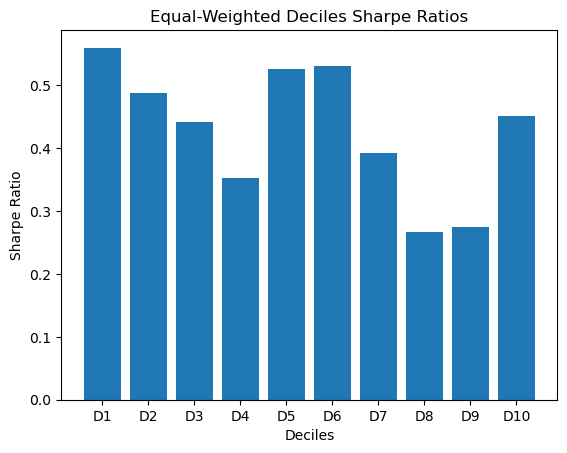

Long Leg Mean Return: 0.1439503802911704
Short Leg Mean Return: 0.118508245892663
Long Leg Standard Deviation: 0.2882775229638674
Short Leg Standard Deviation: 0.14104750684923997
Long Leg Sharpe Ratio: 0.2914212317455242
Short Leg Sharpe Ratio: 0.4150612115273732
Factor Mean Return: 0.026975588787937703
Factor Standard Deviation: 0.23179338645495184
Factor Sharpe Ratio: -0.14265349716660675
T-Statistic: 2.8766730010721577
P-Value: 0.0020094591341752732
The factor strategy has an average return that is statistically significantly different from zero.
Long Leg Mean Return: 0.7596607259687369
Short Leg Mean Return: 0.4444421115251302
Long Leg Standard Deviation: 0.8151550400487928
Short Leg Standard Deviation: 0.44474266357251757
Long Leg Sharpe Ratio: 0.8583895113527877
Short Leg Sharpe Ratio: 0.8644936638635236
Factor Mean Return: 0.02662372171505457
Factor Standard Deviation: 0.19390454575390204
Factor Sharpe Ratio: 0.11149942083879116
T-Statistic: 3.3939182706444635
P-Value: 0.000344

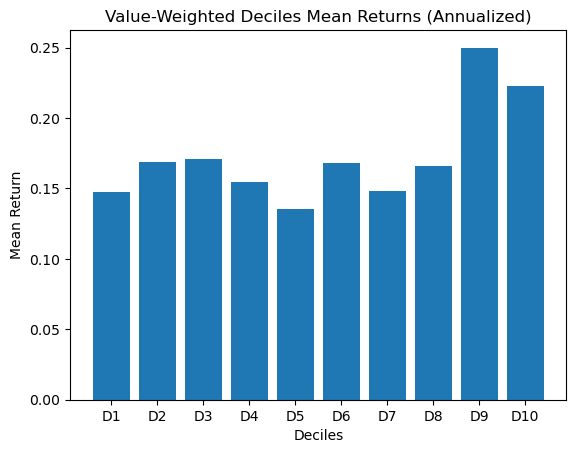

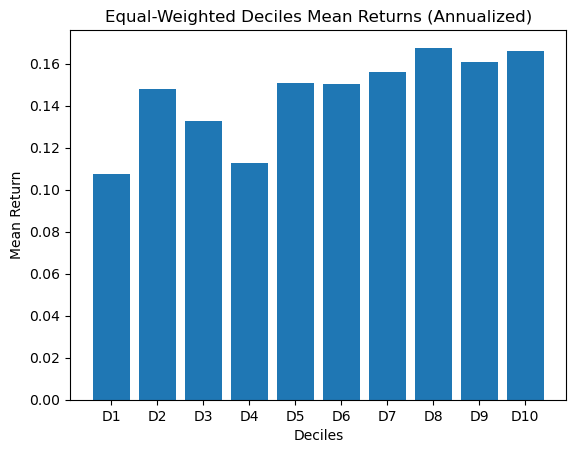

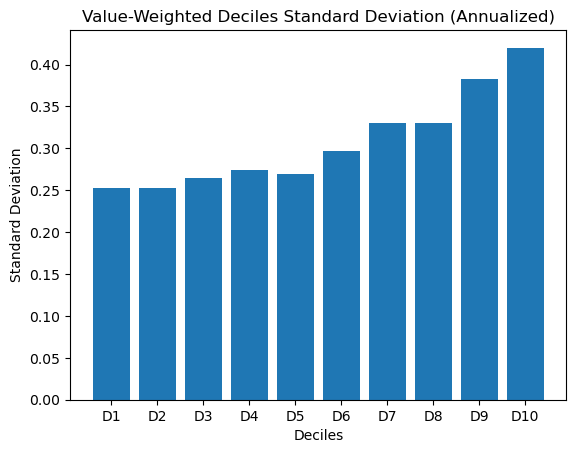

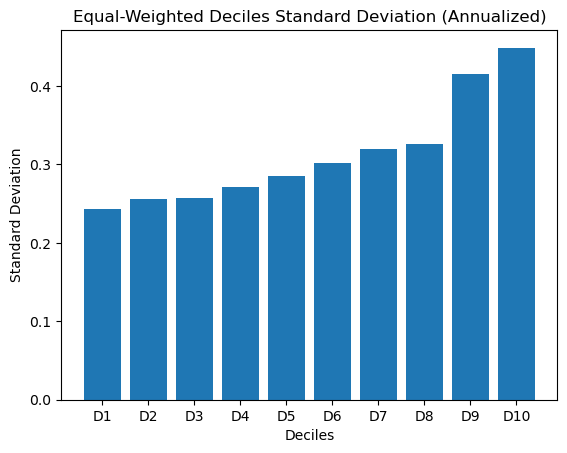

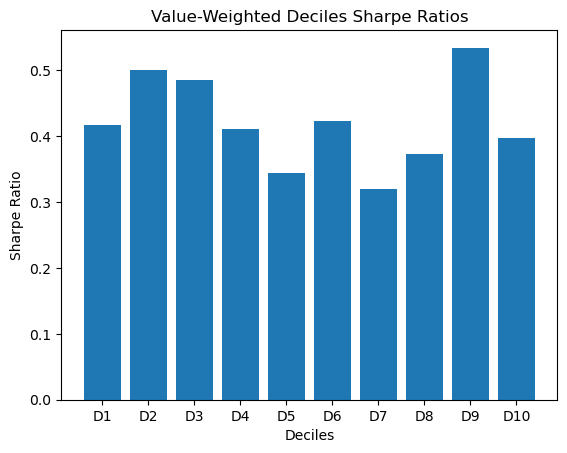

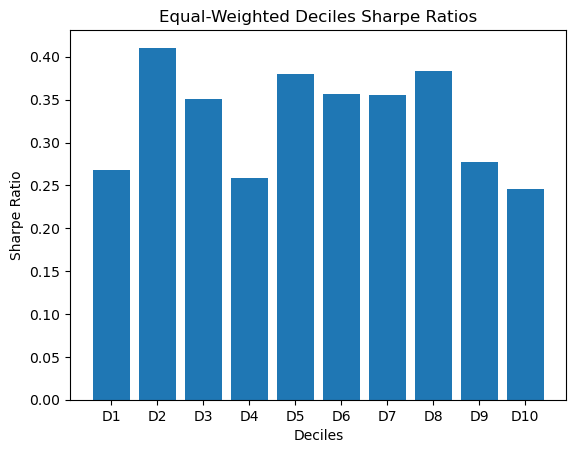

Mean: 0.029497096200540206
Standard Deviation: 0.1667716107128333
Sharpe ratio: 0.1768712077221088
Monthly CAPM Alpha: 0.0008546017558448543


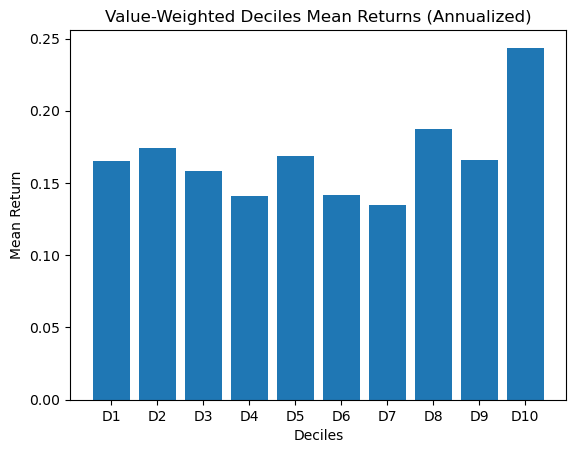

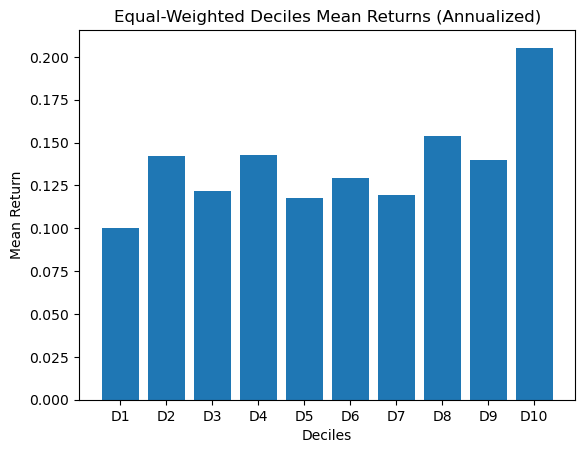

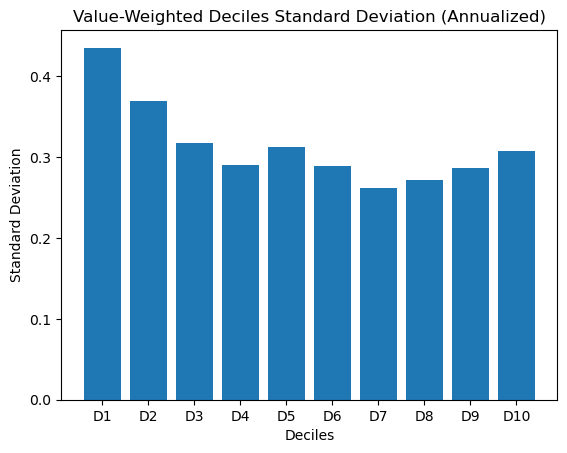

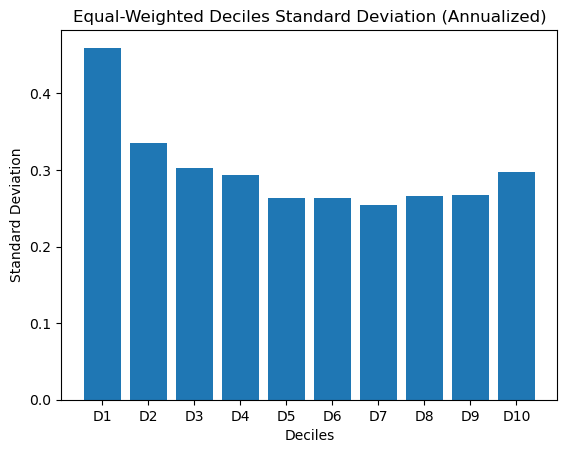

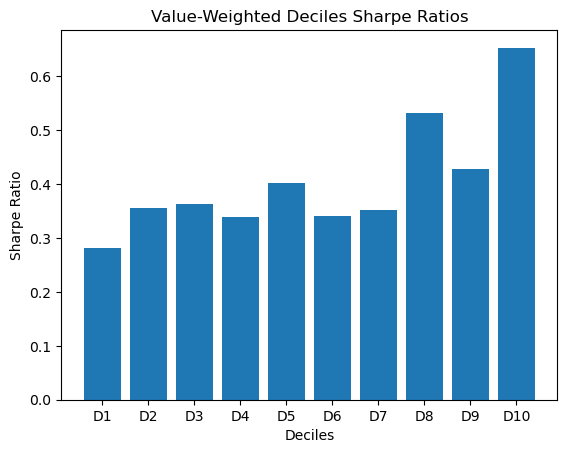

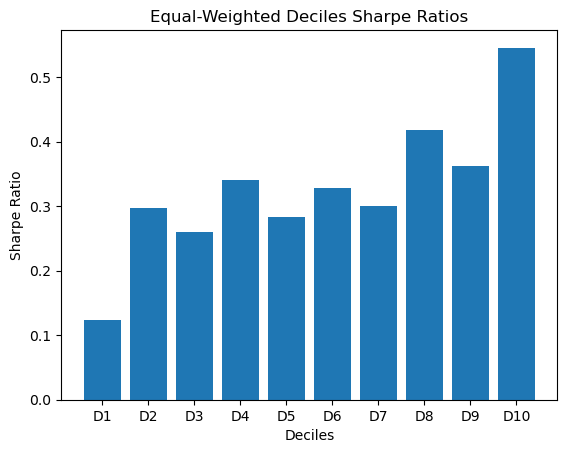

Long Leg Mean Return: 0.16580129978185085
Short Leg Mean Return: 0.1238237685815878
Long Leg Standard Deviation: 0.24726180857455055
Short Leg Standard Deviation: 0.3255744685674328
Long Leg Sharpe Ratio: 0.45568962098463767
Short Leg Sharpe Ratio: 0.2171457391733626
Factor Mean Return: 0.04197753120026307
Factor Standard Deviation: 0.21684717168147705
Factor Sharpe Ratio: -0.05141468372320575
T-Statistic: 5.010724585335282
P-Value: 2.7112736944445714e-07
The factor strategy has an average return that is statistically significantly different from zero.
Long Leg Mean Return: 0.5966967513443164
Short Leg Mean Return: 0.4976050867870119
Long Leg Standard Deviation: 0.7413247252543826
Short Leg Standard Deviation: 0.955120114653313
Long Leg Sharpe Ratio: 0.7332415510750092
Short Leg Sharpe Ratio: 0.46536390556470436
Factor Mean Return: 0.09909166455730448
Factor Standard Deviation: 0.7020695319467305
Factor Sharpe Ratio: 0.06547072977417595
T-Statistic: 3.653376231870166
P-Value: 0.0001294

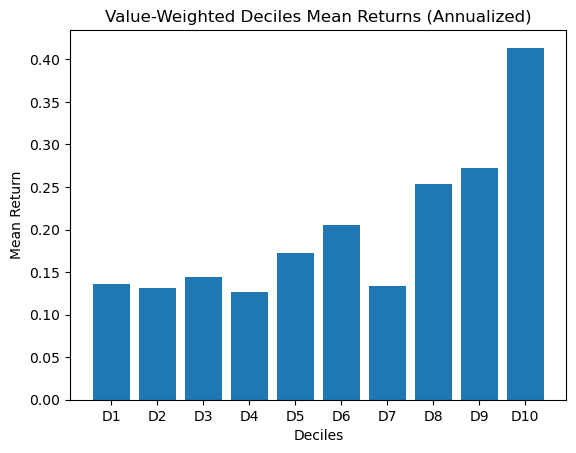

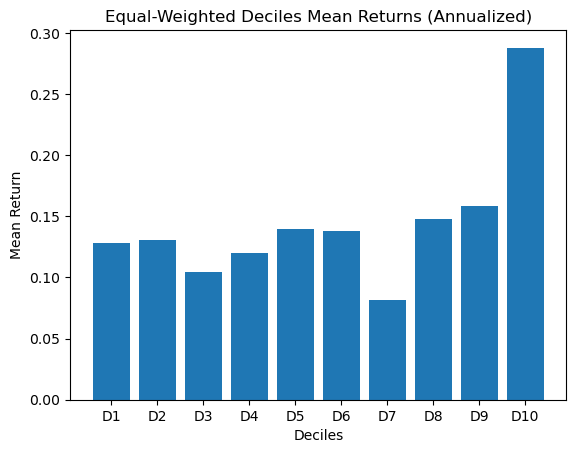

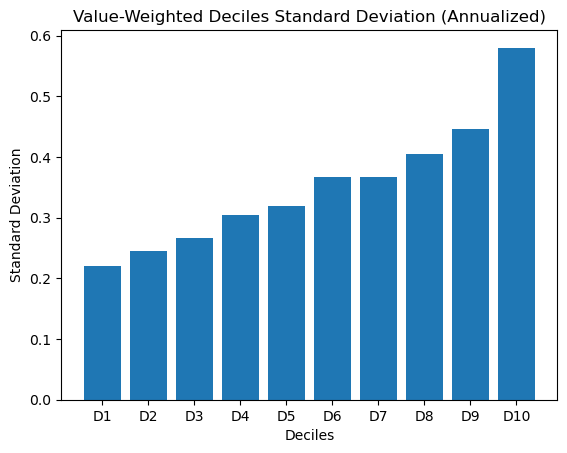

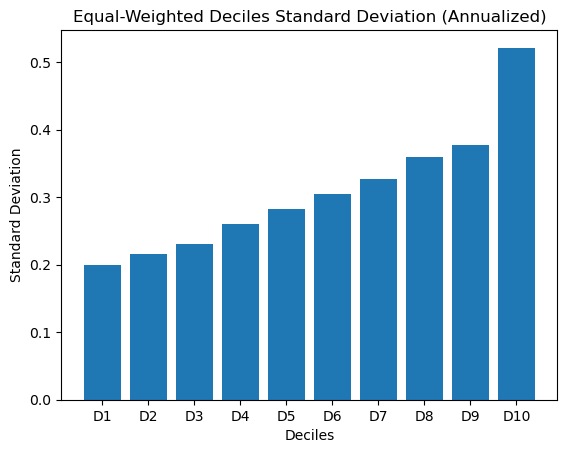

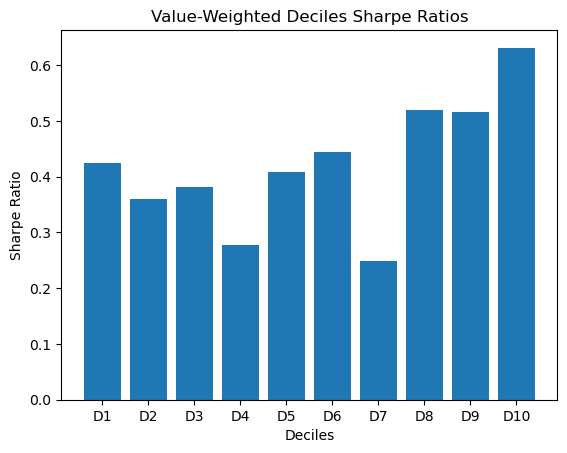

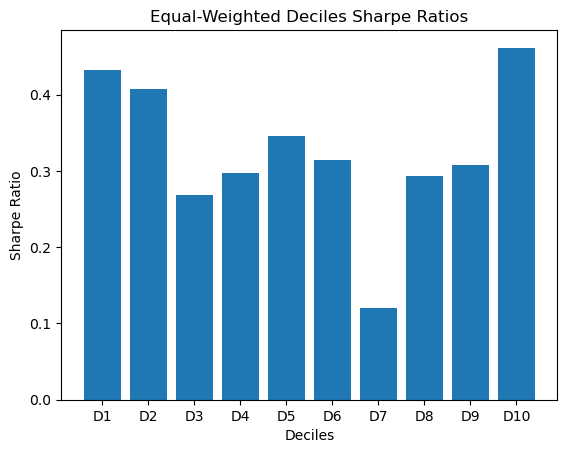

Long Leg Mean Return: 0.20314157147205147
Short Leg Mean Return: 0.12058892226991959
Long Leg Standard Deviation: 0.35395982725435615
Short Leg Standard Deviation: 0.1963490451025938
Long Leg Sharpe Ratio: 0.40443796275997207
Short Leg Sharpe Ratio: 0.3086449552114016
Factor Mean Return: 0.08255264920213189
Factor Standard Deviation: 0.2577123953289623
Factor Sharpe Ratio: 0.08756221886378107
T-Statistic: 7.911532650882478
P-Value: 1.2212453270876722e-15
The factor strategy has an average return that is statistically significantly different from zero.
Long Leg Mean Return: 0.8768969653828356
Short Leg Mean Return: 0.4109271905988937
Long Leg Standard Deviation: 1.0670092745631132
Short Leg Standard Deviation: 0.6380626321636532
Long Leg Sharpe Ratio: 0.7656073895692156
Short Leg Sharpe Ratio: 0.5500093452745168
Factor Mean Return: 0.03883081456532848
Factor Standard Deviation: 0.23966102893752023
Factor Sharpe Ratio: 0.14116569714641763
T-Statistic: 4.0016951316911875
P-Value: 3.144514

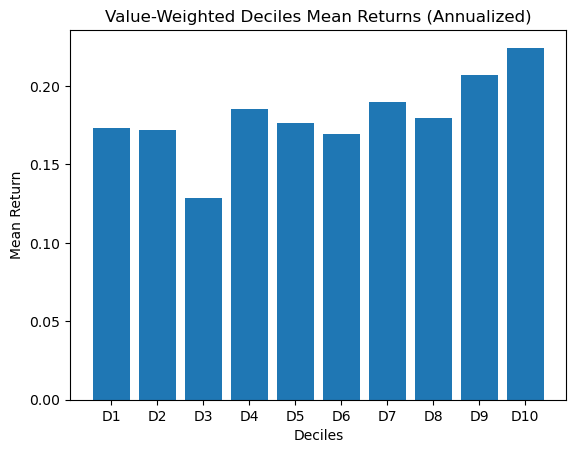

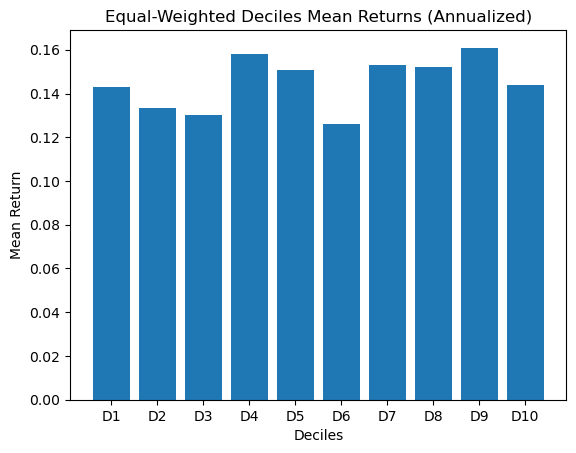

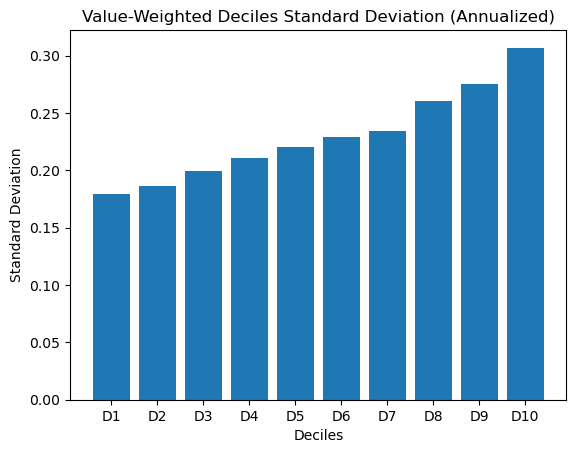

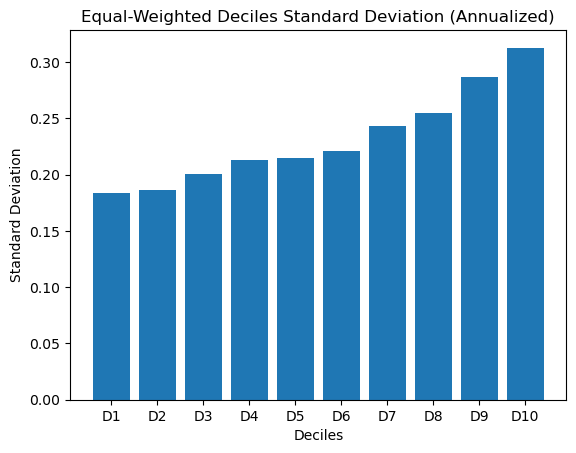

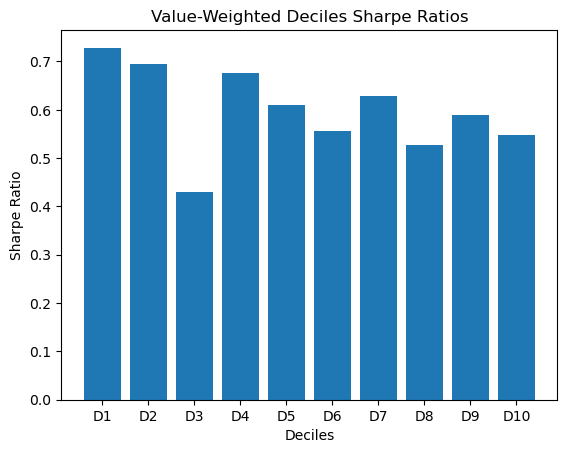

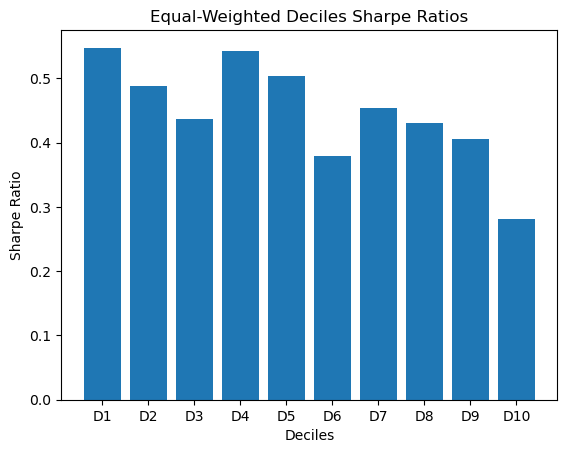

Mean: 0.06302557285854167
Standard Deviation: 0.13421043532021845
Sharpe ratio: 0.46960262596694685
Monthly CAPM Alpha: 0.03437622087074785


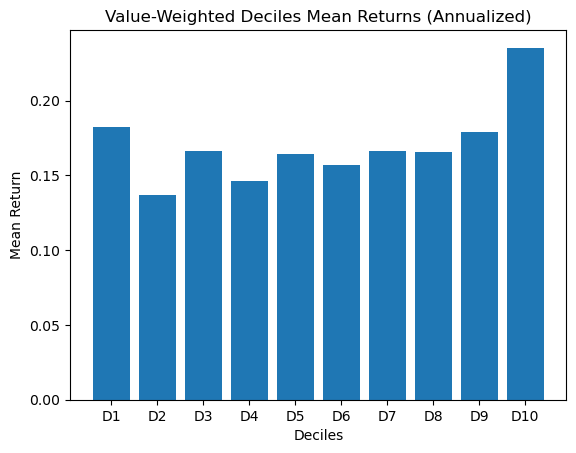

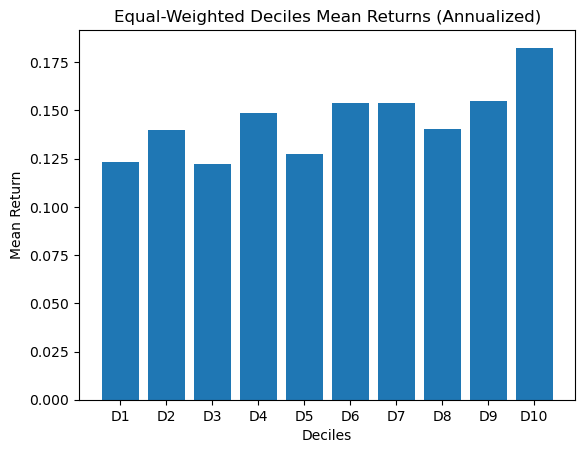

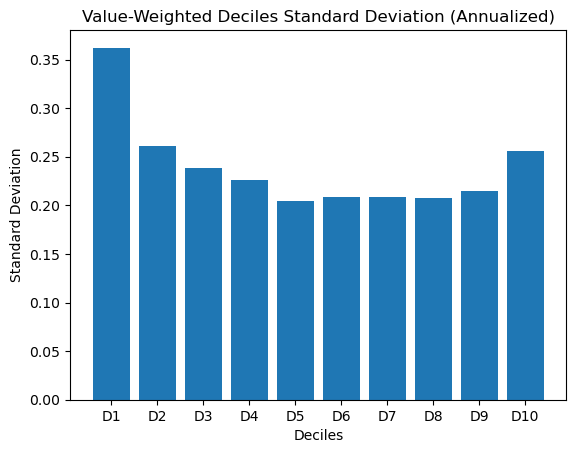

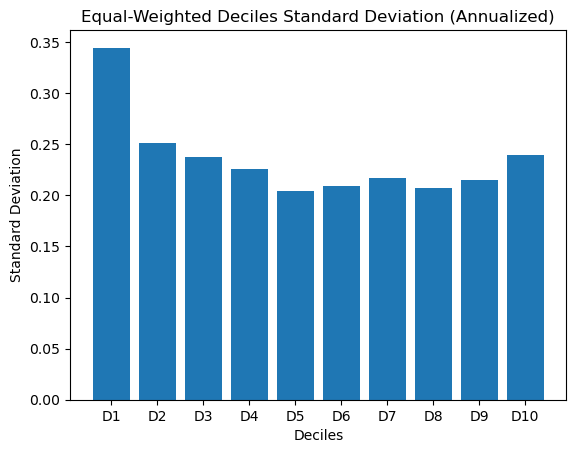

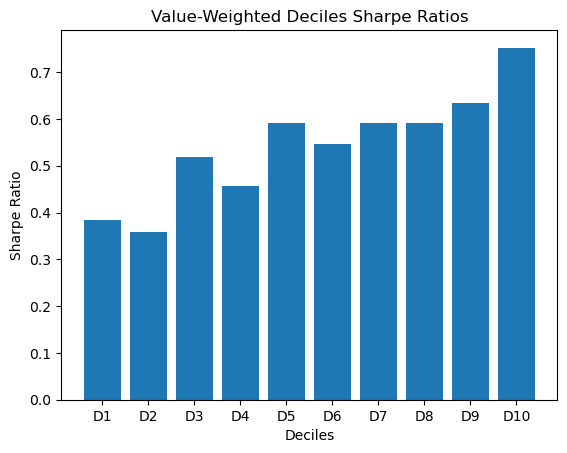

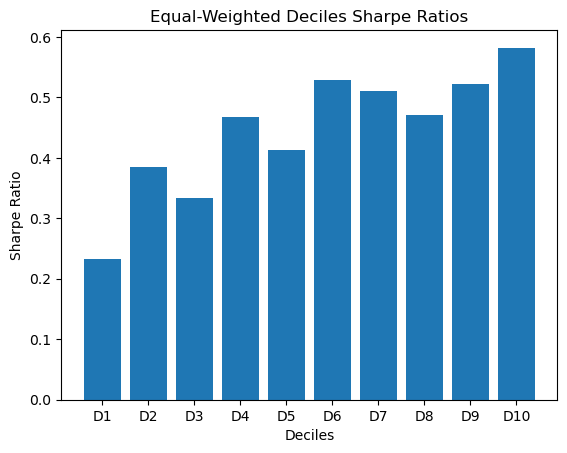

Long Leg Mean Return: 0.1595449264318735
Short Leg Mean Return: 0.12845751194380706
Long Leg Standard Deviation: 0.21083178599500277
Short Leg Standard Deviation: 0.2637805408168777
Long Leg Sharpe Ratio: 0.5052048574473402
Short Leg Sharpe Ratio: 0.28594159245912415
Factor Mean Return: 0.03108741448806647
Factor Standard Deviation: 0.14983765311383648
Factor Sharpe Ratio: -0.1464536389805957
T-Statistic: 5.370330859723147
P-Value: 3.929615799425079e-08
The factor strategy has an average return that is statistically significantly different from zero.
Long Leg Mean Return: 0.580002366603538
Short Leg Mean Return: 0.4858215285269874
Long Leg Standard Deviation: 0.6173353797123284
Short Leg Standard Deviation: 0.7769609146300376
Long Leg Sharpe Ratio: 0.8536213861680835
Short Leg Sharpe Ratio: 0.5570291070435212
Factor Mean Return: 0.0941808380765506
Factor Standard Deviation: 0.5514771623977037
Factor Sharpe Ratio: 0.07461624313642094
T-Statistic: 4.420510432009524
P-Value: 4.92340158331

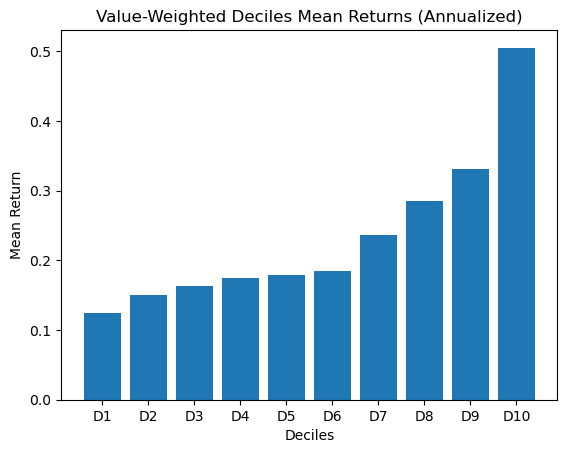

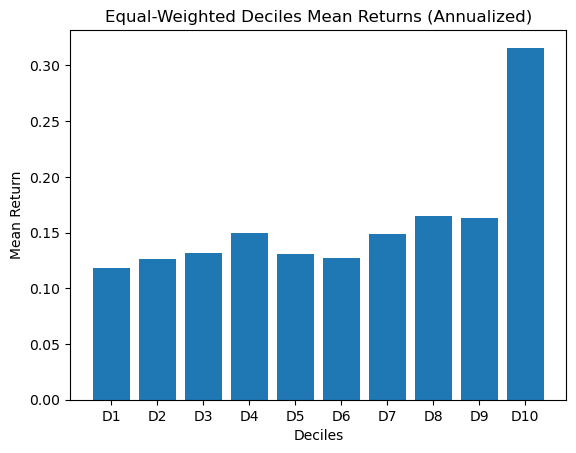

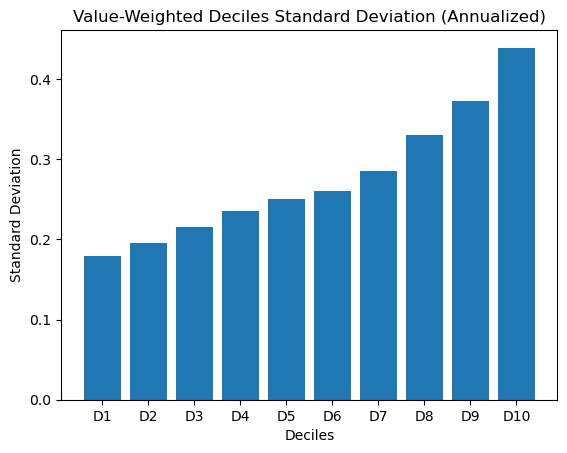

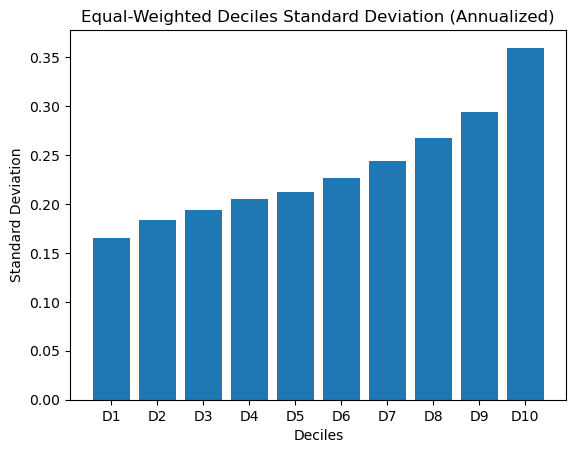

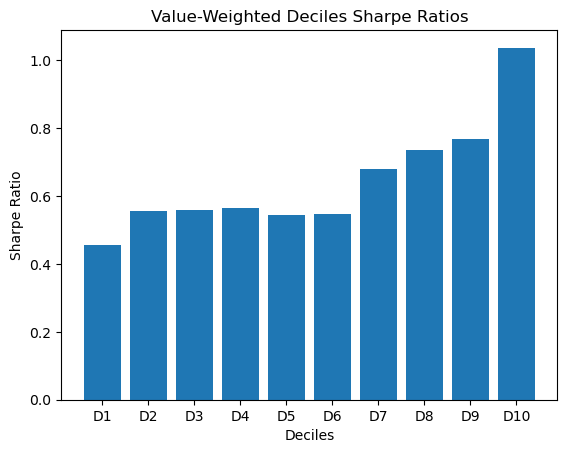

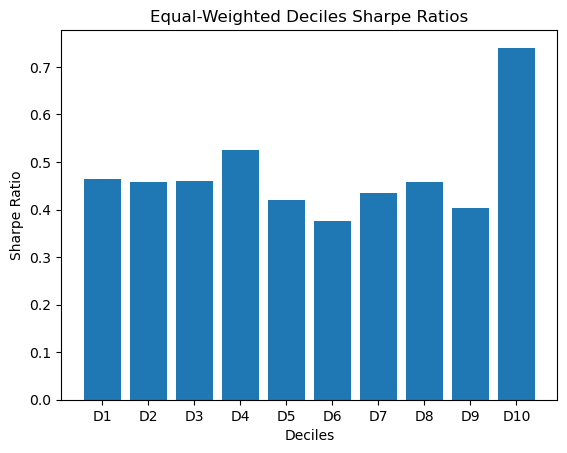

Long Leg Mean Return: 0.19758629255929872
Short Leg Mean Return: 0.12544133976119307
Long Leg Standard Deviation: 0.29003766806936315
Short Leg Standard Deviation: 0.1752638062302039
Long Leg Sharpe Ratio: 0.47449490494967106
Short Leg Sharpe Ratio: 0.37358793211582814
Factor Mean Return: 0.07214495279810564
Factor Standard Deviation: 0.18244340324830968
Factor Sharpe Ratio: 0.06676073655908692
T-Statistic: 9.774586491651009
P-Value: 0.0
The factor strategy has an average return that is statistically significantly different from zero.
Long Leg Mean Return: 0.991921057643488
Short Leg Mean Return: 0.43753447897426645
Long Leg Standard Deviation: 0.910383468508444
Short Leg Standard Deviation: 0.5538789088660094
Long Leg Sharpe Ratio: 1.0236962698295549
Short Leg Sharpe Ratio: 0.6816825412803423
Factor Mean Return: 0.04619888155576848
Factor Standard Deviation: 0.18424950869832055
Factor Sharpe Ratio: 0.22361962923053488
T-Statistic: 6.197916604576173
P-Value: 2.8607716195949706e-10
The 

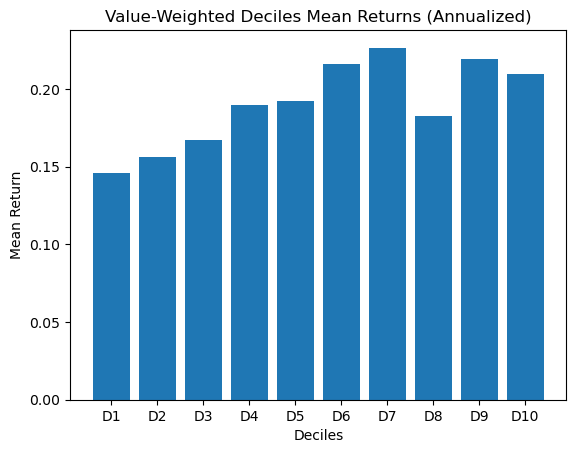

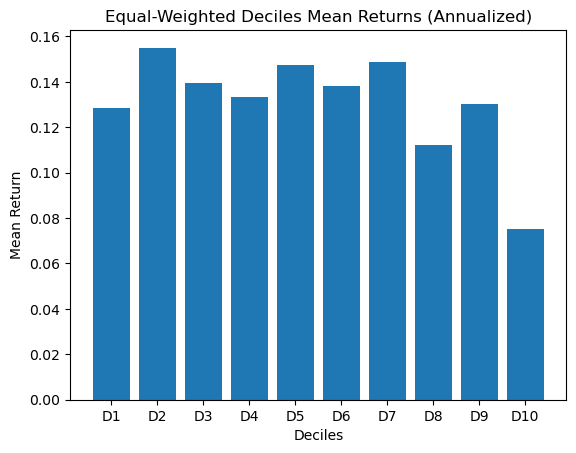

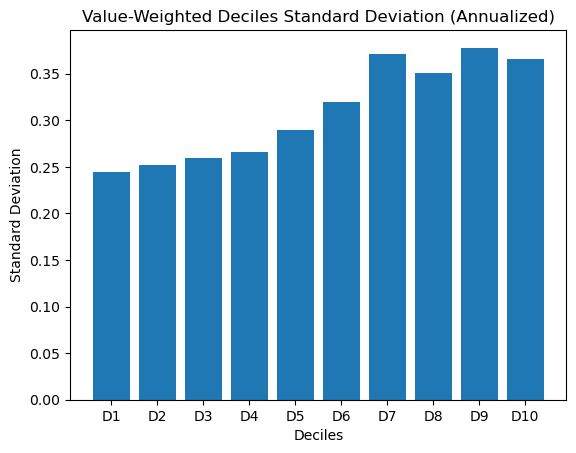

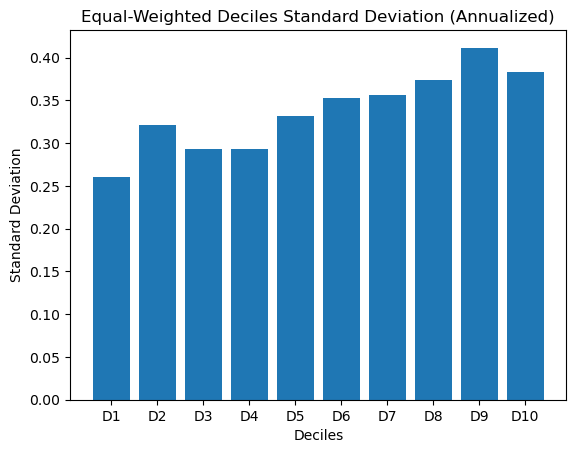

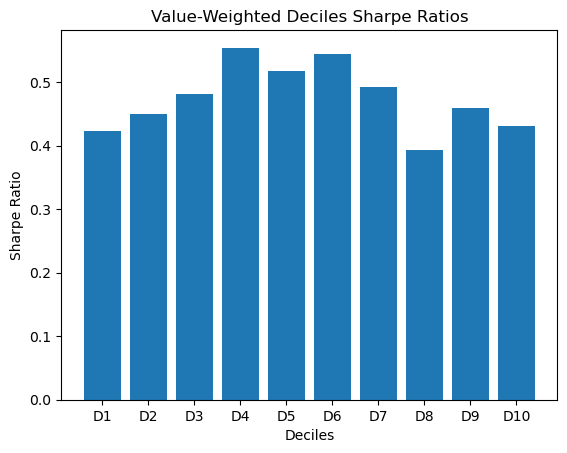

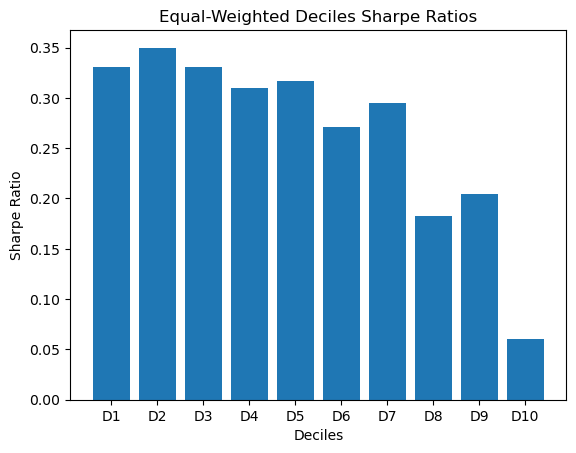

Mean: 0.11188522215081115
Standard Deviation: 0.22616122730203764
Sharpe ratio: 0.4947144277802701
Monthly CAPM Alpha: 0.07737038717608417


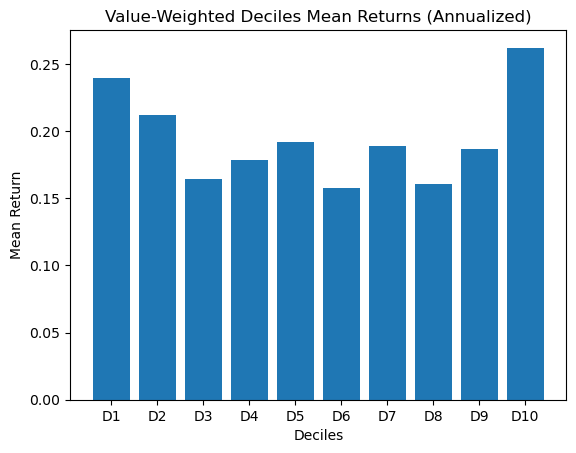

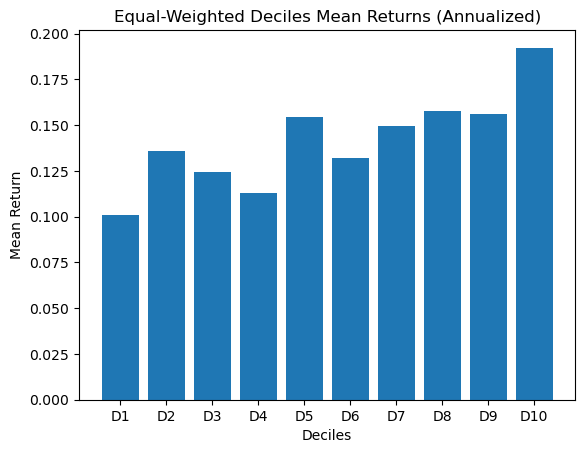

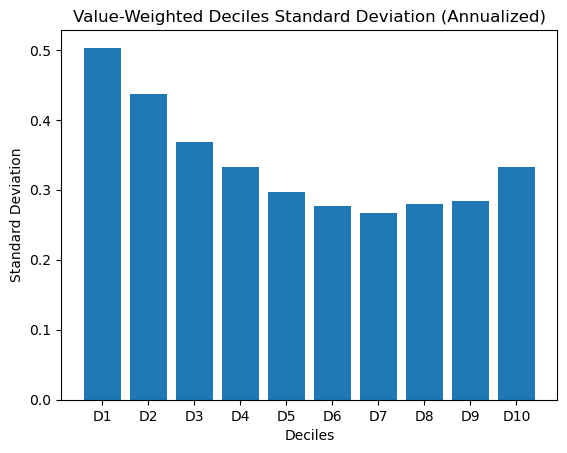

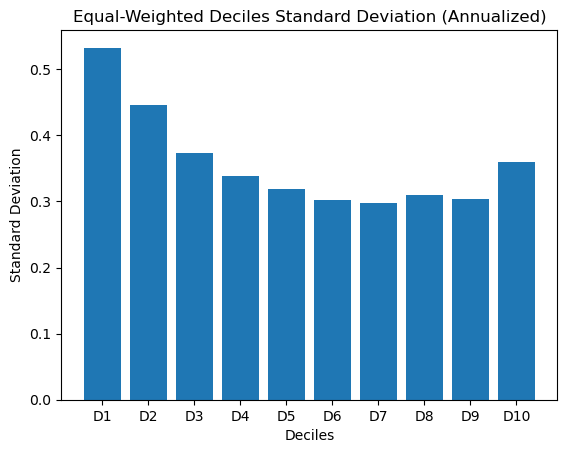

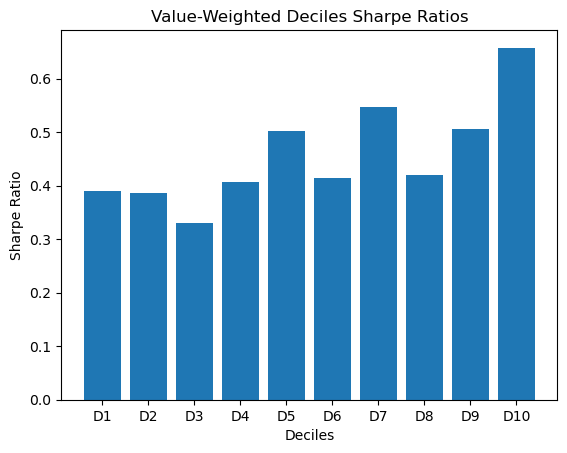

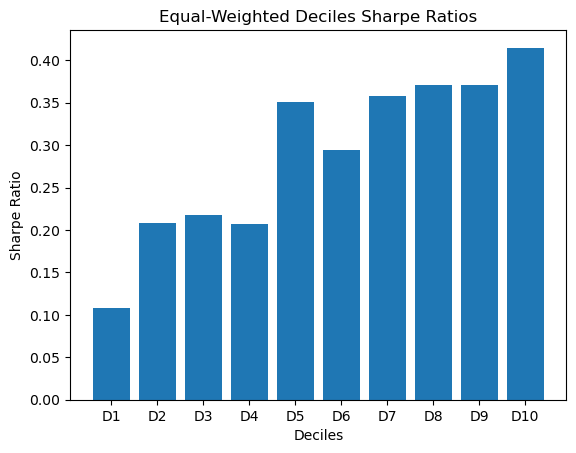

Long Leg Mean Return: 0.16867421939172994
Short Leg Mean Return: 0.12080037764181863
Long Leg Standard Deviation: 0.30051913663891944
Short Leg Standard Deviation: 0.4106430471343552
Long Leg Sharpe Ratio: 0.3843878366613782
Short Leg Sharpe Ratio: 0.16472228016547127
Factor Mean Return: 0.0478738417499113
Factor Standard Deviation: 0.27940749664396
Factor Sharpe Ratio: -0.018913153359564575
T-Statistic: 4.435040876425629
P-Value: 4.602741018433498e-06
The factor strategy has an average return that is statistically significantly different from zero.
Long Leg Mean Return: 0.6092375811501038
Short Leg Mean Return: 0.6159522155471315
Long Leg Standard Deviation: 0.8250516522129293
Short Leg Standard Deviation: 1.1679647978087384
Long Leg Sharpe Ratio: 0.6739932719058908
Short Leg Sharpe Ratio: 0.48185861253631906
Factor Mean Return: -0.006714634397027611
Factor Standard Deviation: 0.8705085127913486
Factor Sharpe Ratio: -0.06877928486740603
T-Statistic: -0.19965801532698513
P-Value: 0.579

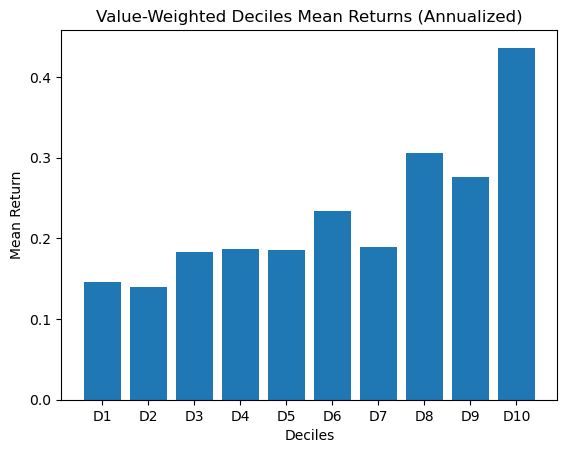

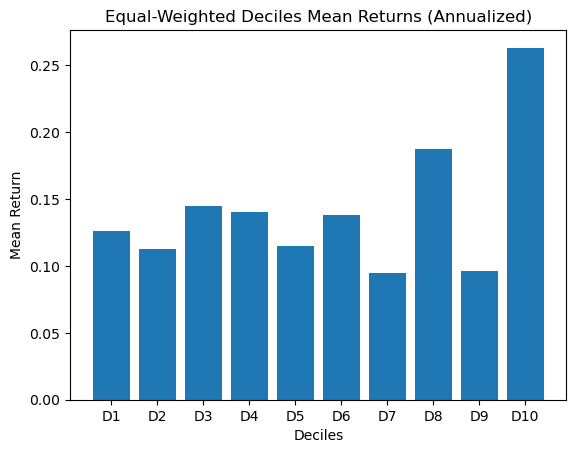

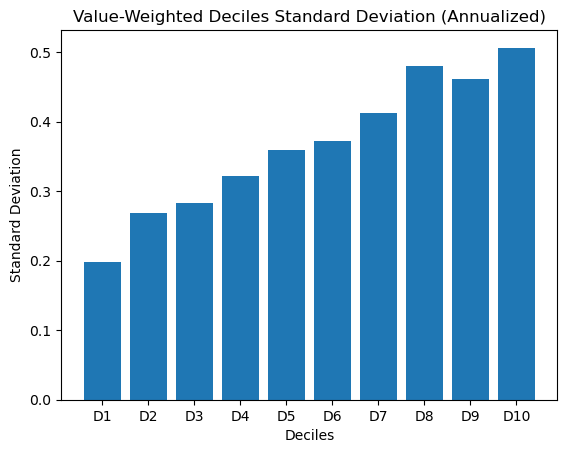

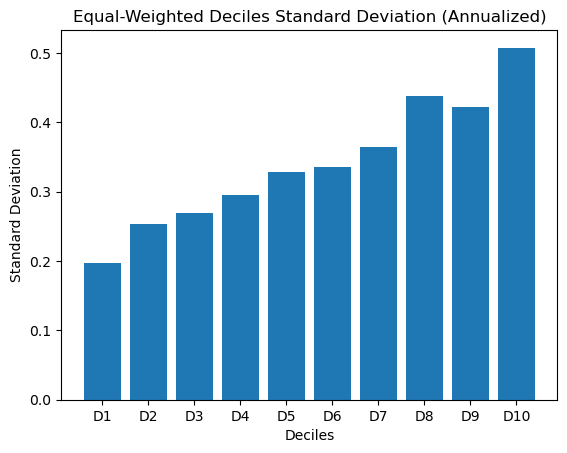

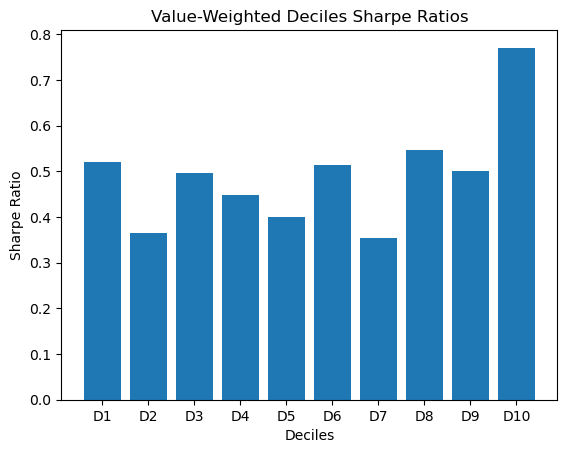

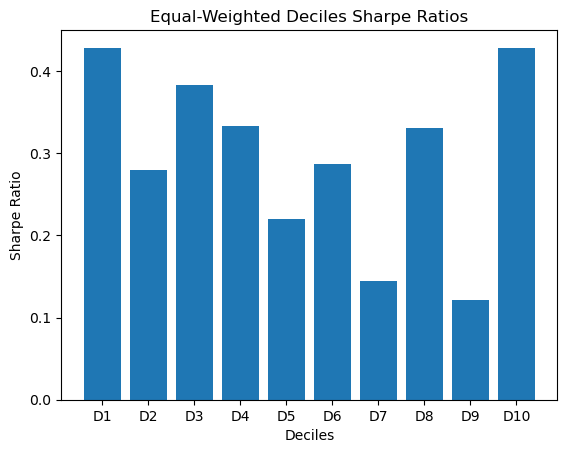

Long Leg Mean Return: 0.20004952056670094
Short Leg Mean Return: 0.1285973652666342
Long Leg Standard Deviation: 0.4469099493484886
Short Leg Standard Deviation: 0.22529910563248076
Long Leg Sharpe Ratio: 0.31345773490753
Short Leg Sharpe Ratio: 0.30453110337742406
Factor Mean Return: 0.07076389814059406
Factor Standard Deviation: 0.30554064237289247
Factor Sharpe Ratio: 0.03528186249986192
T-Statistic: 5.720153442313793
P-Value: 5.3213947692754004e-09
The factor strategy has an average return that is statistically significantly different from zero.
Long Leg Mean Return: 0.8951545160139095
Short Leg Mean Return: 0.46802818791873907
Long Leg Standard Deviation: 1.11215956762859
Short Leg Standard Deviation: 0.7014637691603367
Long Leg Sharpe Ratio: 0.7509645200090033
Short Leg Sharpe Ratio: 0.5816999049982909
Factor Mean Return: 0.03544535891923246
Factor Standard Deviation: 0.21897909843804236
Factor Sharpe Ratio: 0.13903931715728338
T-Statistic: 3.9978052362205556
P-Value: 3.196626042

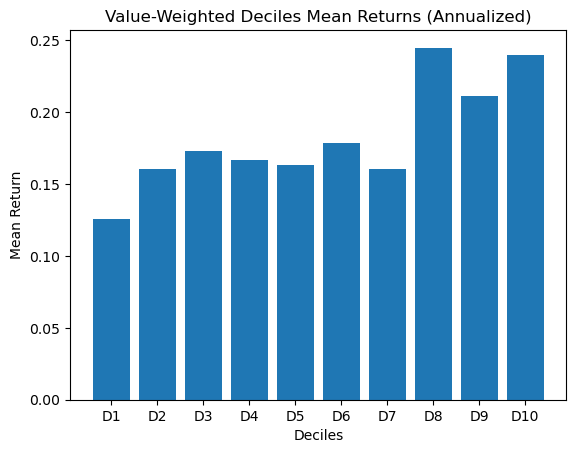

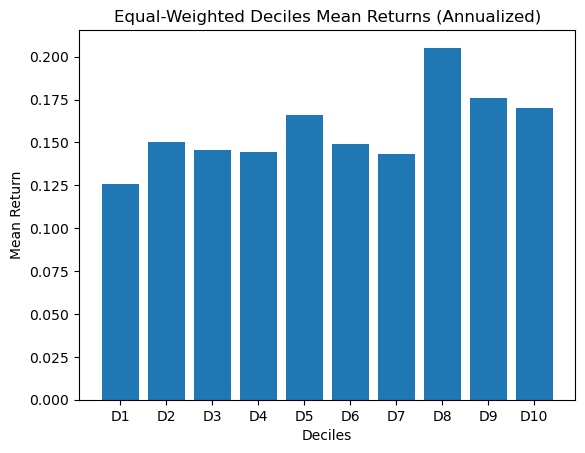

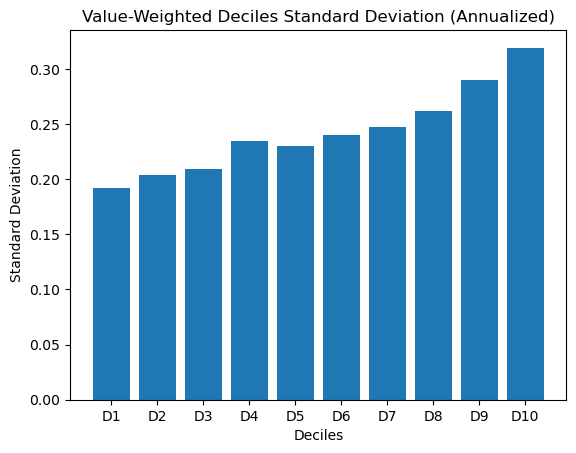

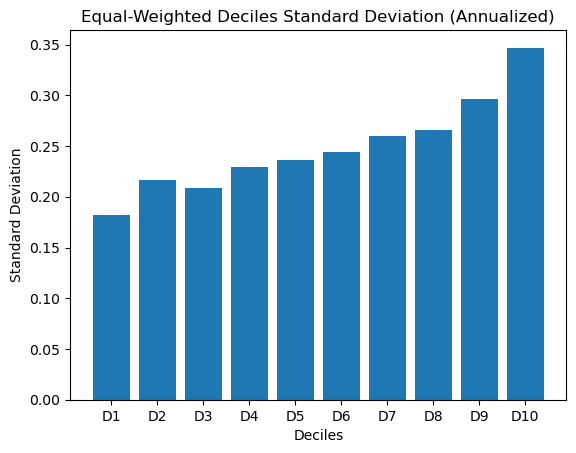

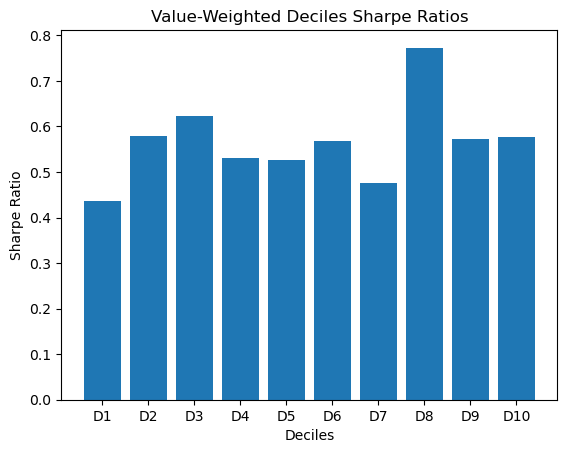

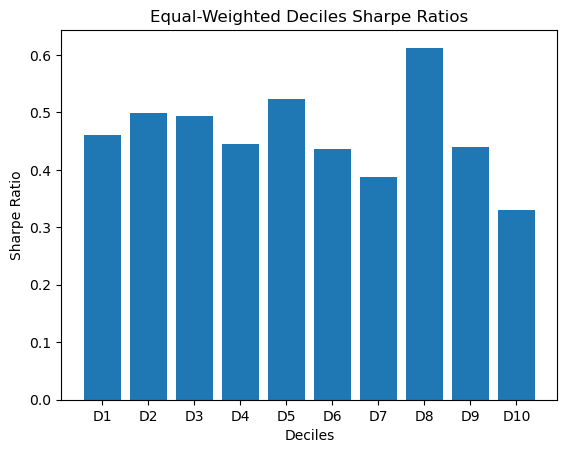

Mean: 0.07438861739940023
Standard Deviation: 0.176415179977813
Sharpe ratio: 0.4216678939349537
Monthly CAPM Alpha: 0.040476570529744384


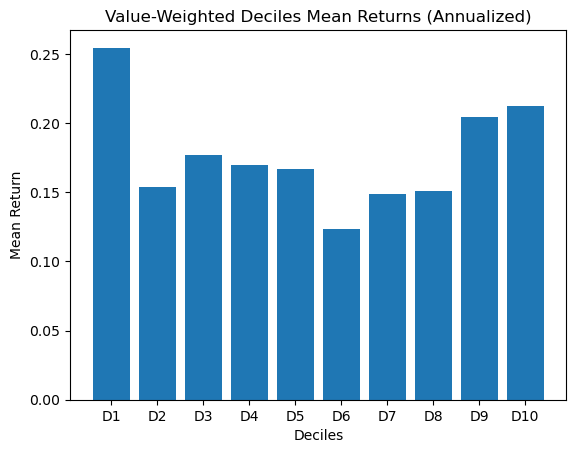

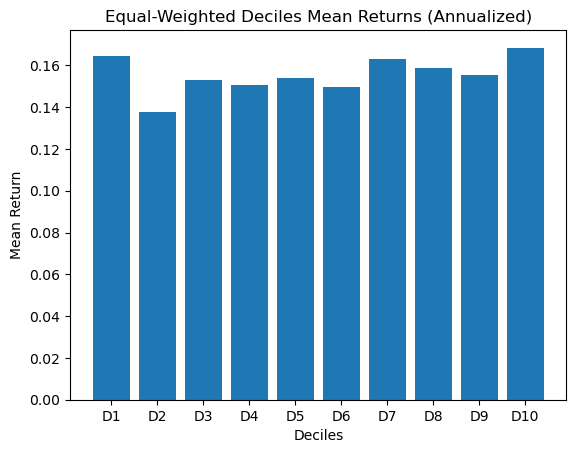

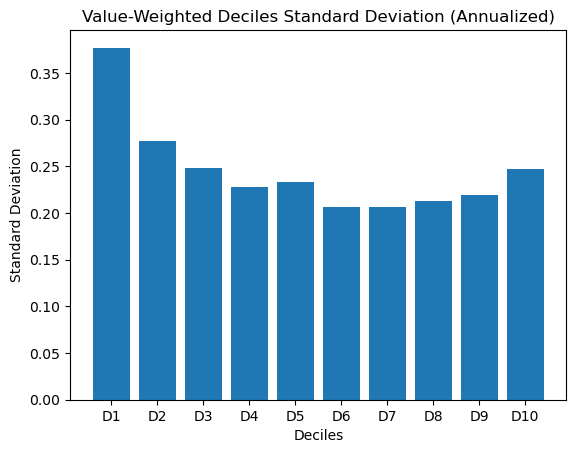

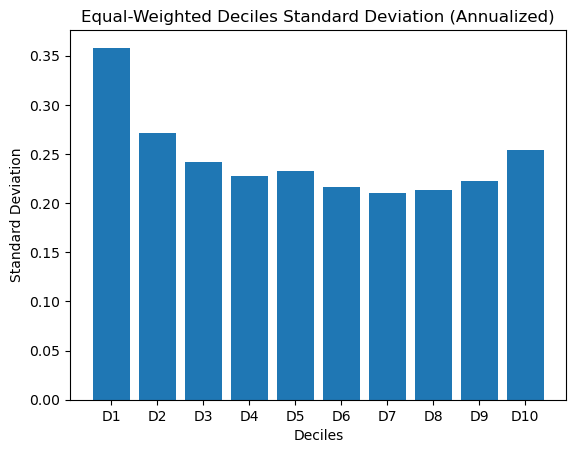

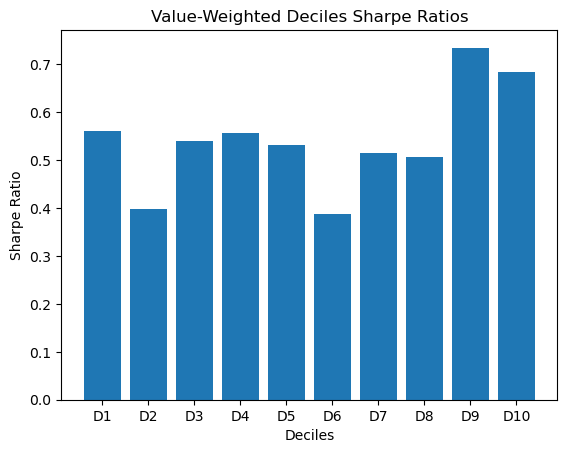

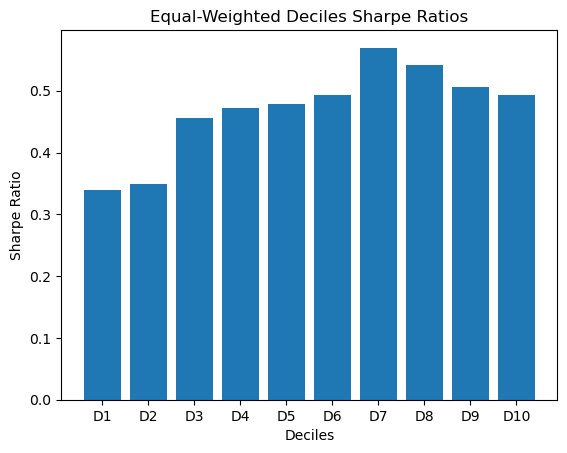

Long Leg Mean Return: 0.15903452284903719
Short Leg Mean Return: 0.15363181574380083
Long Leg Standard Deviation: 0.20268309739779902
Short Leg Standard Deviation: 0.2566399849168587
Long Leg Sharpe Ratio: 0.5217384785354089
Short Leg Sharpe Ratio: 0.39099466043236863
Factor Mean Return: 0.005402707105236373
Factor Standard Deviation: 0.18394340095138437
Factor Sharpe Ratio: -0.26032053683341816
T-Statistic: 0.7602643274954876
P-Value: 0.2235483001786298
The factor strategy does not have an average return that is statistically significantly different from zero.
Long Leg Mean Return: 0.5671776663707931
Short Leg Mean Return: 0.5847358009531123
Long Leg Standard Deviation: 0.5754639662525728
Short Leg Standard Deviation: 0.7717951286382092
Long Leg Sharpe Ratio: 0.8930024198202875
Short Leg Sharpe Ratio: 0.6885879804695836
Factor Mean Return: -0.017558134582319168
Factor Standard Deviation: 0.6348052600354558
Factor Sharpe Ratio: -0.11160129102620807
T-Statistic: -0.7159377428943874
P-Va

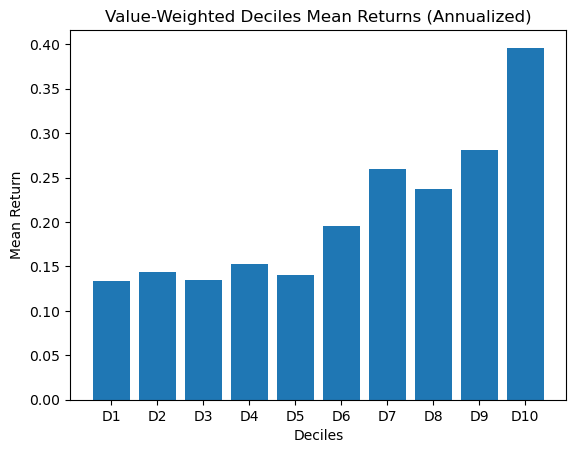

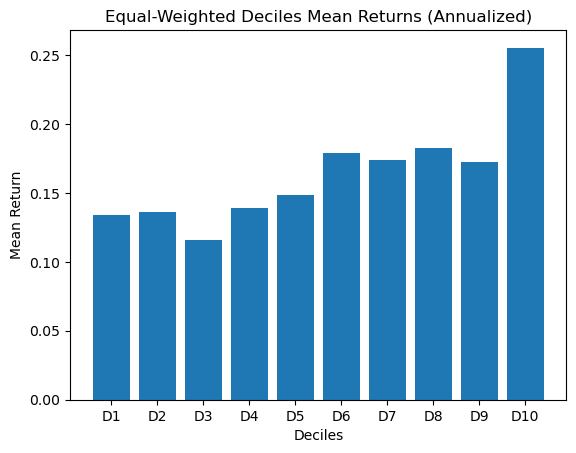

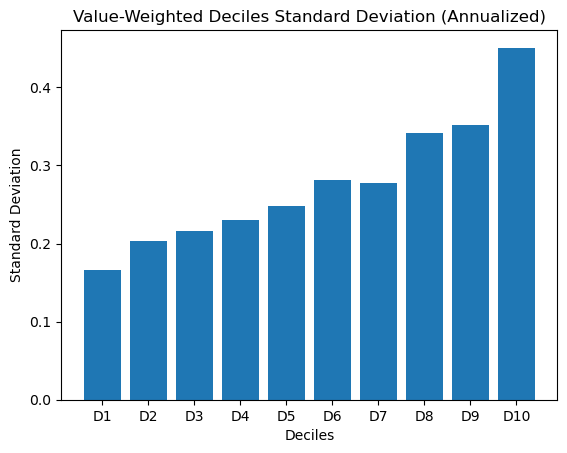

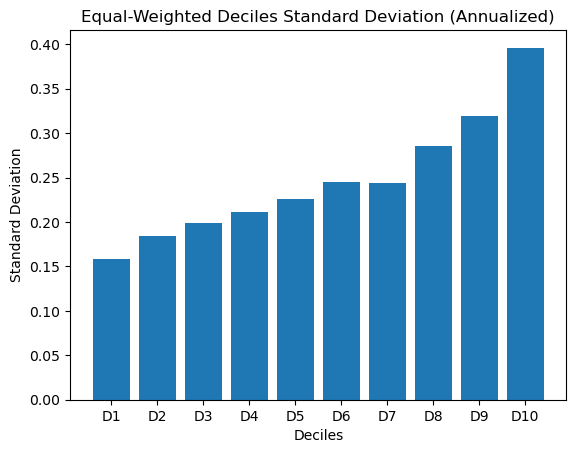

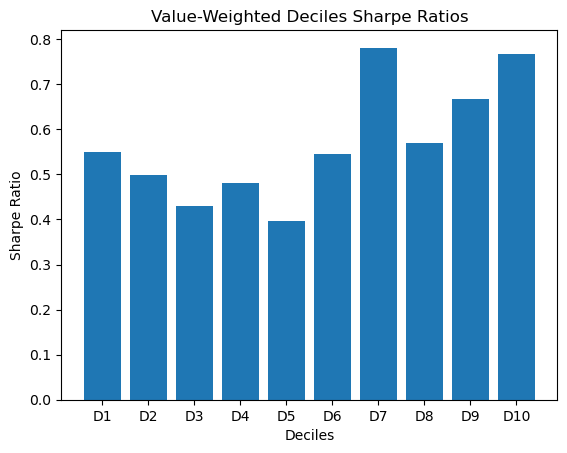

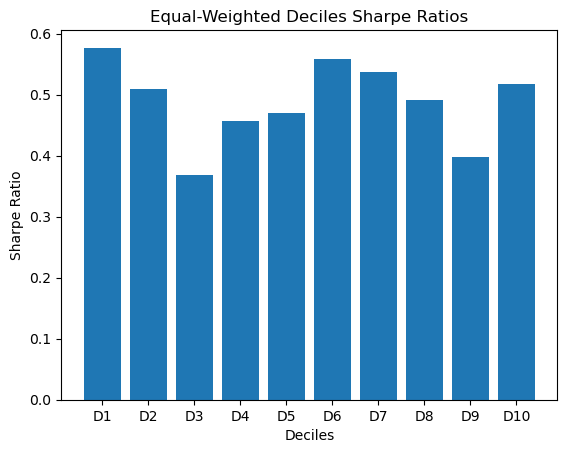

Long Leg Mean Return: 0.19128278000450777
Short Leg Mean Return: 0.12994441753519112
Long Leg Standard Deviation: 0.2908937794735371
Short Leg Standard Deviation: 0.1645788643646266
Long Leg Sharpe Ratio: 0.45131459242984223
Short Leg Sharpe Ratio: 0.425001383526334
Factor Mean Return: 0.06133836246931666
Factor Standard Deviation: 0.21878814920377207
Factor Sharpe Ratio: 0.006125514536148456
T-Statistic: 6.924258943323503
P-Value: 2.191358206005134e-12
The factor strategy has an average return that is statistically significantly different from zero.
Long Leg Mean Return: 0.8029730607368544
Short Leg Mean Return: 0.41206835295530875
Long Leg Standard Deviation: 0.8510571195880156
Short Leg Standard Deviation: 0.5116700108453867
Long Leg Sharpe Ratio: 0.8730023768739352
Short Leg Sharpe Ratio: 0.6880805460780919
Factor Mean Return: 0.032575392315128814
Factor Standard Deviation: 0.19762270754491595
Factor Sharpe Ratio: 0.1395363162004485
T-Statistic: 4.071155840890329
P-Value: 2.3390219

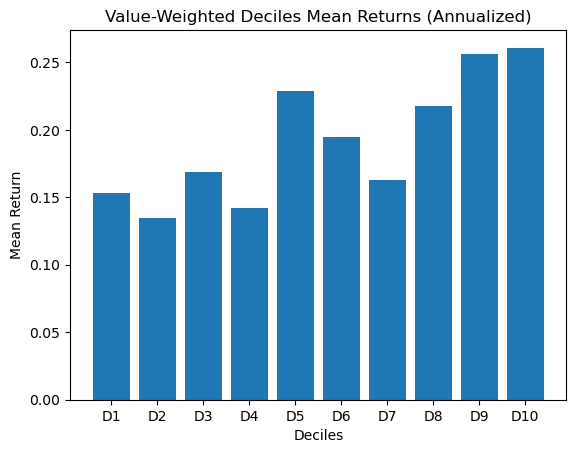

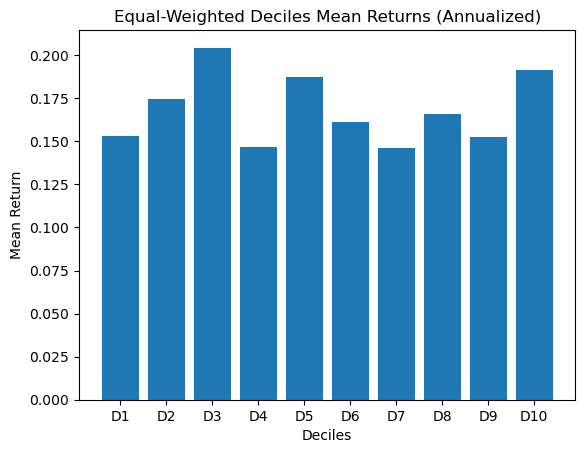

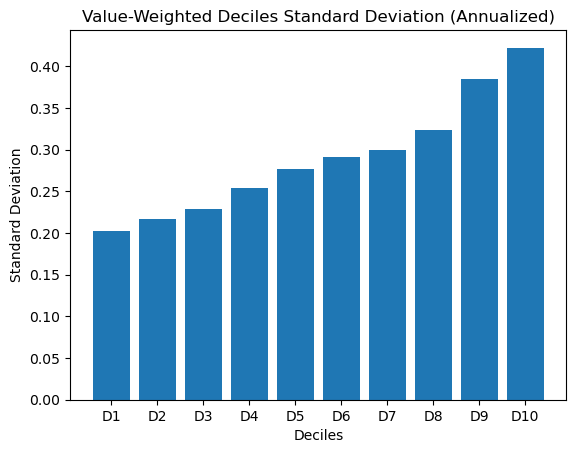

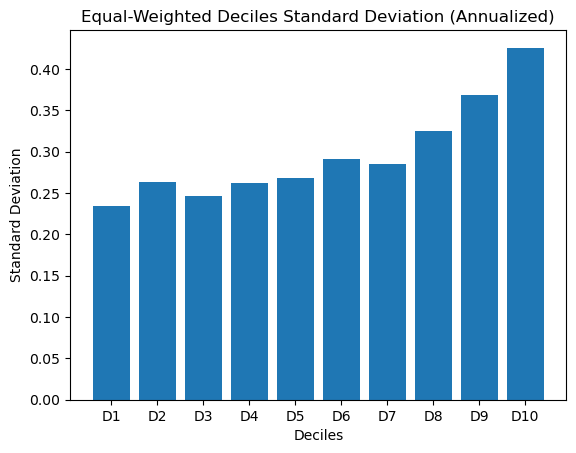

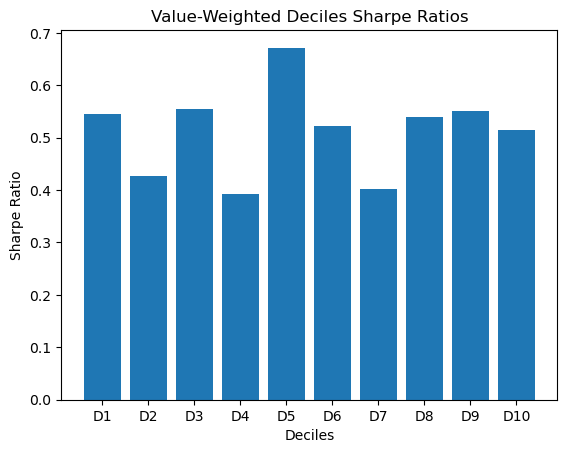

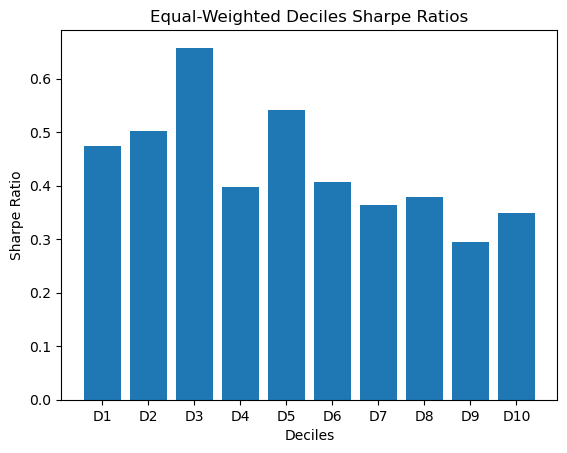

Mean: 0.11064256290708
Standard Deviation: 0.1747267767975733
Sharpe ratio: 0.6332318659735995
Monthly CAPM Alpha: 0.08105359673831888


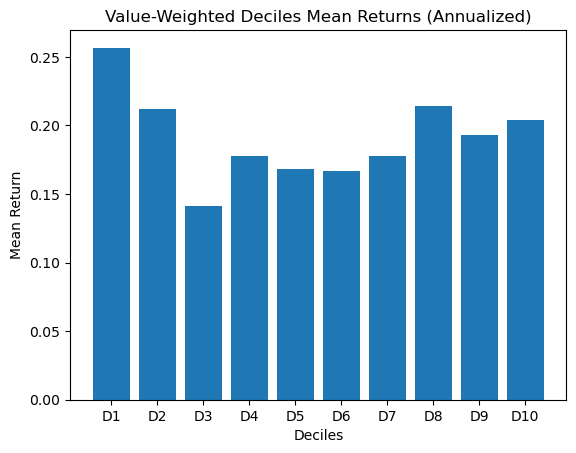

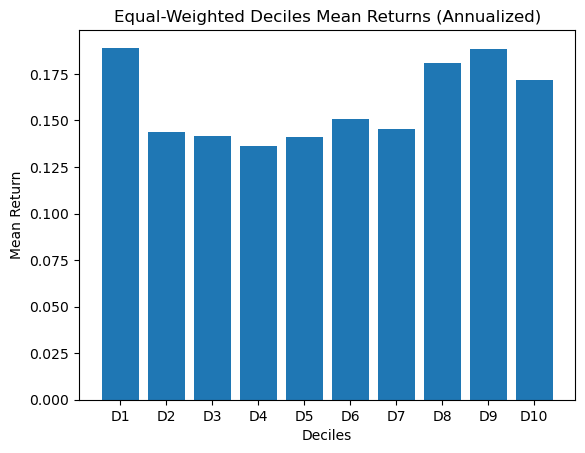

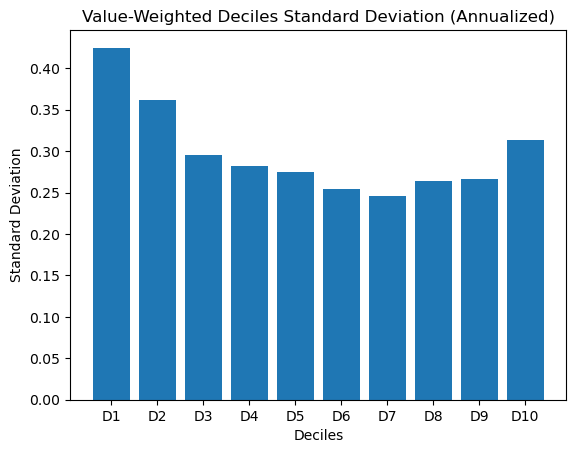

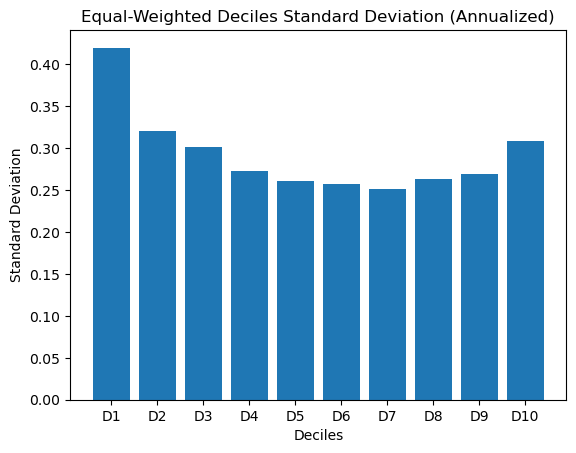

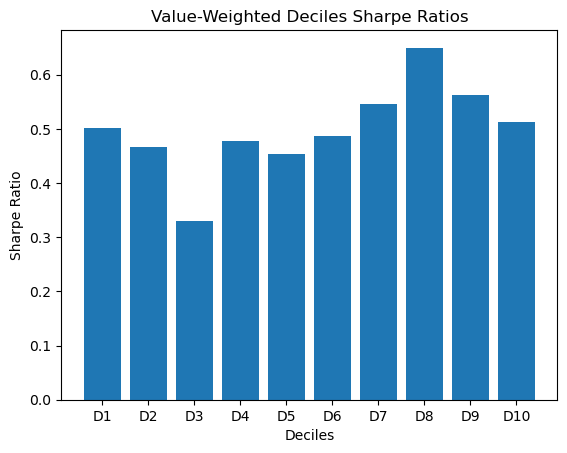

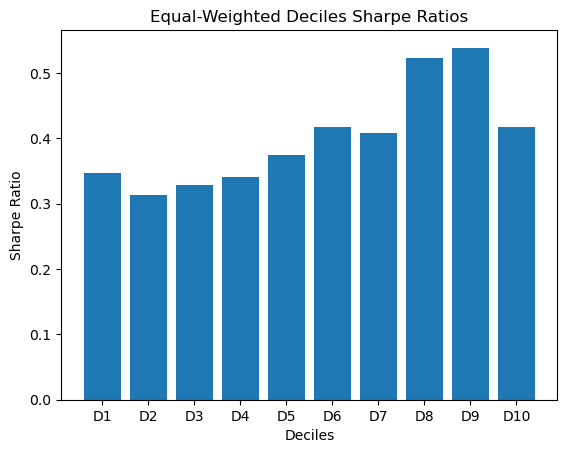

Long Leg Mean Return: 0.18035023337904488
Short Leg Mean Return: 0.15883532506517037
Long Leg Standard Deviation: 0.260011443992043
Short Leg Standard Deviation: 0.3128202072782627
Long Leg Sharpe Ratio: 0.4894216581852217
Short Leg Sharpe Ratio: 0.33802267657787843
Factor Mean Return: 0.02151490831387453
Factor Standard Deviation: 0.19393095534670585
Factor Sharpe Ratio: -0.16284194002444063
T-Statistic: 2.8716384791662763
P-Value: 0.0020417491273097
The factor strategy has an average return that is statistically significantly different from zero.
Long Leg Mean Return: 0.6111804147585115
Short Leg Mean Return: 0.6095473395879724
Long Leg Standard Deviation: 0.7455419409848159
Short Leg Standard Deviation: 0.9231148830908934
Long Leg Sharpe Ratio: 0.7485634043713074
Short Leg Sharpe Ratio: 0.602798577368248
Factor Mean Return: 0.001633075170539101
Factor Standard Deviation: 0.6849345362565967
Factor Sharpe Ratio: -0.07513407985534407
T-Statistic: 0.06171553697802482
P-Value: 0.47539468

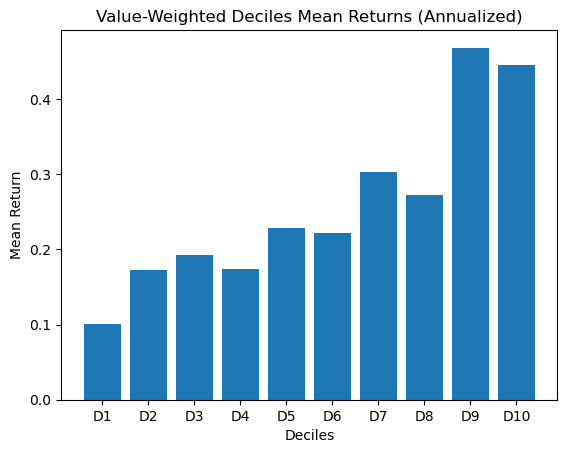

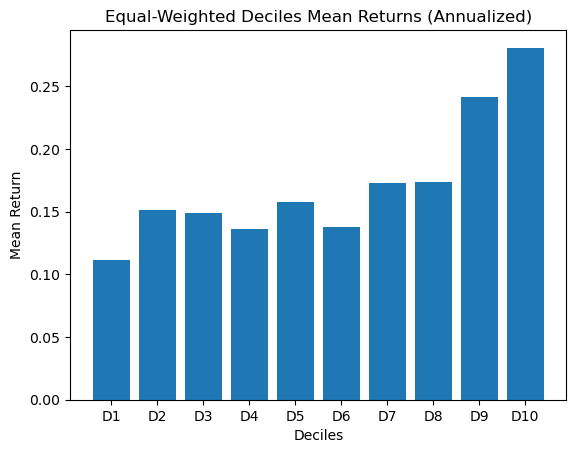

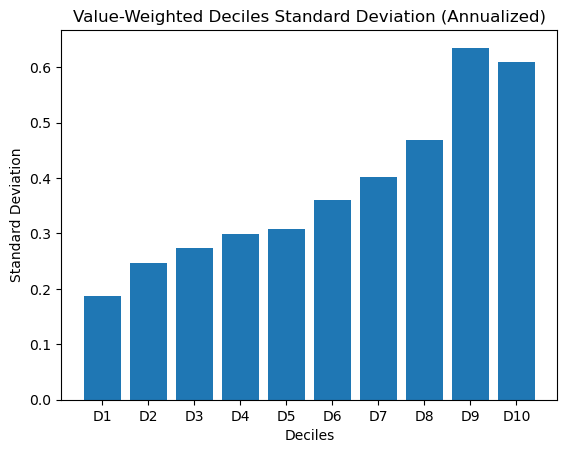

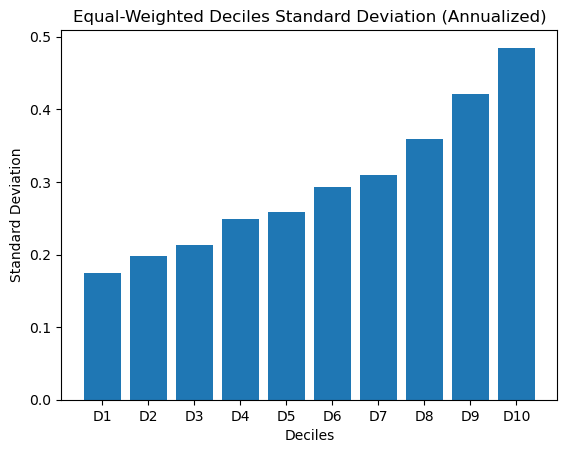

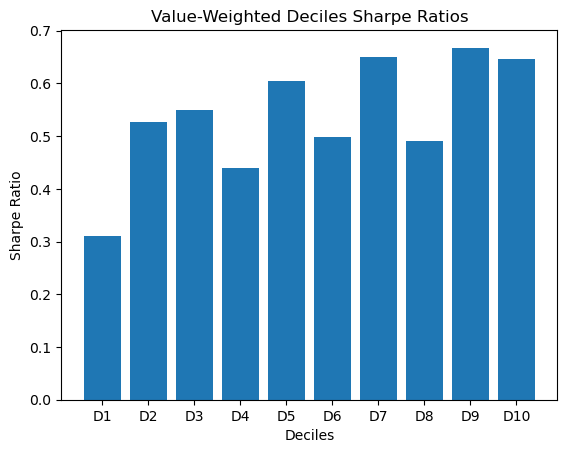

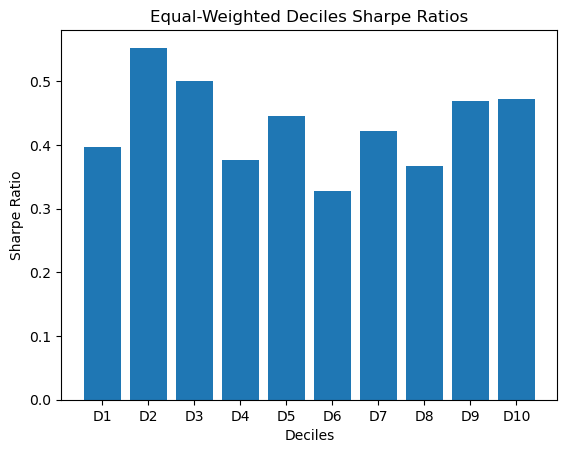

Long Leg Mean Return: 0.23212293368021564
Short Leg Mean Return: 0.13338667517631098
Long Leg Standard Deviation: 0.3766940890670836
Short Leg Standard Deviation: 0.18294592343498245
Long Leg Sharpe Ratio: 0.4570234624325492
Short Leg Sharpe Ratio: 0.40133049690775163
Factor Mean Return: 0.09873625850390466
Factor Standard Deviation: 0.2876307016594237
Factor Sharpe Ratio: 0.1347956301720213
T-Statistic: 8.485198968862809
P-Value: 0.0
The factor strategy has an average return that is statistically significantly different from zero.
Long Leg Mean Return: 1.0422565137263777
Short Leg Mean Return: 0.46549553318908676
Long Leg Standard Deviation: 1.2230607982322044
Short Leg Standard Deviation: 0.6006794520381762
Long Leg Sharpe Ratio: 0.803142099173865
Short Leg Sharpe Ratio: 0.6751198746622207
Factor Mean Return: 0.04806341504477423
Factor Standard Deviation: 0.28030693150170455
Factor Sharpe Ratio: 0.15363994061549108
T-Statistic: 4.238394655570224
P-Value: 1.1256188664154898e-05
The fa

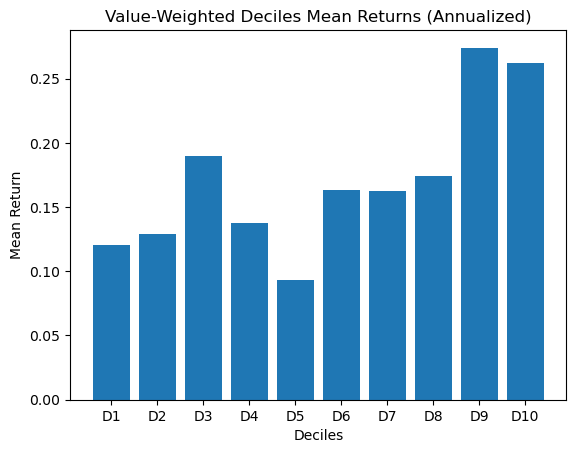

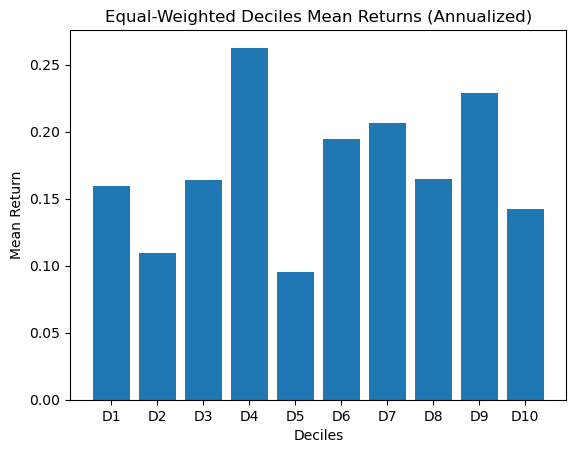

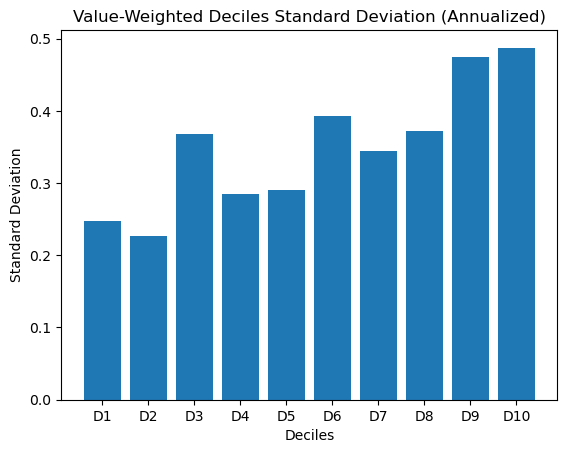

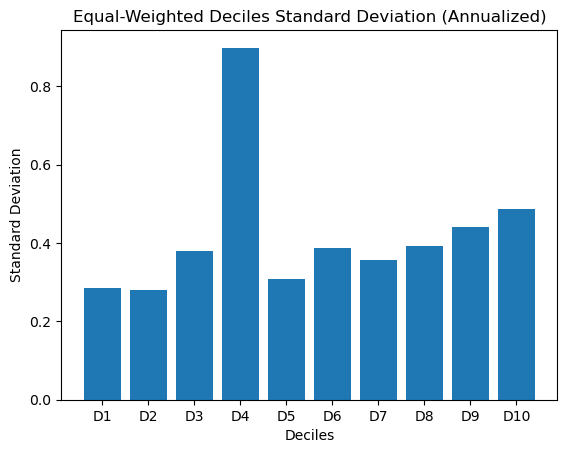

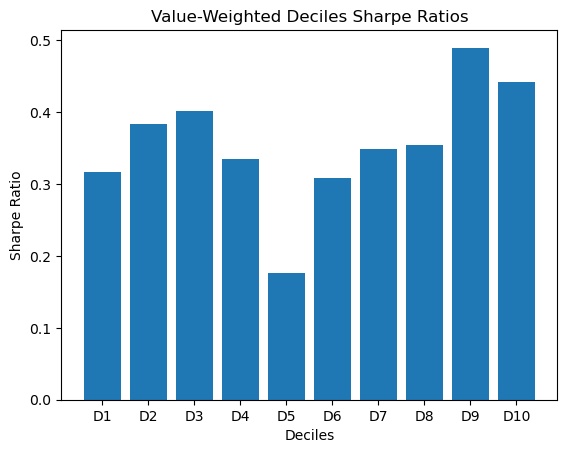

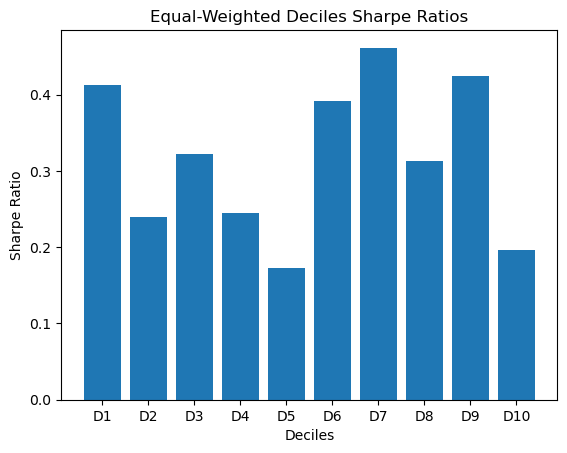

Mean: 0.1763250380863532
Standard Deviation: 0.4662010948255524
Sharpe ratio: 0.3782166967075274
Monthly CAPM Alpha: 0.13797193901132856


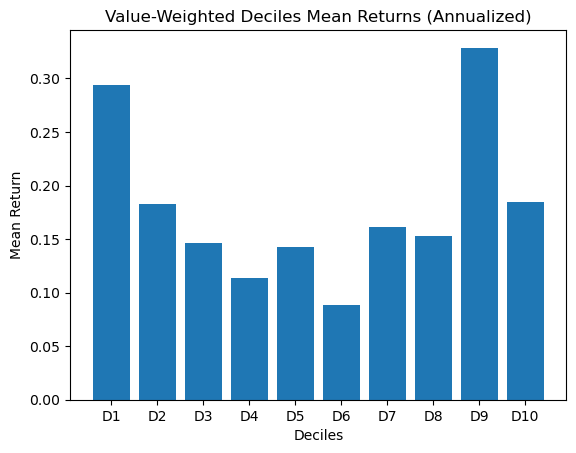

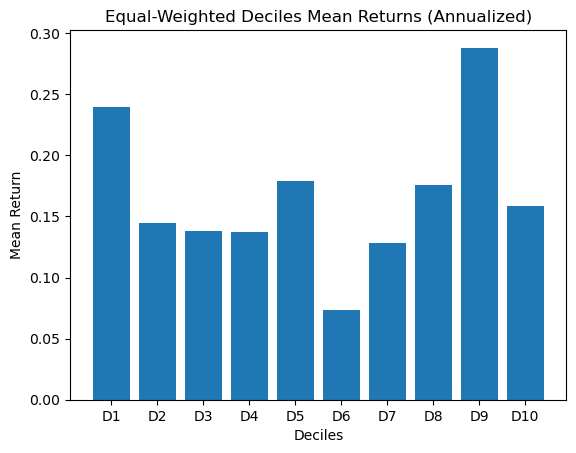

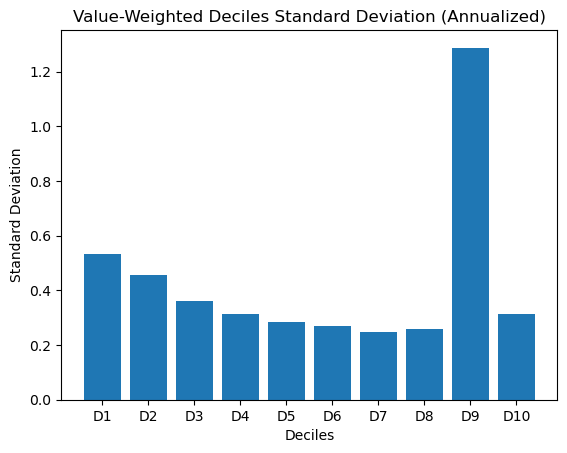

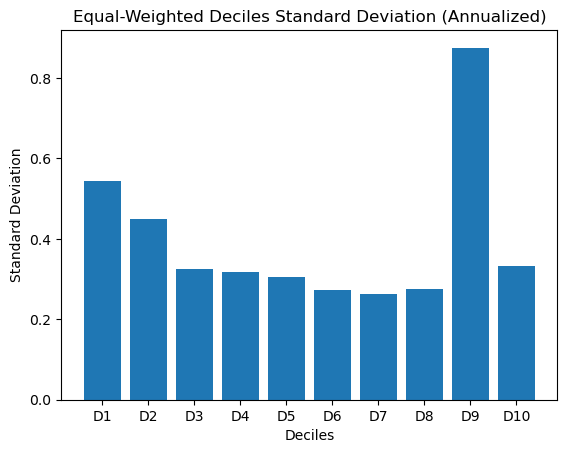

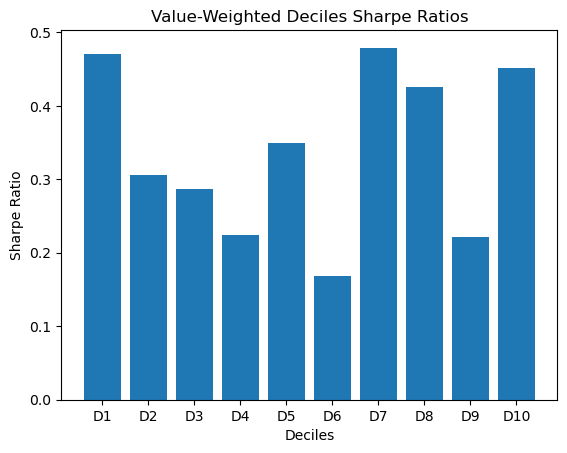

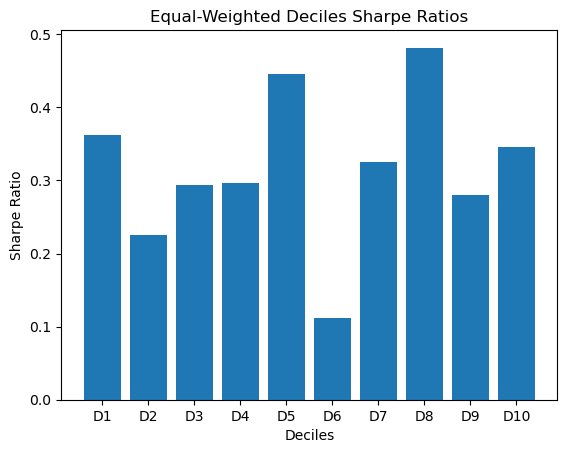

Long Leg Mean Return: 0.20868367662148518
Short Leg Mean Return: 0.18072465825519773
Long Leg Standard Deviation: 0.366688226741523
Short Leg Standard Deviation: 0.3427578833716452
Long Leg Sharpe Ratio: 0.4229115861473835
Short Leg Sharpe Ratio: 0.3708672721867361
Factor Mean Return: 0.027959018366287426
Factor Standard Deviation: 0.4256302494401052
Factor Sharpe Ratio: -0.06025877788551769
T-Statistic: 1.6990356544119132
P-Value: 0.04465623294073362
The factor strategy has an average return that is statistically significantly different from zero.
Long Leg Mean Return: 0.6660916331425282
Short Leg Mean Return: 0.622309593285751
Long Leg Standard Deviation: 1.4340866065638738
Short Leg Standard Deviation: 1.00407503968946
Long Leg Sharpe Ratio: 0.4270904234866321
Short Leg Sharpe Ratio: 0.5663945360428271
Factor Mean Return: 0.043782039856777144
Factor Standard Deviation: 1.5983498334513895
Factor Sharpe Ratio: -0.006146925389083075
T-Statistic: 0.7084956869127071
P-Value: 0.2393187448

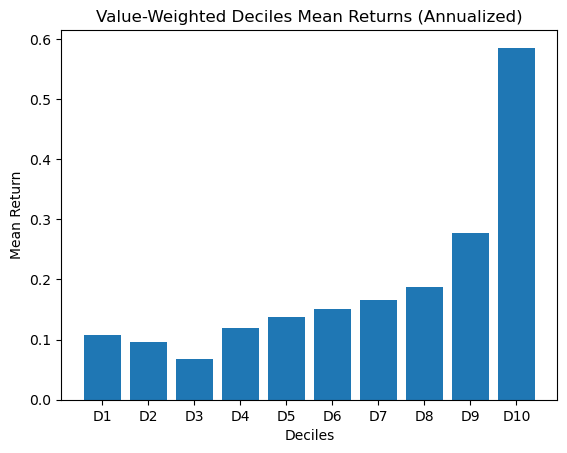

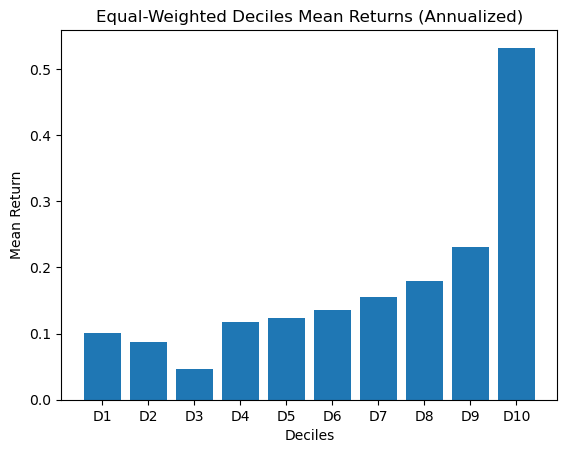

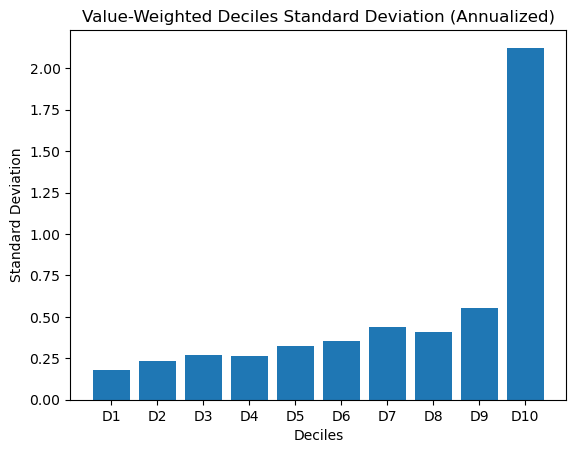

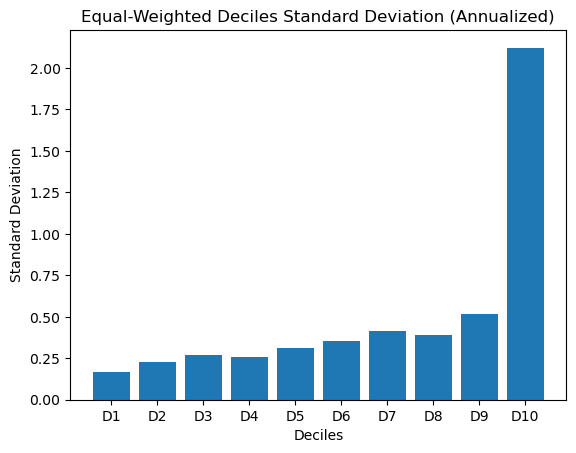

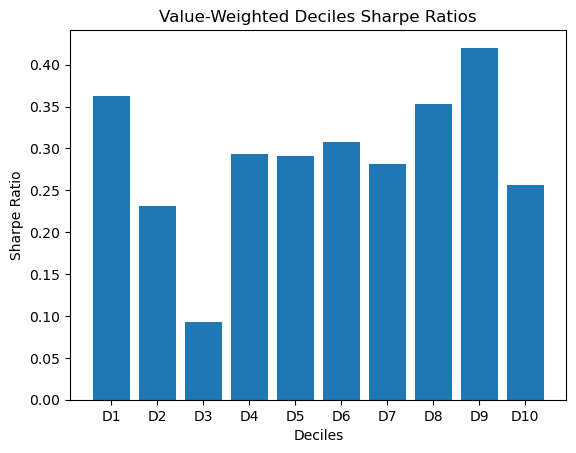

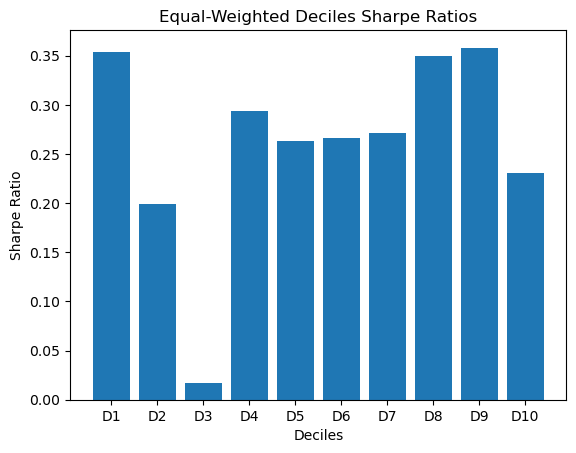

Long Leg Mean Return: 0.3096181640037594
Short Leg Mean Return: 0.08168826977787239
Long Leg Standard Deviation: 0.7167010284678432
Short Leg Standard Deviation: 0.17321508302109337
Long Leg Sharpe Ratio: 0.3478755812275455
Short Leg Sharpe Ratio: 0.12312815857912726
Factor Mean Return: 0.22734749037793345
Factor Standard Deviation: 0.7023394150285263
Factor Sharpe Ratio: 0.2378509729687031
T-Statistic: 7.994808038785112
P-Value: 6.661338147750939e-16
The factor strategy has an average return that is statistically significantly different from zero.
Long Leg Mean Return: 0.8882101185934903
Short Leg Mean Return: 0.2701417990139541
Long Leg Standard Deviation: 2.0672191890599683
Short Leg Standard Deviation: 0.544386220905346
Long Leg Sharpe Ratio: 0.40049683449912316
Short Leg Sharpe Ratio: 0.38535358793196717
Factor Mean Return: 0.05133007331367059
Factor Standard Deviation: 0.5884661800429442
Factor Sharpe Ratio: 0.07868839386323043
T-Statistic: 2.1543452012452597
P-Value: 0.015606555

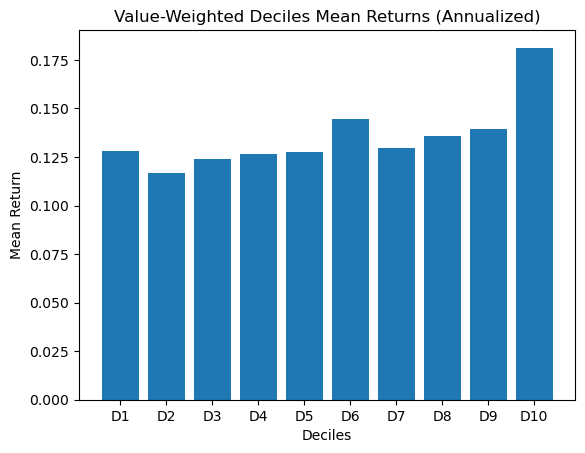

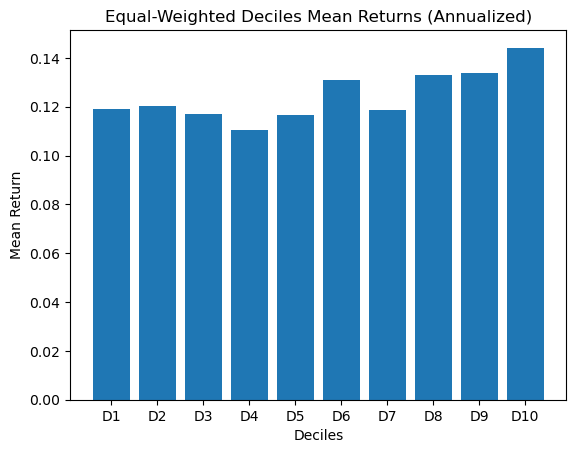

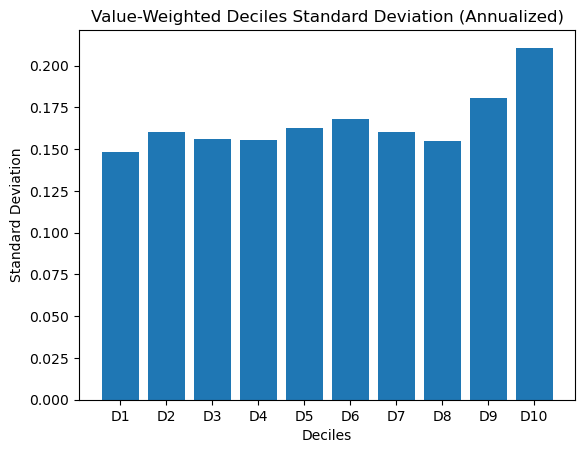

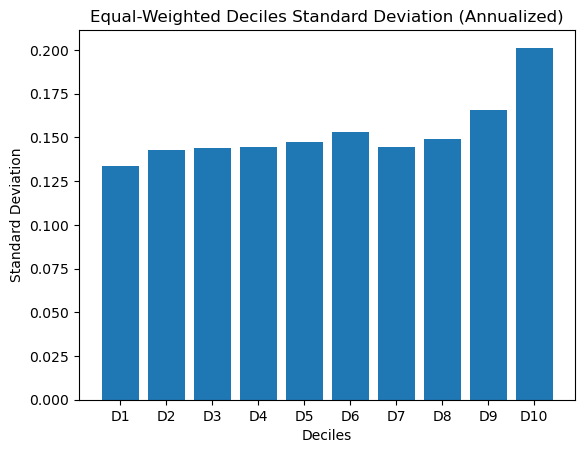

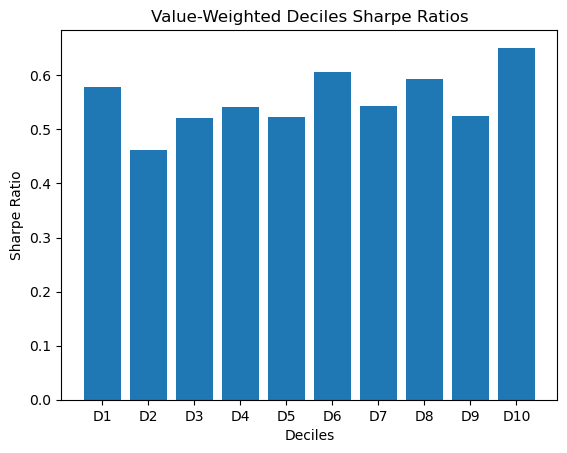

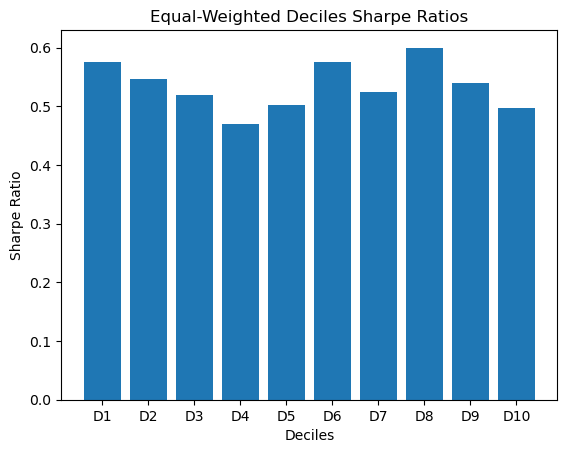

Mean: 0.33668320741455116
Standard Deviation: 0.7216170047211433
Sharpe ratio: 0.4665677294351685
Monthly CAPM Alpha: 0.28551231730405846


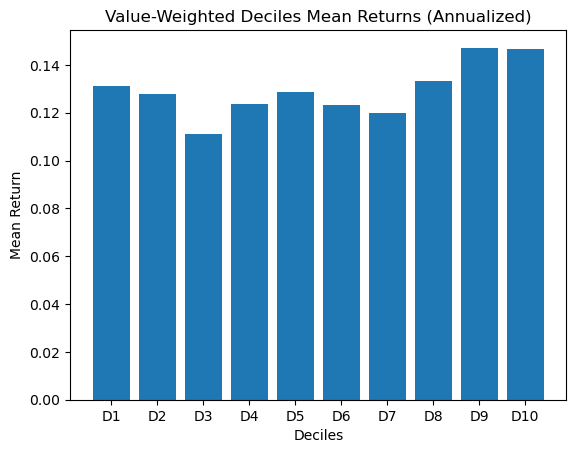

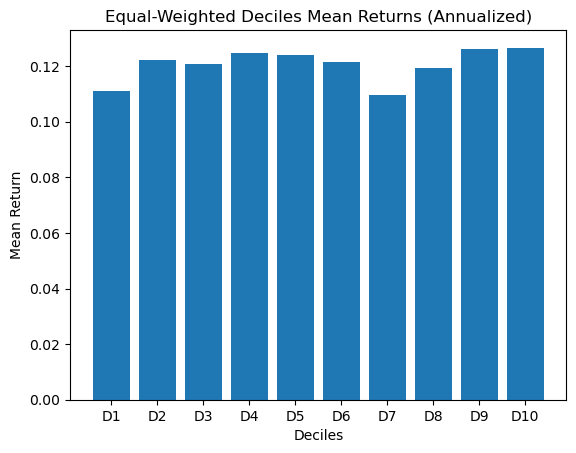

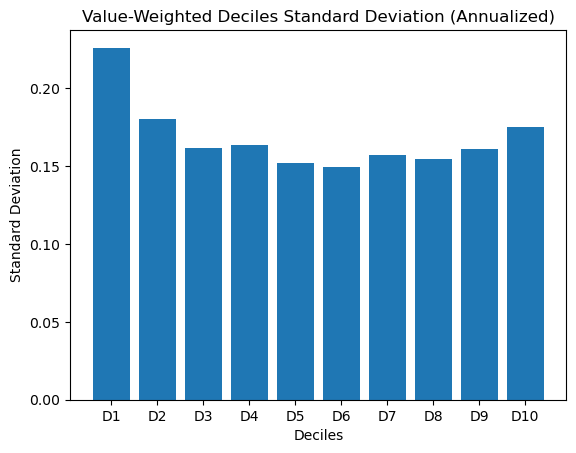

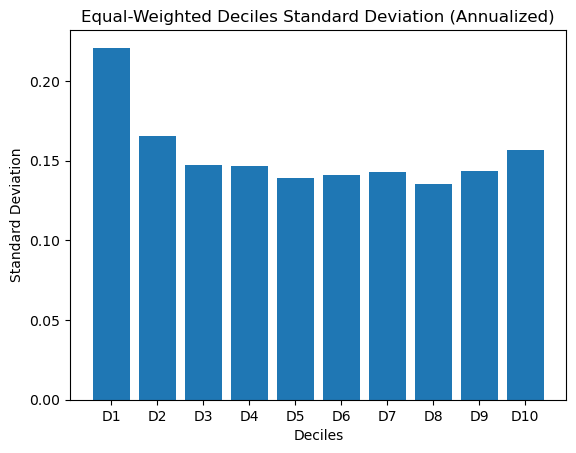

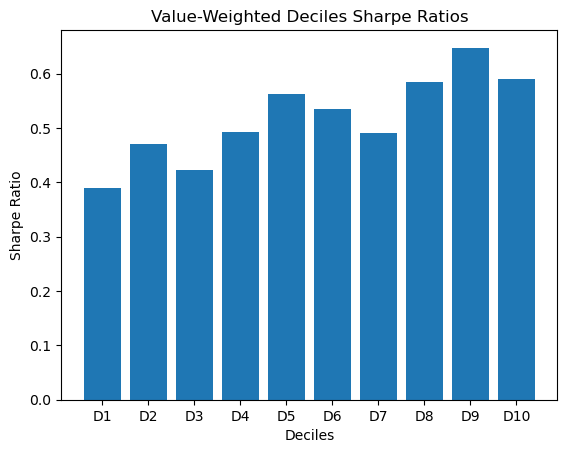

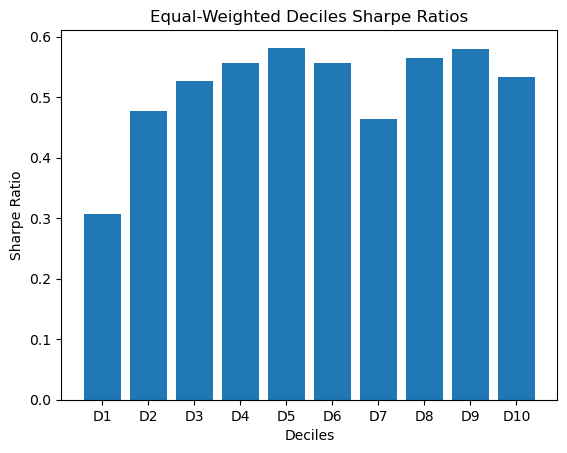

Long Leg Mean Return: 0.12363312284745648
Short Leg Mean Return: 0.1180017545380192
Long Leg Standard Deviation: 0.13443441413906682
Short Leg Standard Deviation: 0.1642909620317506
Long Leg Sharpe Ratio: 0.5239963745862188
Short Leg Sharpe Ratio: 0.3944938693981878
Factor Mean Return: 0.005631368309437266
Factor Standard Deviation: 0.11847424372610275
Factor Sharpe Ratio: -0.4014257227037068
T-Statistic: 1.2303463601509925
P-Value: 0.10928371535130232
The factor strategy does not have an average return that is statistically significantly different from zero.
Long Leg Mean Return: 0.4268958843056969
Short Leg Mean Return: 0.36991683398199665
Long Leg Standard Deviation: 0.4444084588305047
Short Leg Standard Deviation: 0.5209452620430733
Long Leg Sharpe Ratio: 0.8409063771427072
Short Leg Sharpe Ratio: 0.6079849071299271
Factor Mean Return: 0.05697905032370021
Factor Standard Deviation: 0.400451855070328
Factor Sharpe Ratio: 0.009461994136777278
T-Statistic: 3.68300491165745
P-Value: 0.

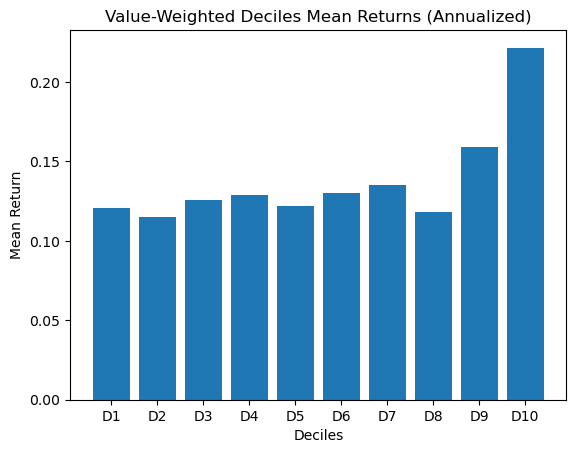

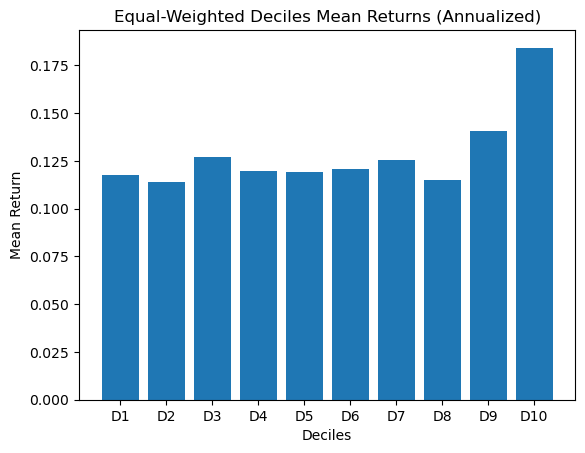

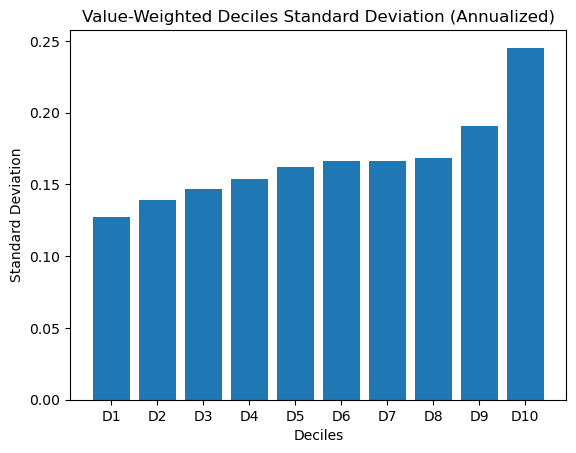

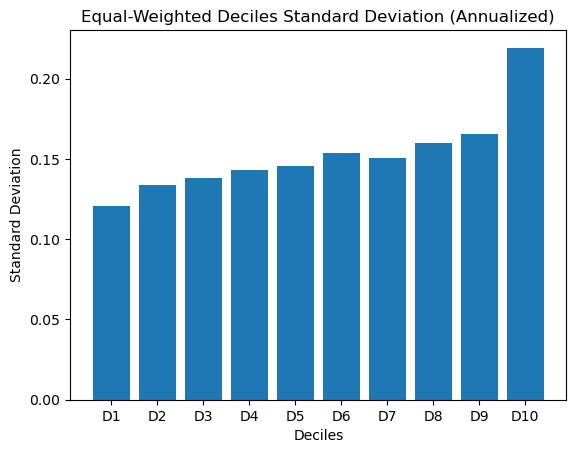

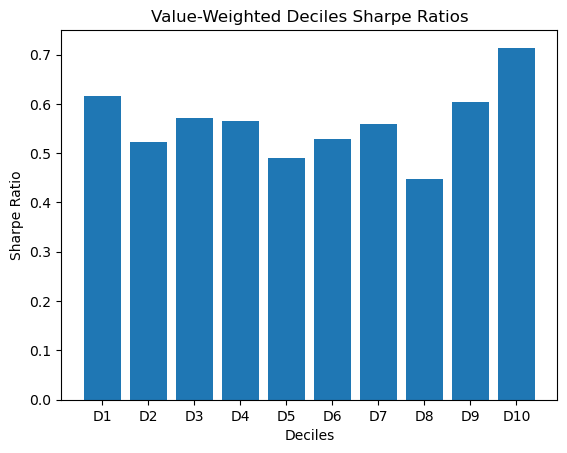

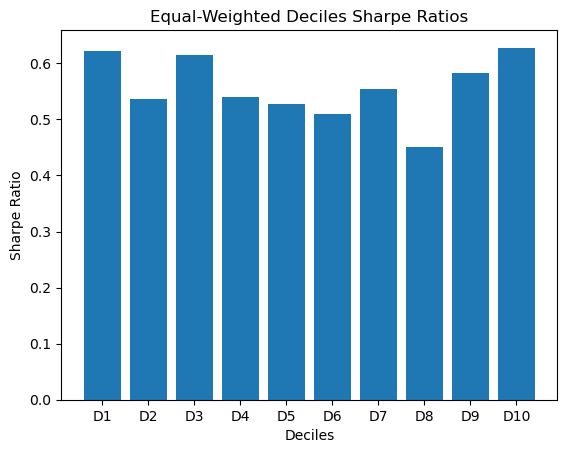

Long Leg Mean Return: 0.13191053674910325
Short Leg Mean Return: 0.11877910620468679
Long Leg Standard Deviation: 0.1639394392056433
Short Leg Standard Deviation: 0.12687303260334423
Long Leg Sharpe Ratio: 0.4398422950229025
Short Leg Sharpe Ratio: 0.46457219342237493
Factor Mean Return: 0.014662380276828587
Factor Standard Deviation: 0.10837542925101329
Factor Sharpe Ratio: -0.4181642818541379
T-Statistic: 3.3414776902531367
P-Value: 0.0004166685665090153
The factor strategy has an average return that is statistically significantly different from zero.
Long Leg Mean Return: 0.4281630034493815
Short Leg Mean Return: 0.36145933810574304
Long Leg Standard Deviation: 0.4752557527704957
Short Leg Standard Deviation: 0.3959121203905521
Long Leg Sharpe Ratio: 0.7750773425422155
Short Leg Sharpe Ratio: 0.7618405686751945
Factor Mean Return: 0.006001208674937435
Factor Standard Deviation: 0.09999024157941733
Factor Sharpe Ratio: 0.010028803885393166
T-Statistic: 1.4823338572879905
P-Value: 0.0

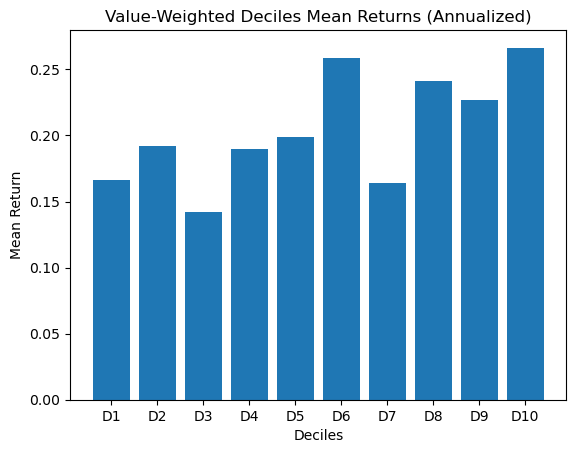

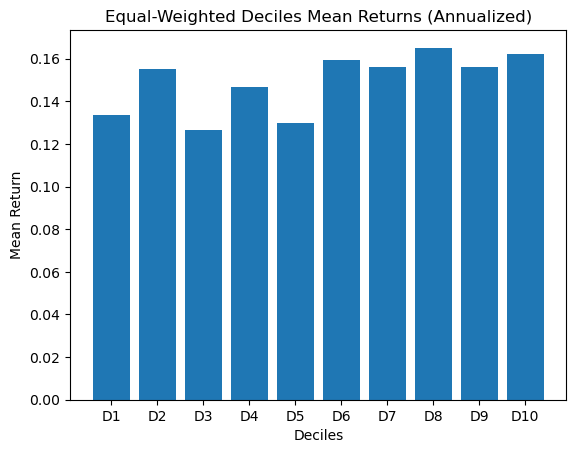

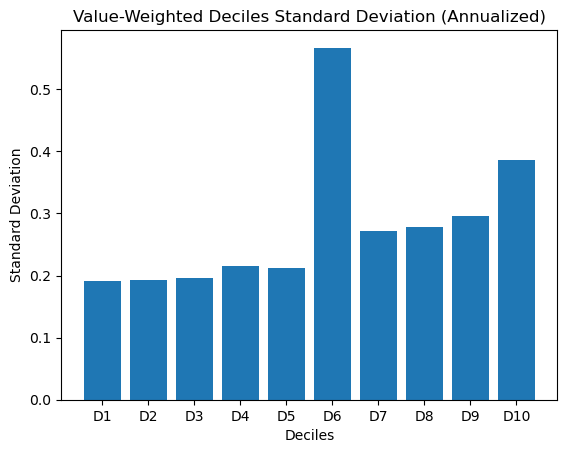

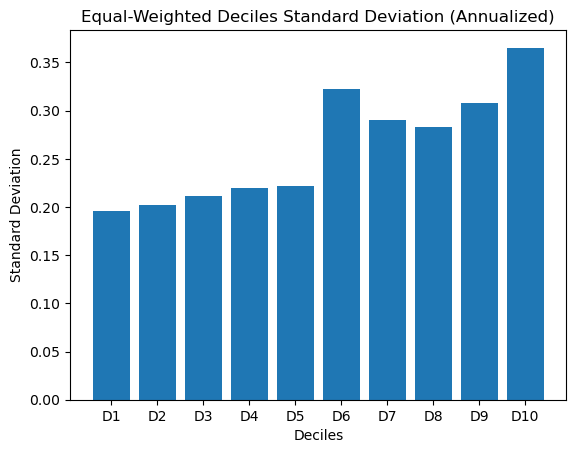

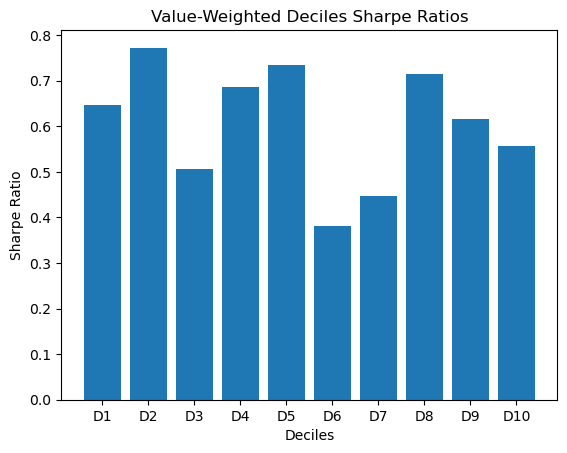

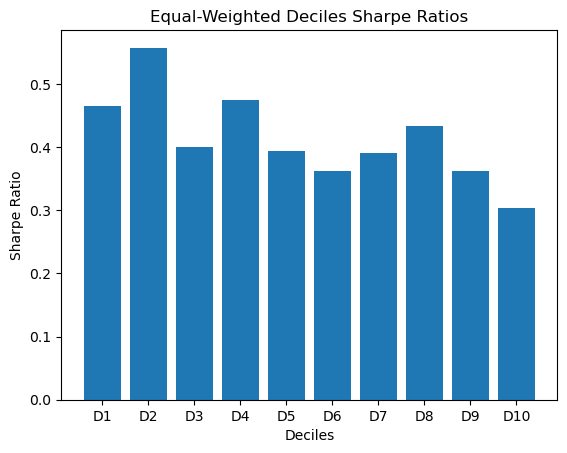

Mean: 0.09513153976602128
Standard Deviation: 0.20718975251738608
Sharpe ratio: 0.4591517611762117
Monthly CAPM Alpha: 0.057249657960011274


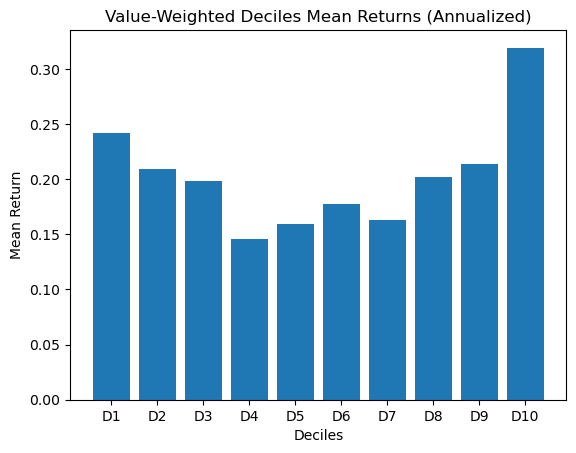

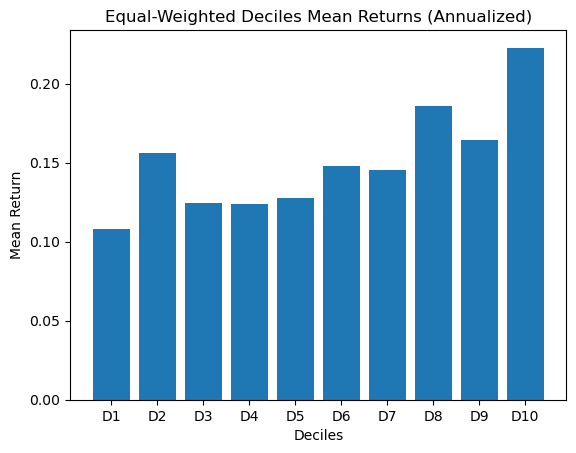

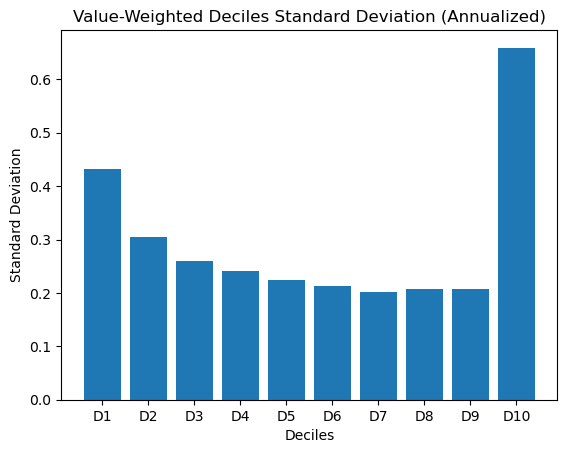

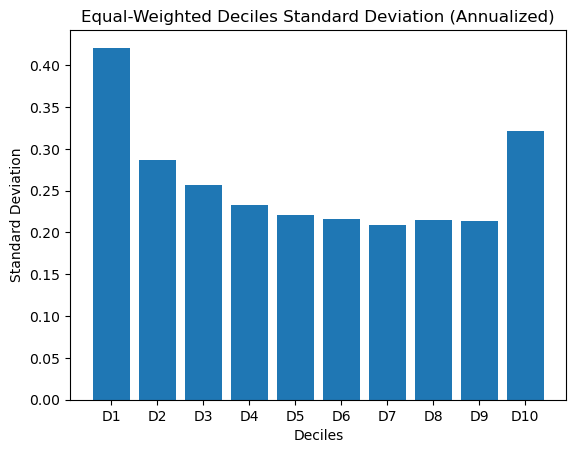

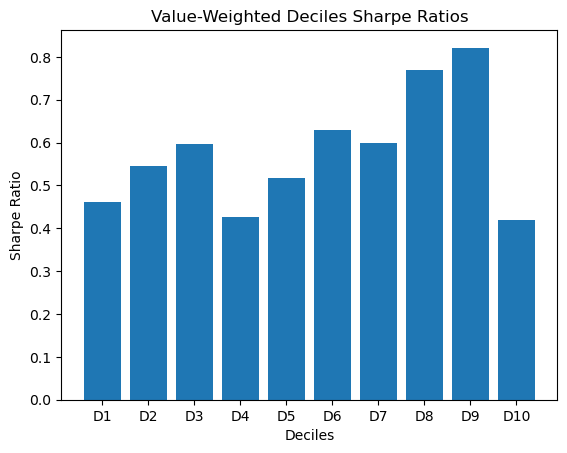

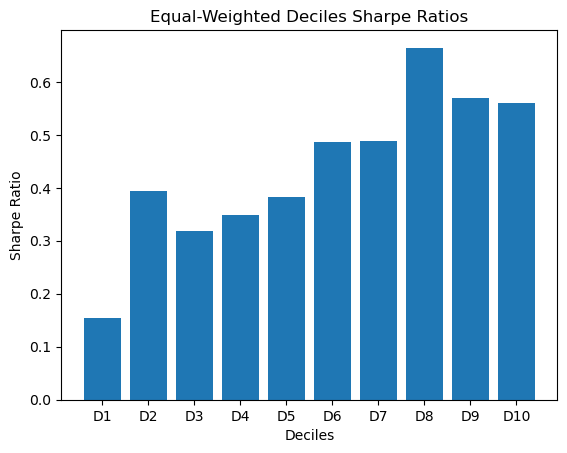

Long Leg Mean Return: 0.1913419000311859
Short Leg Mean Return: 0.12892634618256732
Long Leg Standard Deviation: 0.22405048902279576
Short Leg Standard Deviation: 0.29499459469060096
Long Leg Sharpe Ratio: 0.6170345769867739
Short Leg Sharpe Ratio: 0.25706011647018884
Factor Mean Return: 0.062415553848618584
Factor Standard Deviation: 0.18899688806262618
Factor Sharpe Ratio: 0.049315904779367696
T-Statistic: 8.548217752801577
P-Value: 0.0
The factor strategy has an average return that is statistically significantly different from zero.
Long Leg Mean Return: 0.73534897205516
Short Leg Mean Return: 0.6500531211289144
Long Leg Standard Deviation: 0.8572038121797335
Short Leg Standard Deviation: 0.8814003209444604
Long Leg Sharpe Ratio: 0.7959063656132966
Short Leg Sharpe Ratio: 0.677283755894168
Factor Mean Return: 0.08529585092624559
Factor Standard Deviation: 0.8890151902609172
Factor Sharpe Ratio: 0.03622080923439528
T-Statistic: 2.483454032598319
P-Value: 0.006505756316686928
The fact

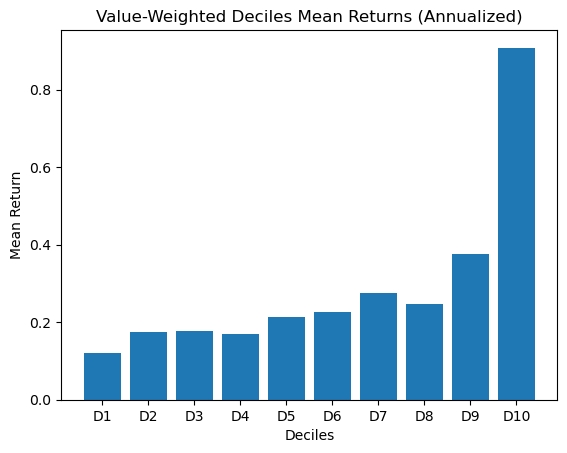

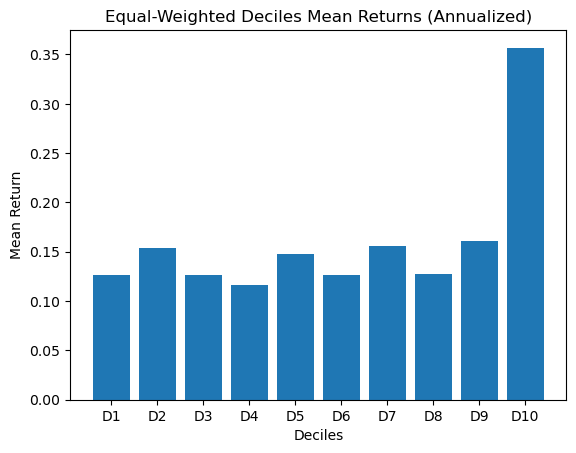

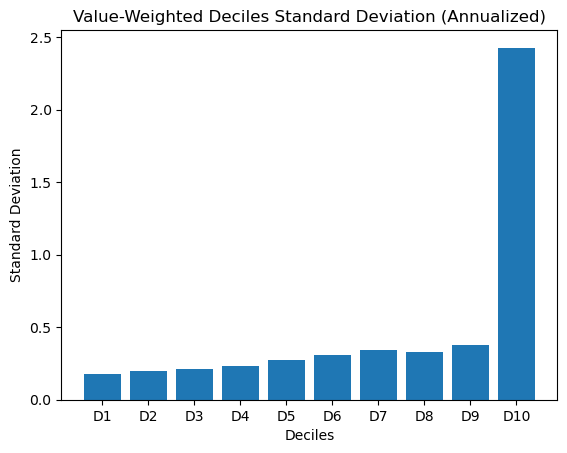

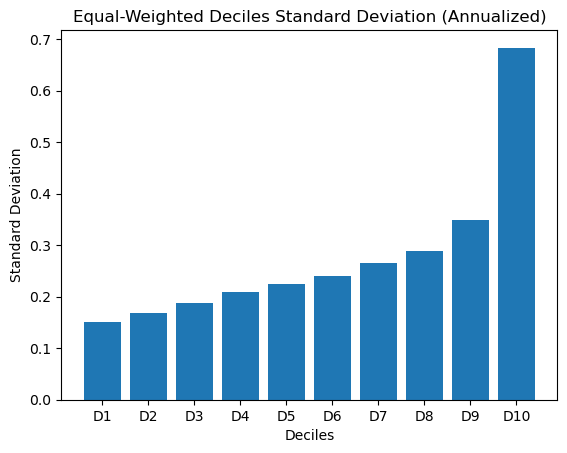

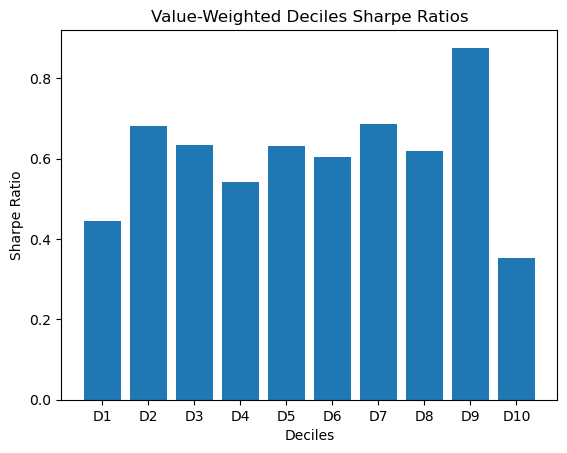

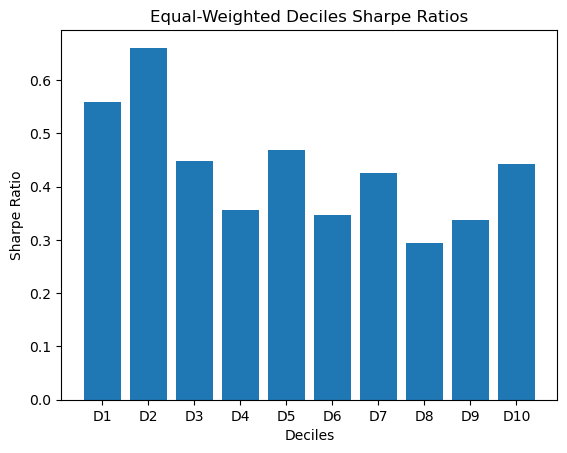

Long Leg Mean Return: 0.2004137880915824
Short Leg Mean Return: 0.13488332947799558
Long Leg Standard Deviation: 0.3614902570385253
Short Leg Standard Deviation: 0.15835056474773568
Long Leg Sharpe Ratio: 0.38852745970332536
Short Leg Sharpe Ratio: 0.47311755900867336
Factor Mean Return: 0.06553045861358678
Factor Standard Deviation: 0.28615246749307516
Factor Sharpe Ratio: 0.019449637619565387
T-Statistic: 5.660650184747514
P-Value: 7.54002738023729e-09
The factor strategy has an average return that is statistically significantly different from zero.
Long Leg Mean Return: 1.266446300255585
Short Leg Mean Return: 0.4741563955970327
Long Leg Standard Deviation: 2.2423516554500904
Short Leg Standard Deviation: 0.5280649500069935
Long Leg Sharpe Ratio: 0.5380429070999192
Short Leg Sharpe Ratio: 0.7843571113262588
Factor Mean Return: 0.06602415872154603
Factor Standard Deviation: 0.6237648549492123
Factor Sharpe Ratio: 0.09783668236930904
T-Statistic: 2.6163905978111175
P-Value: 0.00444324

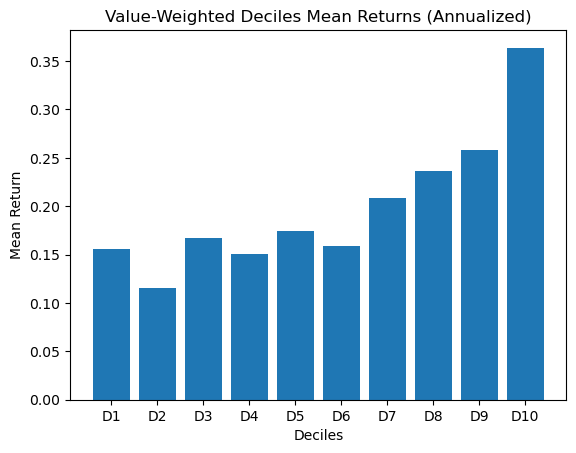

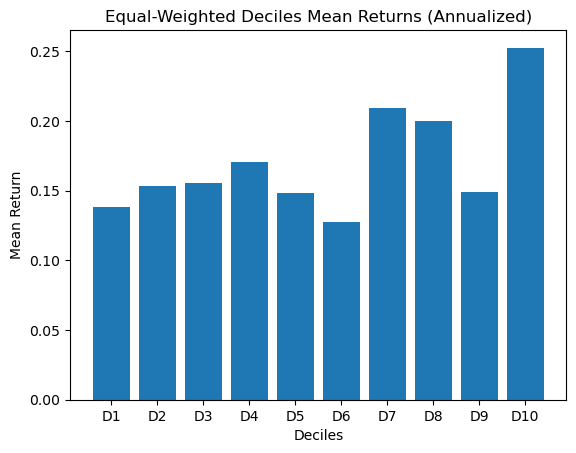

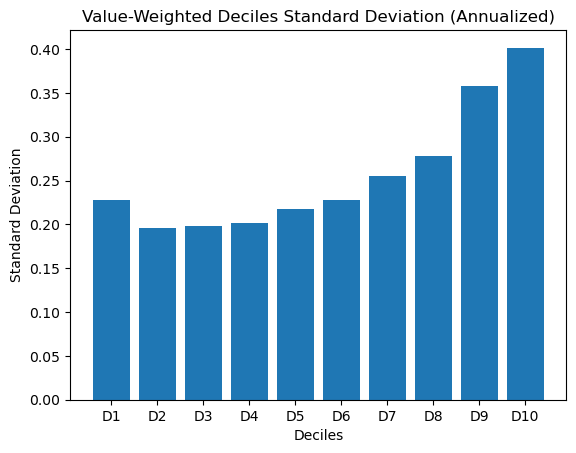

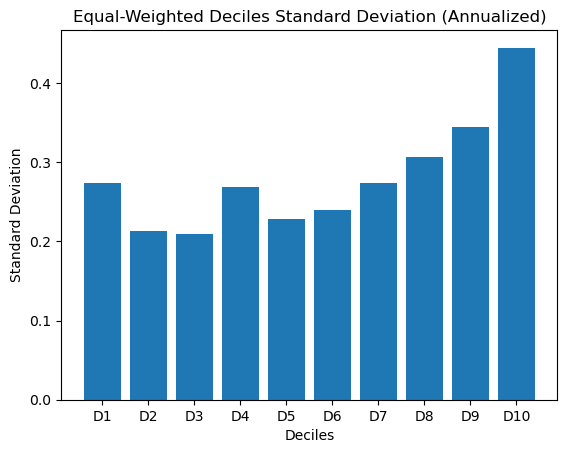

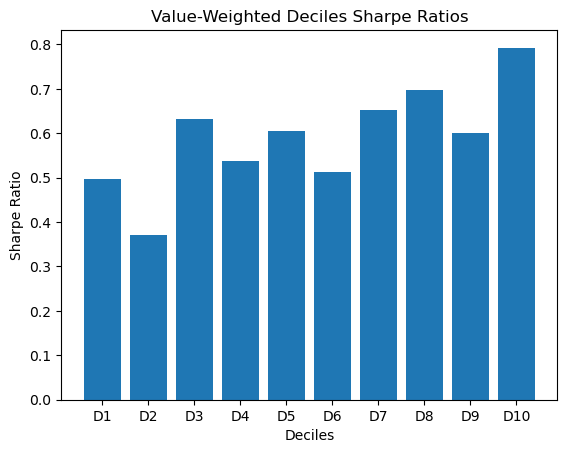

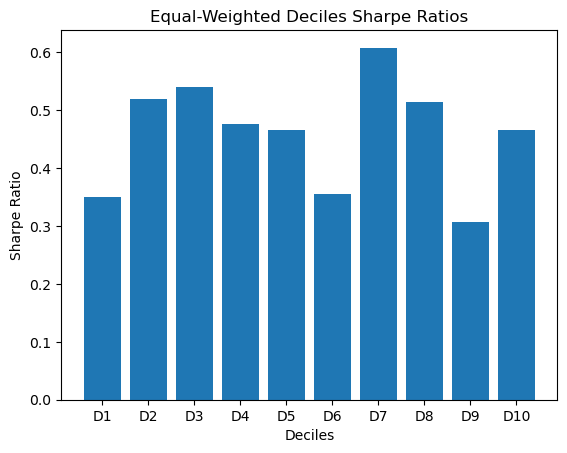

Mean: 0.09036660338793903
Standard Deviation: 0.2903093268016558
Sharpe ratio: 0.3112769554582
Monthly CAPM Alpha: 0.0410857075212812


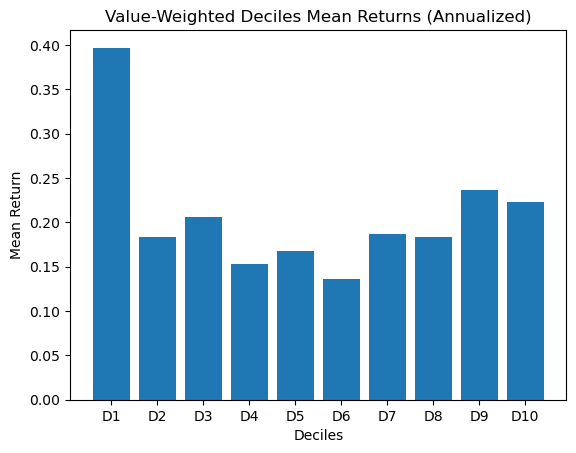

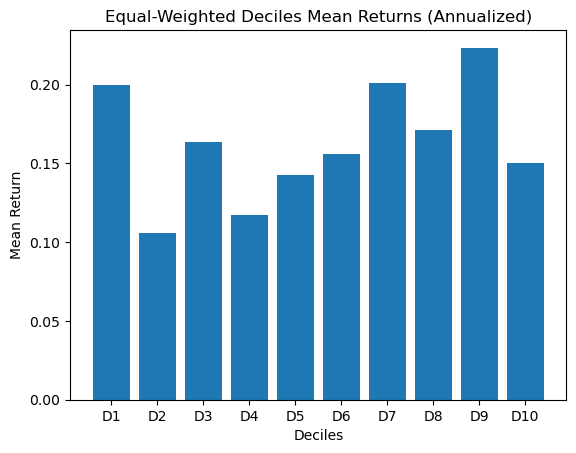

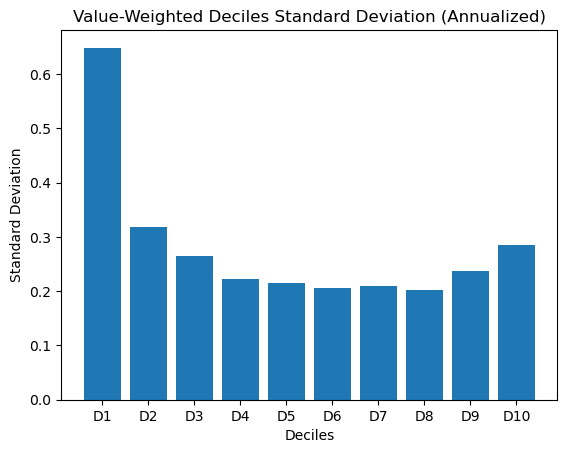

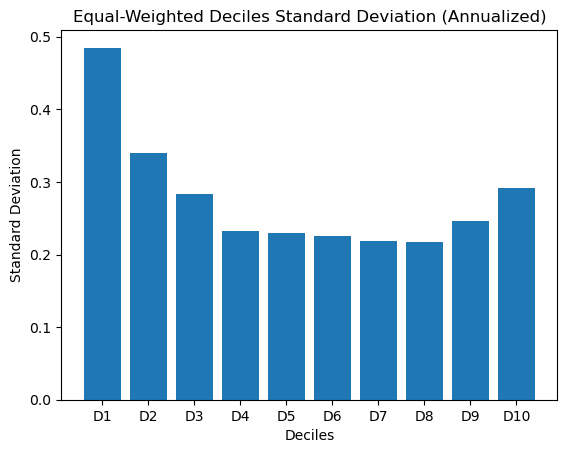

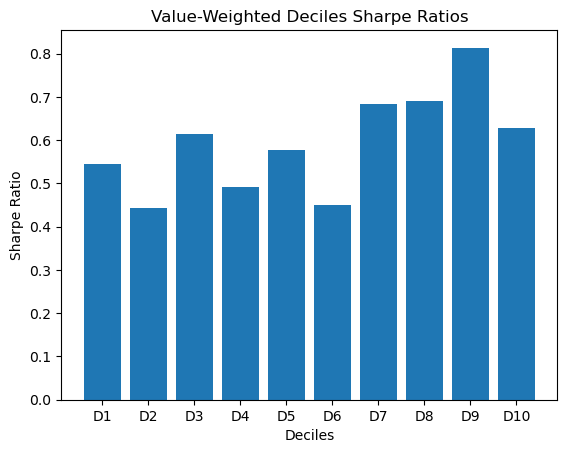

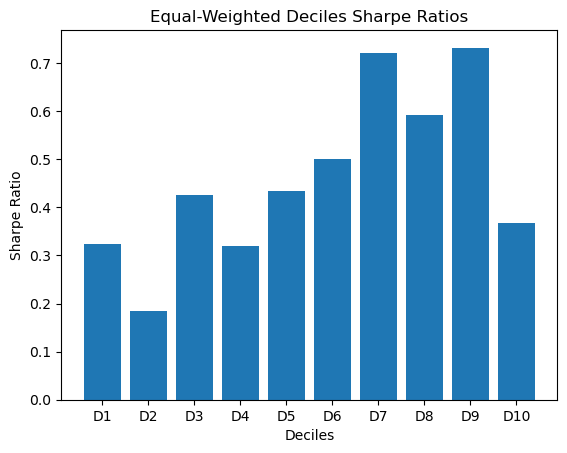

Long Leg Mean Return: 0.1812024189748267
Short Leg Mean Return: 0.15729839197562878
Long Leg Standard Deviation: 0.21387154558940977
Short Leg Standard Deviation: 0.3088987079988093
Long Leg Sharpe Ratio: 0.596161990781983
Short Leg Sharpe Ratio: 0.3353787397239733
Factor Mean Return: 0.023904026999197893
Factor Standard Deviation: 0.2533001357315016
Factor Sharpe Ratio: -0.11763241065536084
T-Statistic: 2.4390678371152257
P-Value: 0.007362601857596296
The factor strategy has an average return that is statistically significantly different from zero.
Long Leg Mean Return: 0.6419320762782081
Short Leg Mean Return: 0.7868871546509985
Long Leg Standard Deviation: 0.5986664579531787
Short Leg Standard Deviation: 0.9603724971513228
Long Leg Sharpe Ratio: 0.9825700703271883
Short Leg Sharpe Ratio: 0.7634400446089077
Factor Mean Return: -0.14495507837279026
Factor Standard Deviation: 0.9266516993266125
Factor Sharpe Ratio: -0.21437980538078705
T-Statistic: -4.043013018986691
P-Value: 0.9999736

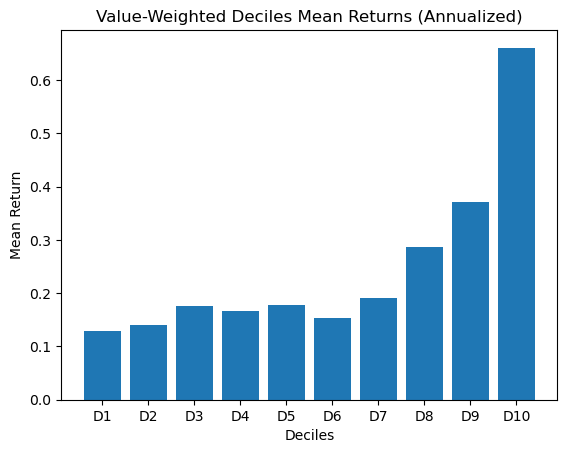

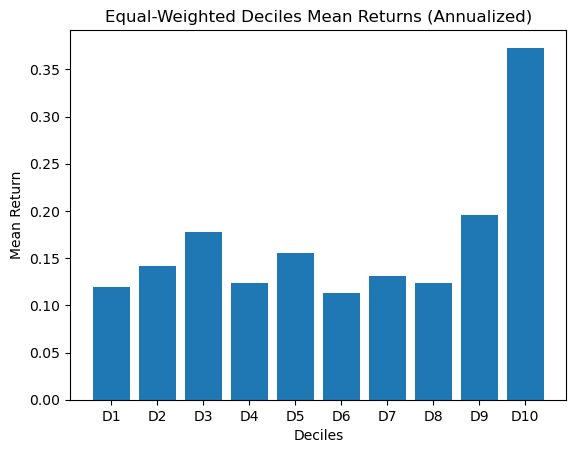

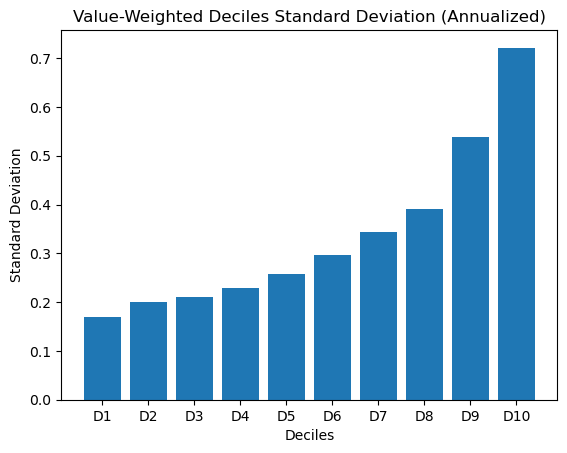

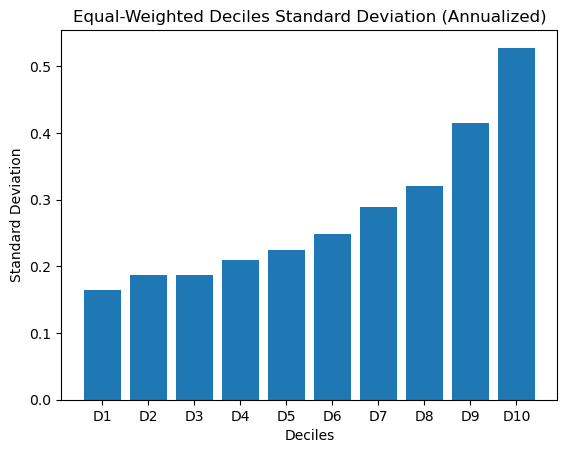

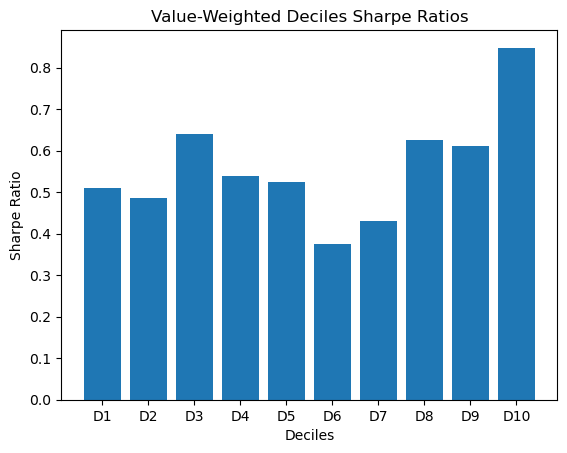

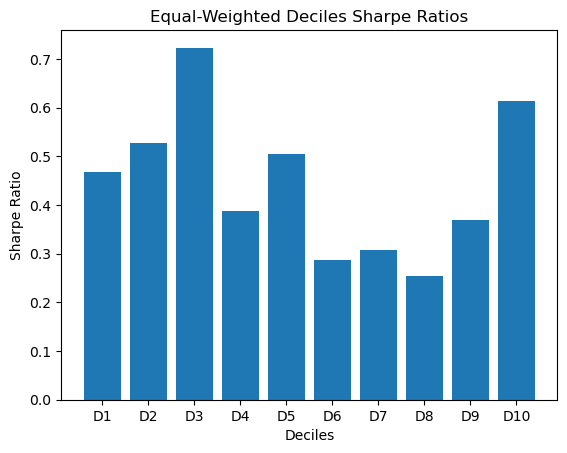

Long Leg Mean Return: 0.20319364036447535
Short Leg Mean Return: 0.14498857743149443
Long Leg Standard Deviation: 0.33973130581033983
Short Leg Standard Deviation: 0.16450802353250707
Long Leg Sharpe Ratio: 0.42186664831133375
Short Leg Sharpe Ratio: 0.5173987417023508
Factor Mean Return: 0.05820506293298093
Factor Standard Deviation: 0.31369224279592955
Factor Sharpe Ratio: -0.005314986778102261
T-Statistic: 4.5789471417745045
P-Value: 2.336611324871285e-06
The factor strategy has an average return that is statistically significantly different from zero.
Long Leg Mean Return: 1.1585890312999736
Short Leg Mean Return: 0.44468601580379985
Long Leg Standard Deviation: 1.070424904260199
Short Leg Standard Deviation: 0.5233018820000405
Long Leg Sharpe Ratio: 1.0264304332525722
Short Leg Sharpe Ratio: 0.735356963130386
Factor Mean Return: 0.05949191795801447
Factor Standard Deviation: 0.2885102629970305
Factor Sharpe Ratio: 0.18891028798718762
T-Statistic: 5.088682445994522
P-Value: 1.80279

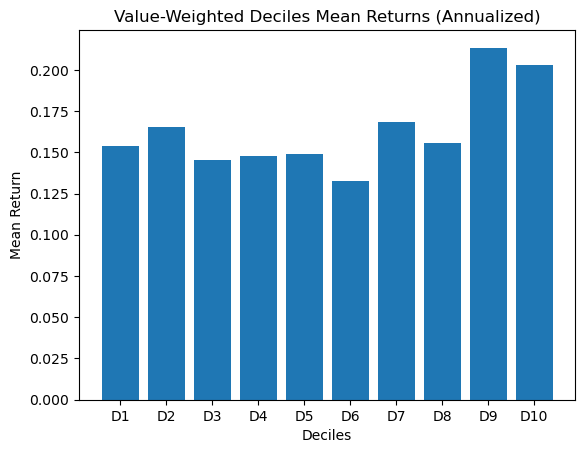

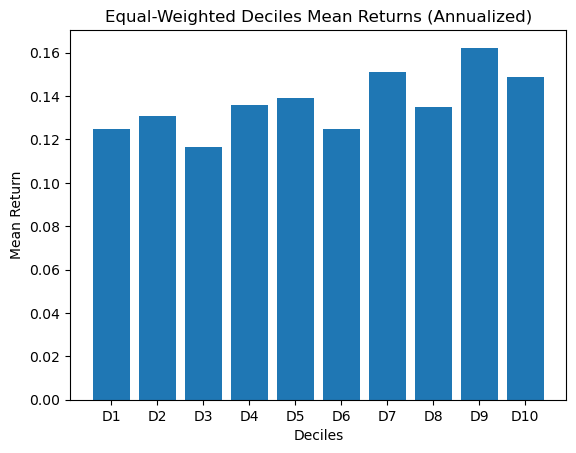

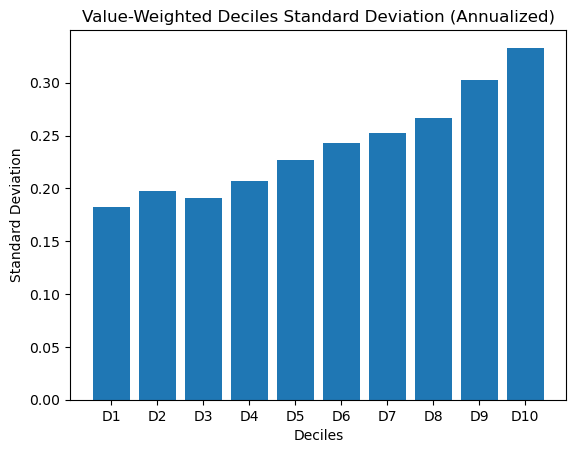

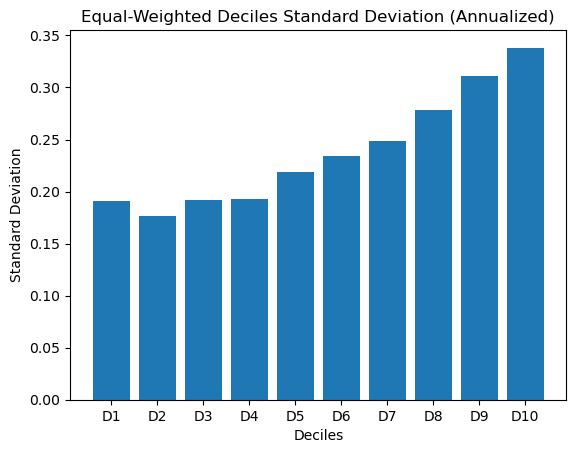

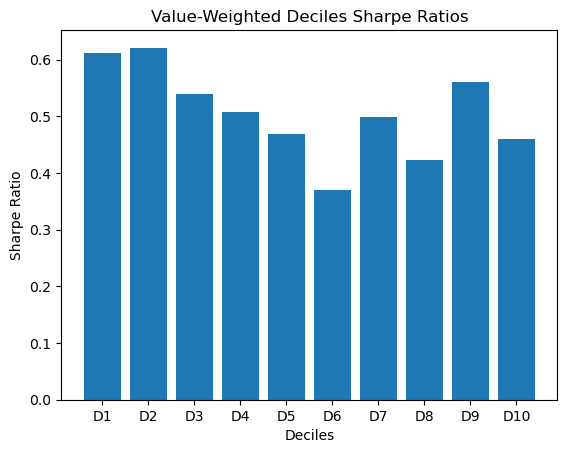

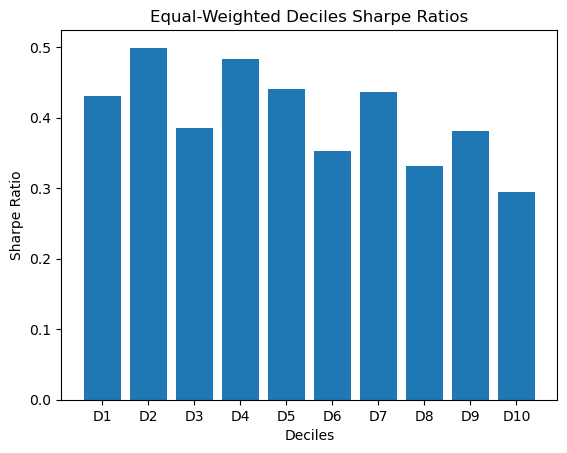

Mean: 0.08666739861497627
Standard Deviation: 0.19343568334801758
Sharpe ratio: 0.4480424558433183
Monthly CAPM Alpha: 0.04871518076161255


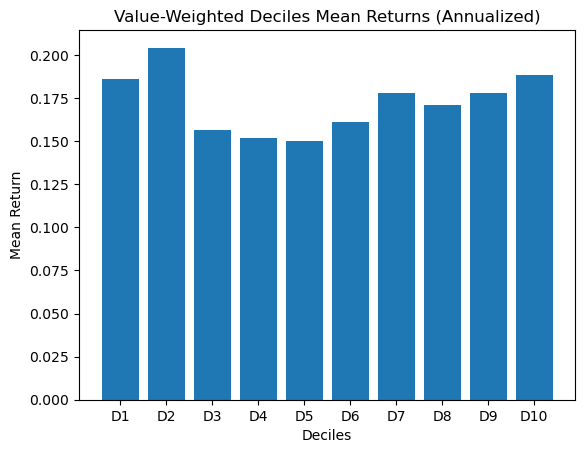

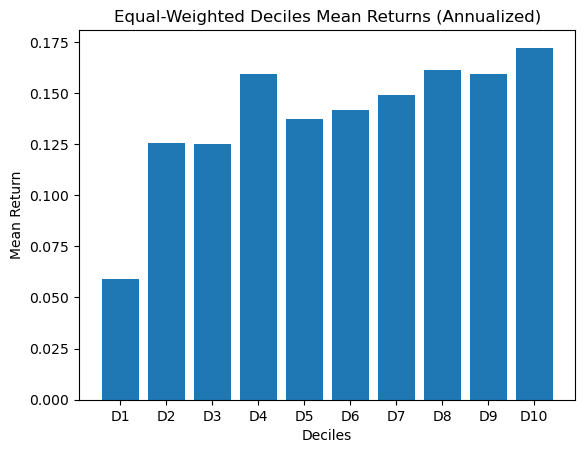

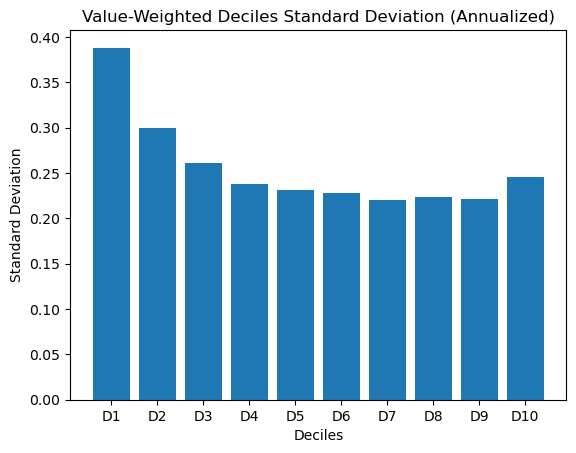

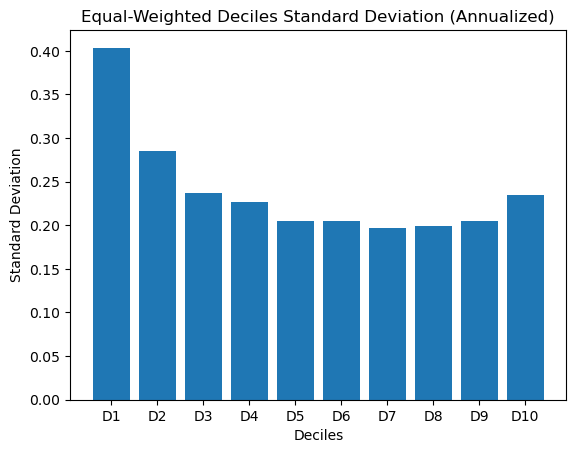

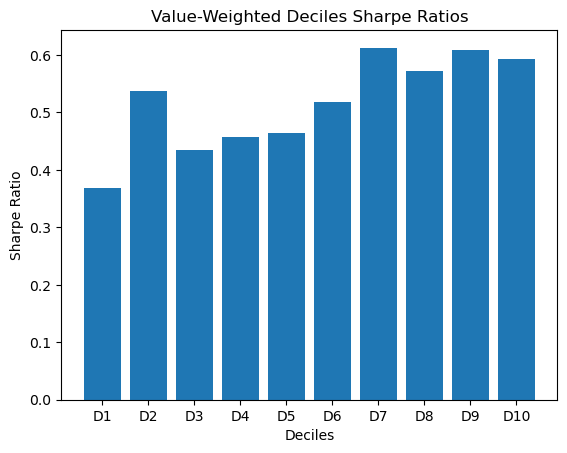

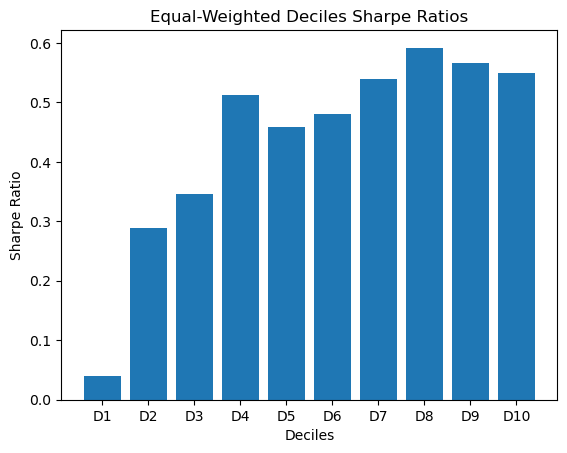

Long Leg Mean Return: 0.16667478160065027
Short Leg Mean Return: 0.10413060078445444
Long Leg Standard Deviation: 0.2014898571355914
Short Leg Standard Deviation: 0.28572503462705906
Long Leg Sharpe Ratio: 0.5630712501330867
Short Leg Sharpe Ratio: 0.17817467411186866
Factor Mean Return: 0.06254418081619582
Factor Standard Deviation: 0.19519096873440683
Factor Sharpe Ratio: 0.047761149106775876
T-Statistic: 8.294010684830411
P-Value: 0.0
The factor strategy has an average return that is statistically significantly different from zero.
Long Leg Mean Return: 0.5368936726874998
Short Leg Mean Return: 0.5465260791284949
Long Leg Standard Deviation: 0.6267425212594152
Short Leg Standard Deviation: 0.8599262909673008
Long Leg Sharpe Ratio: 0.7717236670992156
Short Leg Sharpe Ratio: 0.573658985026982
Factor Mean Return: -0.009632406440995115
Factor Standard Deviation: 0.6538536571288764
Factor Sharpe Ratio: -0.09612860861124185
T-Statistic: -0.3813218080760548
P-Value: 0.64851776328762
The fa

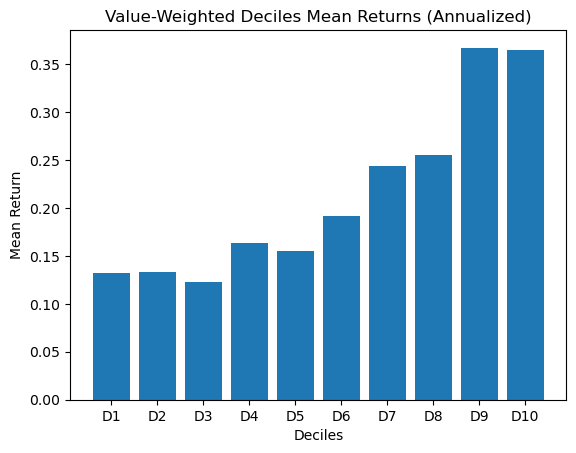

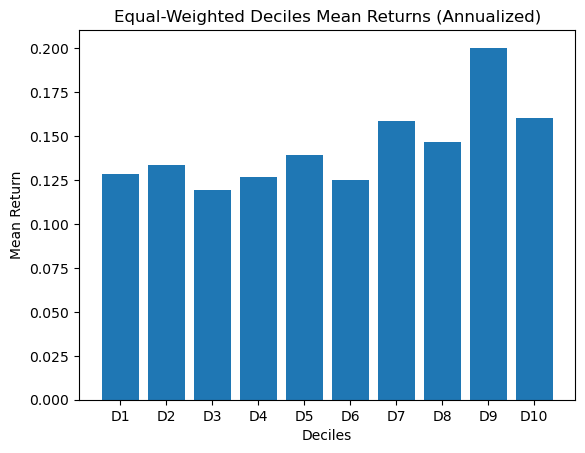

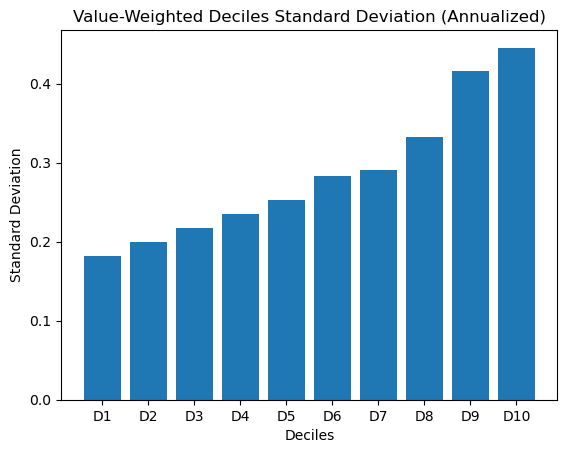

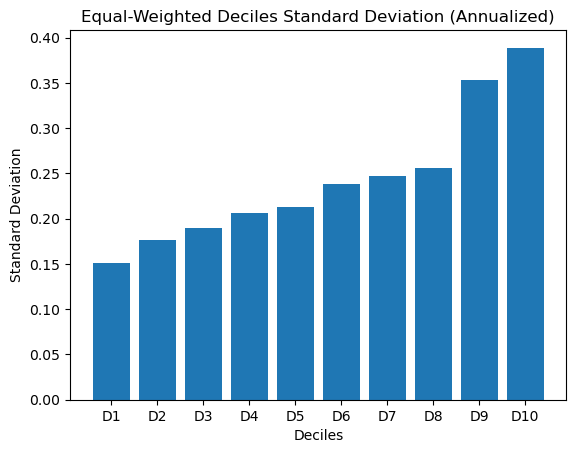

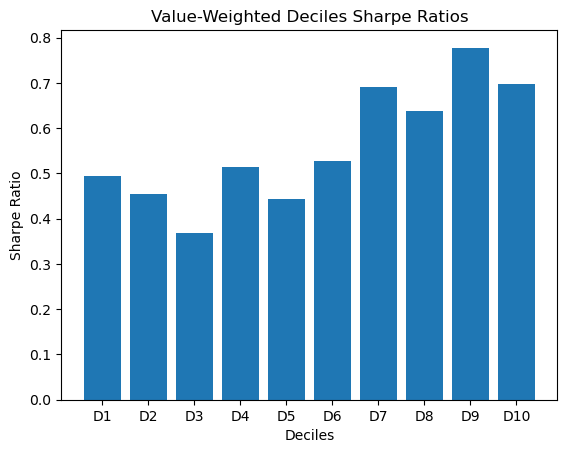

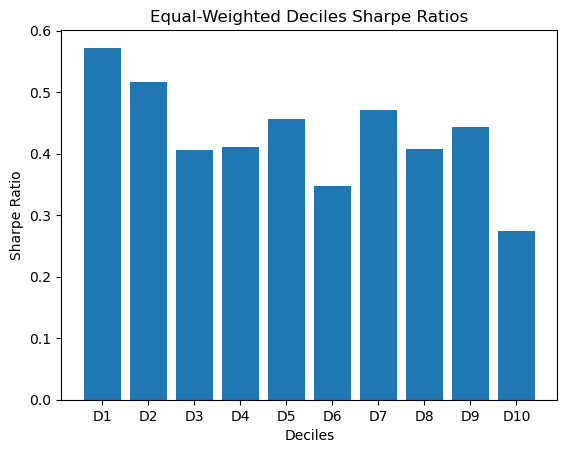

Long Leg Mean Return: 0.17322623080066077
Short Leg Mean Return: 0.12806651440598413
Long Leg Standard Deviation: 0.30455784552222115
Short Leg Standard Deviation: 0.16416050689236342
Long Leg Sharpe Ratio: 0.37181590435821016
Short Leg Sharpe Ratio: 0.41471445024347126
Factor Mean Return: 0.04515971639467664
Factor Standard Deviation: 0.22169884886744998
Factor Sharpe Ratio: -0.06687929919120267
T-Statistic: 5.030981093609169
P-Value: 2.4398813625037263e-07
The factor strategy has an average return that is statistically significantly different from zero.
Long Leg Mean Return: 0.8705916827772352
Short Leg Mean Return: 0.38750738590388234
Long Leg Standard Deviation: 0.9219766378737916
Short Leg Standard Deviation: 0.5565155037586488
Long Leg Sharpe Ratio: 0.8792033002139584
Short Leg Sharpe Ratio: 0.5885201825527117
Factor Mean Return: 0.040257024739446076
Factor Standard Deviation: 0.19975685599378967
Factor Sharpe Ratio: 0.17650521293750523
T-Statistic: 4.9774269856977575
P-Value: 3.

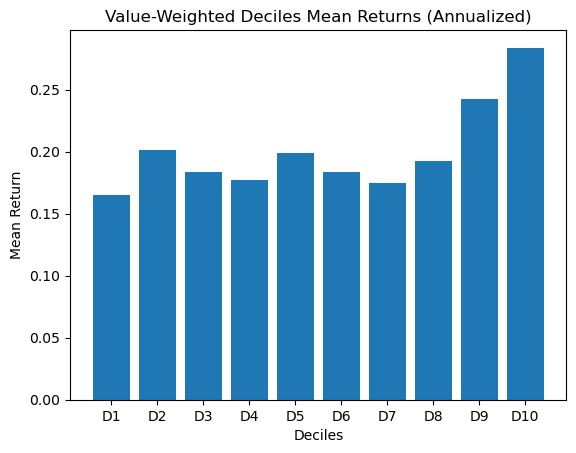

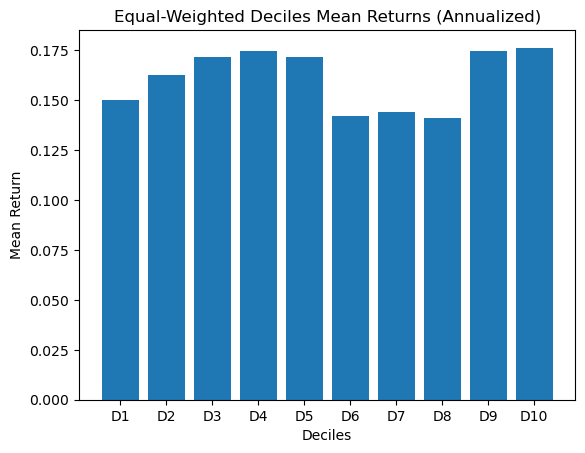

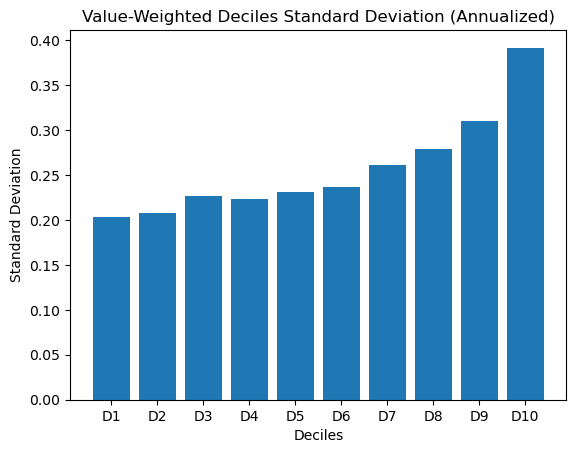

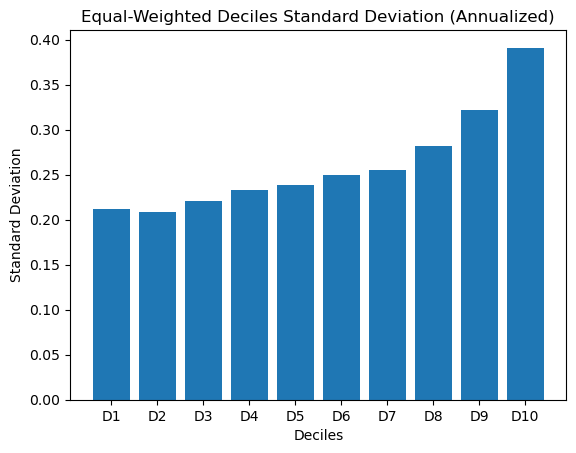

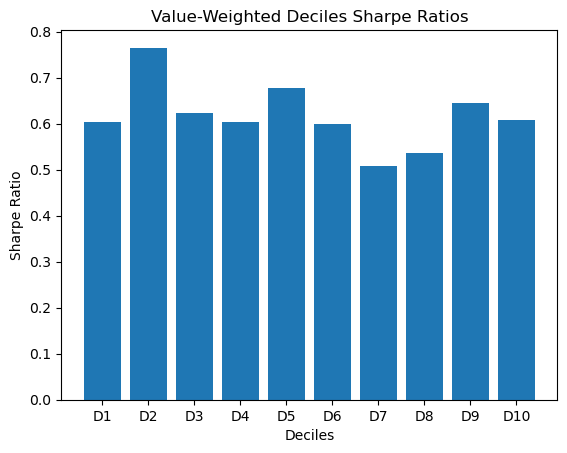

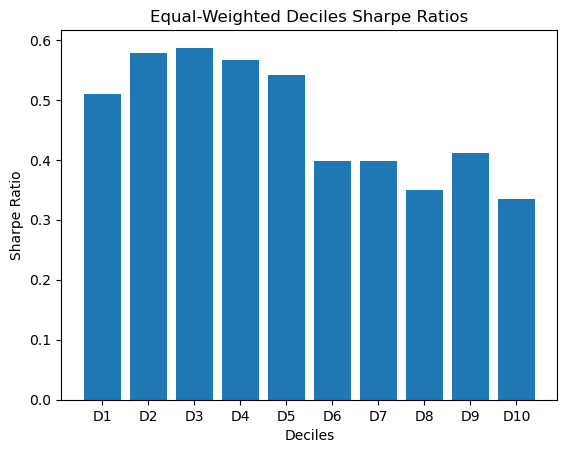

Mean: 0.11169543699543236
Standard Deviation: 0.17896909185994664
Sharpe ratio: 0.6241046196001279
Monthly CAPM Alpha: 0.07380355301372357


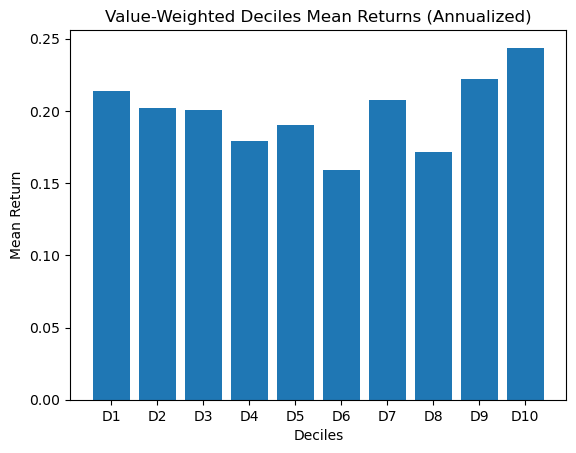

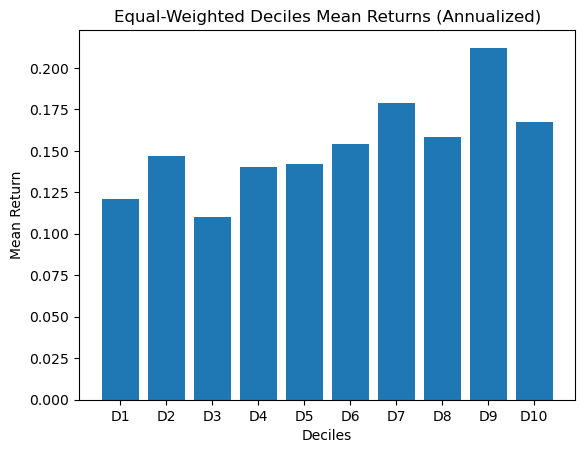

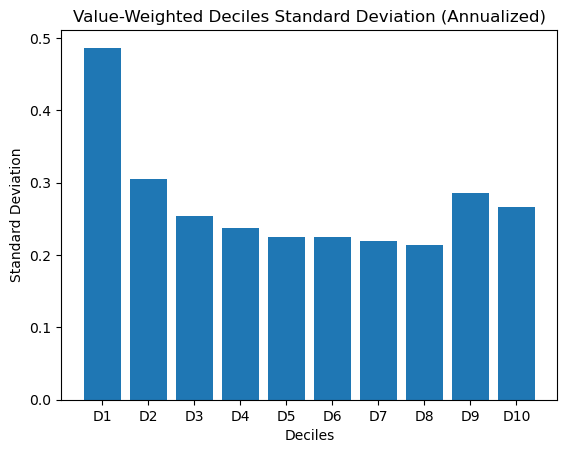

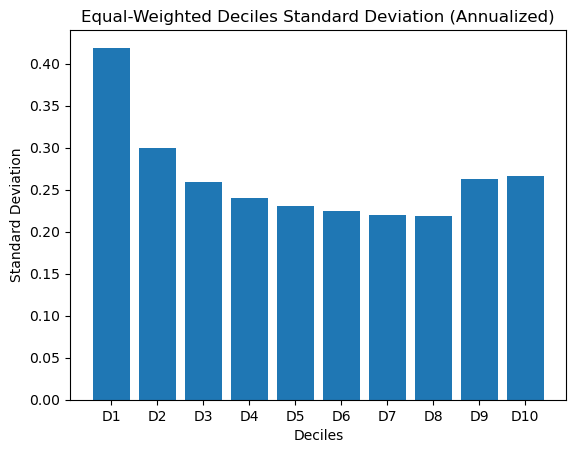

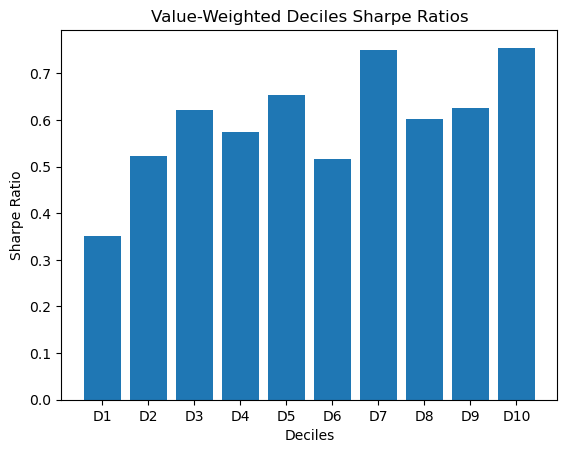

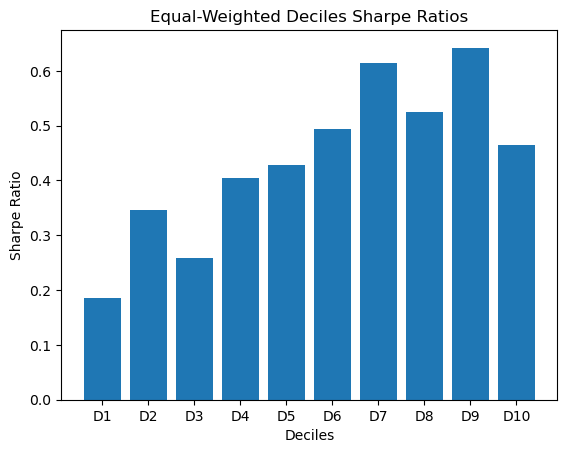

Long Leg Mean Return: 0.18005892581005253
Short Leg Mean Return: 0.12572603490738882
Long Leg Standard Deviation: 0.23098654949923633
Short Leg Standard Deviation: 0.30089688706948176
Long Leg Sharpe Ratio: 0.5499335006412246
Short Leg Sharpe Ratio: 0.24159223304860078
Factor Mean Return: 0.05433289090266378
Factor Standard Deviation: 0.21425035879231466
Factor Sharpe Ratio: 0.006073300726768444
T-Statistic: 6.564152418208443
P-Value: 2.616484806594599e-11
The factor strategy has an average return that is statistically significantly different from zero.
Long Leg Mean Return: 0.6374677105423799
Short Leg Mean Return: 0.6168398378764441
Long Leg Standard Deviation: 0.6746163678956855
Short Leg Standard Deviation: 0.9133154727729645
Long Leg Sharpe Ratio: 0.8663235200214565
Short Leg Sharpe Ratio: 0.6173202695468817
Factor Mean Return: 0.020627872665935937
Factor Standard Deviation: 0.7616686266432265
Factor Sharpe Ratio: -0.04254318773739168
T-Statistic: 0.7010125224285123
P-Value: 0.241

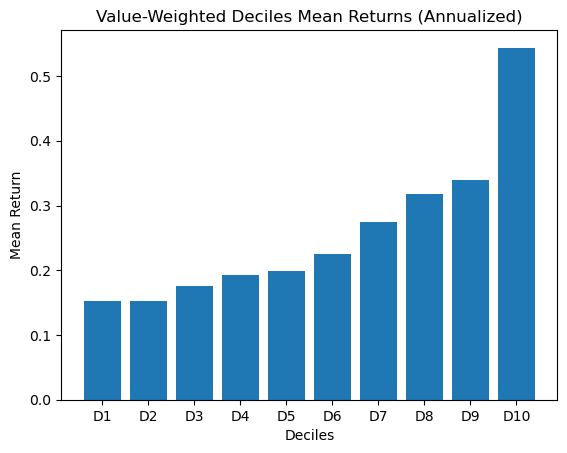

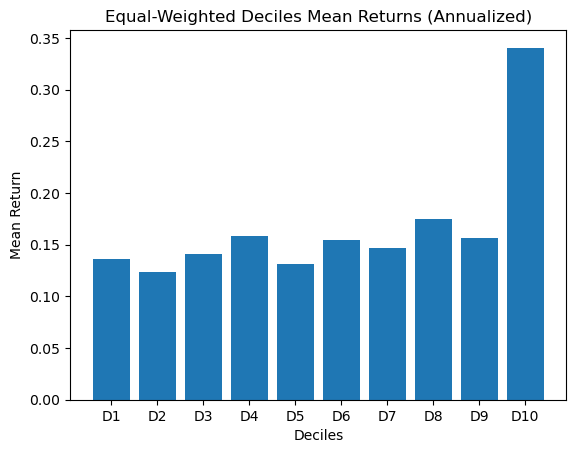

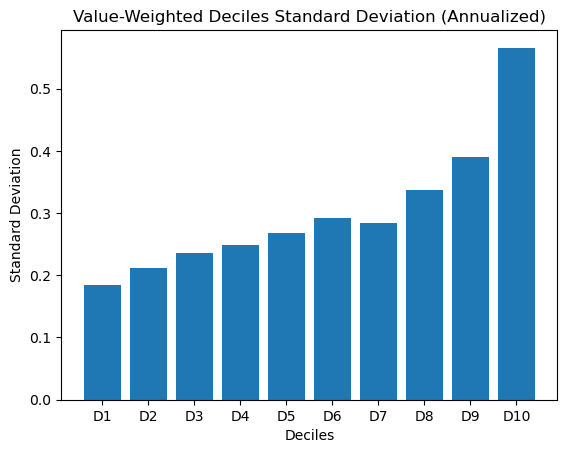

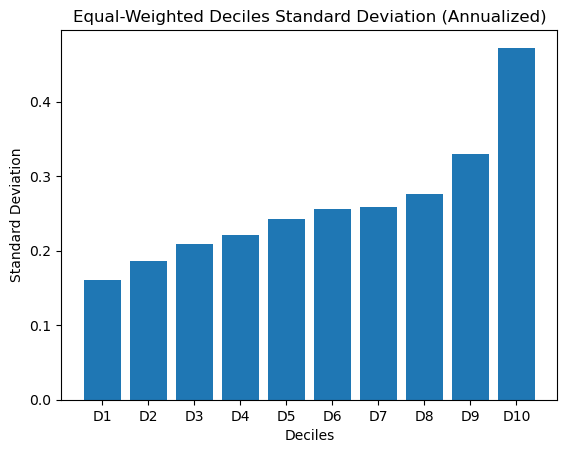

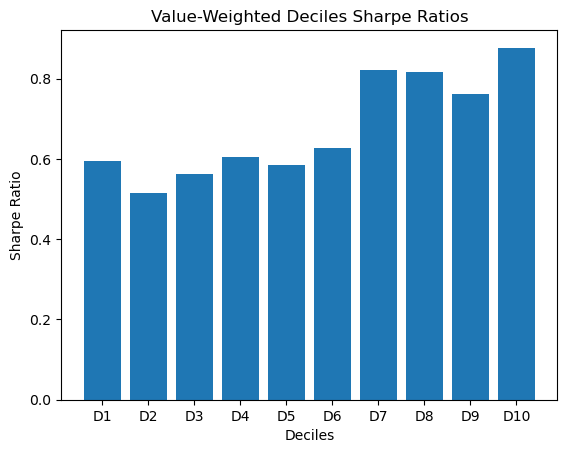

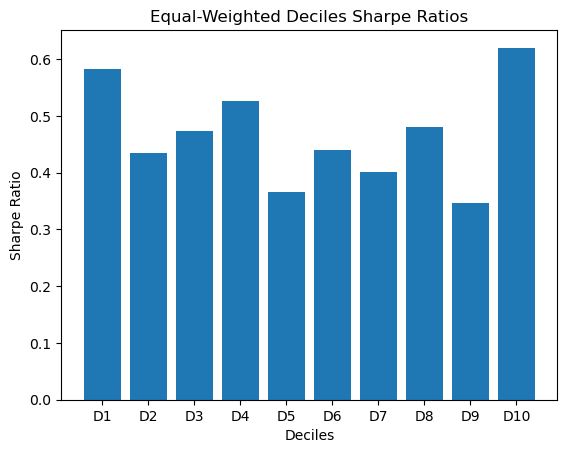

Long Leg Mean Return: 0.21921122975113166
Short Leg Mean Return: 0.1343188254072698
Long Leg Standard Deviation: 0.3125784455564018
Short Leg Standard Deviation: 0.175372379884136
Long Leg Sharpe Ratio: 0.50939036896571
Short Leg Sharpe Ratio: 0.4238526352778642
Factor Mean Return: 0.08489240434386189
Factor Standard Deviation: 0.21552460842343601
Factor Sharpe Ratio: 0.11555814664329349
T-Statistic: 9.728298474365493
P-Value: 0.0
The factor strategy has an average return that is statistically significantly different from zero.
Long Leg Mean Return: 1.125923748354982
Short Leg Mean Return: 0.4793857134285623
Long Leg Standard Deviation: 1.0074179876978913
Short Leg Standard Deviation: 0.5833659453619848
Long Leg Sharpe Ratio: 1.0580880839267004
Short Leg Sharpe Ratio: 0.7189294073892035
Factor Mean Return: 0.053878169577201644
Factor Standard Deviation: 0.2169882480202669
Factor Sharpe Ratio: 0.22526229732082362
T-Statistic: 6.132556202784373
P-Value: 4.323906788172849e-10
The factor s

In [85]:
# for all the industries run all the previous steps
columns = [ 'NoDur', 'Durbl', 'Manuf', 'Enrgy', 'Chems', 'BusEq', 'Telcm', 'Utils', 'Shops', 'Hlth', 'Money', 'Other']
data = pd.read_csv('data_with_industries_with_beta_n.csv', sep=',', encoding='utf-8')

for industry_column_name in columns:
    industry_data = data[data[industry_column_name] == 1].iloc[:, :-13]

    industry_data.to_csv('data.csv', sep=',',index=False)
    clean_data('data.csv')
    add_beta_to_data('data.csv')
    compute_beta_deciles('data_with_beta_n.csv')
    construct_BAB_factor('data_with_beta_n.csv')
    computing_mom_return('data.csv')
    compute_mom_deciles('data_with_momentum.csv')
    mom_equal_weigthed_factor('data_with_momentum.csv')
    mom_value_weigthed_factor('data_with_momentum.csv', 'strat.csv')
    compute_IV('data_with_beta_n.csv')
    compute_IV_deciles('data_with_IV.csv')
    IV_equal_weigthed_factor('data_with_IV.csv')
    IV_value_weigthed_factor('data_with_IV.csv')
    strat1_std, strat2_std, strat3_std = strat_portfolio('strat.csv')
    find_c('strat.csv', strat1_std, strat2_std, strat3_std)
    industry_data = pd.read_csv('strat.csv')
    filename = f"{industry_column_name}.csv"
    industry_data[['date', 'fund2', 'rf']].to_csv(filename, sep=',', index=False)    

# 8A

In [86]:
# columns = [ 'NoDur', 'Durbl', 'Manuf', 'Enrgy', 'Chems', 'BusEq', 'Telcm', 'Utils', 'Shops', 'Hlth', 'Money', 'Other']
nodur = pd.read_csv('NoDur.csv', )
durbl = pd.read_csv('Durbl.csv', )
manuf = pd.read_csv('Manuf.csv', )
enrgy = pd.read_csv('Enrgy.csv', )
chems = pd.read_csv('Chems.csv', )
buseq = pd.read_csv('BusEq.csv', )
telcm = pd.read_csv('Telcm.csv', )
utils = pd.read_csv('Utils.csv', )
shops = pd.read_csv('Shops.csv', )
hlth = pd.read_csv('Hlth.csv', )
money = pd.read_csv('Money.csv', )
other = pd.read_csv('Other.csv', )


In [87]:
industry_dfs = {
    'nodur': nodur,
    'durbl': durbl,
    'manuf': manuf,
    'enrgy': enrgy,
    'chems': chems,
    'buseq': buseq,
    'telcm': telcm,
    'utils': utils,
    'shops': shops,
    'hlth': hlth,
    'money': money,
    'other': other
}


In [88]:
industries = pd.DataFrame(columns=['mean', 'std', 'sharpe', 't-stat'])

# for each industry dataframe compute mean, std, sharpe ratio and t-stat from column 'fund2'
for name, df in industry_dfs.items():
    mean = df['fund2'].mean() * 12
    std = df['fund2'].std() * np.sqrt(12)
    excess = df['fund2'] - df['rf']
    sharpe = (excess.mean() / df['fund2'].std()) * np.sqrt(12)
    t_stat = mean / (std / np.sqrt(len(df)))
    row = pd.DataFrame({'mean': [mean], 'std': [std], 'sharpe': [sharpe], 't-stat': [t_stat]}, index=[name])
    industries = pd.concat([industries, row])


C:\Users\ratas\AppData\Local\Temp\ipykernel_14916\2461961039.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  industries = pd.concat([industries, row])


In [89]:
industries

mean       std    sharpe     t-stat
nodur  0.099496  0.101134  0.577874  25.004891
durbl  0.091699  0.100985  0.503701  23.079521
manuf  0.131421  0.100861  0.898068  33.117487
enrgy  0.103984  0.100688  0.625445  26.248632
chems  0.093159  0.100704  0.519606  23.494240
buseq  0.107022  0.100685  0.657315  27.016363
telcm  0.068030  0.100053  0.272267  17.268282
utils  0.109189  0.101107  0.673194  27.448157
shops  0.116252  0.100626  0.749425  29.363517
hlth   0.090438  0.100654  0.492927  22.819245
money  0.114125  0.101221  0.724073  28.634392
other  0.131351  0.100400  0.901567  33.251689

# 8B

In [90]:
# Step 1: Ensure all dataframes have a common column 'date' for merging
for df in industry_dfs.values():
    df.set_index('date', inplace=True)

# Step 2: Concatenate all dataframes along column axis
ew_industry_neutral = pd.concat(industry_dfs.values(), axis=1)

In [91]:

# Step 3: Create a new column 'fund2_avg' that is the average of all 'fund2' columns
ew_industry_neutral['fund2_avg'] = ew_industry_neutral['fund2'].mean(axis=1)
ew_industry_neutral['rf_unique'] = ew_industry_neutral.iloc[:, 0]
# Keep only the 'fund2_avg' column
ew_industry_neutral = ew_industry_neutral[['fund2_avg', 'rf_unique']].dropna()
ew_industry_neutral

fund2_avg  rf_unique
date                            
1976-01-01   0.052006   0.063780
1976-02-01   0.020253   0.022514
1976-03-01   0.008874   0.010772
1976-04-01   0.003558  -0.002941
1976-05-01   0.002025  -0.011830
...               ...        ...
2023-08-01   0.011487  -0.018736
2023-09-01  -0.005494  -0.031239
2023-10-01   0.005564  -0.022665
2023-11-01   0.028293   0.058672
2023-12-01   0.006721   0.027834

[573 rows x 2 columns]

In [92]:

ew_industry_neutral_mean = ew_industry_neutral['fund2_avg'].mean() * 12
ew_industry_neutral_std = ew_industry_neutral['fund2_avg'].std() * np.sqrt(12)
excess_ew_industry_neutral = ew_industry_neutral['fund2_avg'] - ew_industry_neutral['rf_unique']
ew_industry_neutral_sharpe = excess_ew_industry_neutral.mean() / ew_industry_neutral["fund2_avg"].std() * np.sqrt(12)

# Print the results
print('Equal Weighted industry_neutral:')
print('Mean:', ew_industry_neutral_mean)
print('Standard Deviation:', ew_industry_neutral_std)
print('Sharpe Ratio:', ew_industry_neutral_sharpe)
print("\n")


Equal Weighted industry_neutral:
Mean: 0.10506457937697103
Standard Deviation: 0.05812547191871338
Sharpe Ratio: 0.09579932059056452




# 8C

In [93]:
import statsmodels.api as sm
# Load the datasets
french_factors = pd.read_csv('french_factors.csv', )
industry_returns = pd.read_csv('industry_returns.csv', )
strategy_returns = ew_industry_neutral.reset_index()

# Rename columns for clarity
french_factors.columns = ['date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
industry_returns.columns = ['date', 'NoDur', 'Durbl', 'Manuf', 'Enrgy', 'Chems', 'BusEq', 'Telcm', 'Utils', 'Shops', 'Hlth', 'Money', 'Other']
strategy_returns.columns = ['date', 'fund2_avg', 'rf_unique']

# Merge data on 'date'
merged_data = pd.merge(strategy_returns, french_factors, on='date')
merged_data = pd.merge(merged_data, industry_returns, on='date')

# Drop rows with missing values
merged_data = merged_data.dropna()

# Extract the dependent variable 
Y = merged_data['fund2_avg'] - merged_data['rf_unique']

# Extract the independent variables (12 industry returns and Fama-French 5 factors)
X = merged_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'NoDur', 'Durbl', 'Manuf', 'Enrgy', 'Chems', 'BusEq', 'Telcm', 'Utils', 'Shops', 'Hlth', 'Money', 'Other']].astype(float)

# Add a constant term for the intercept
X = sm.add_constant(X)

# Perform the regression
model = sm.OLS(Y, X).fit()

# Display the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     3.243
Date:                Fri, 21 Jun 2024   Prob (F-statistic):           7.77e-06
Time:                        21:53:22   Log-Likelihood:                 5380.5
No. Observations:                2292   AIC:                        -1.073e+04
Df Residuals:                    2274   BIC:                        -1.062e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.944      0.3